(c) Julia Riedl 2025
The code iterates through folders of recording dates and contained single well movie folders.

For each well pixels in areas of user-defined sizes are subtracted from "inc" frames later to calculate pixel variance.
This is done in "framestep" intervals, e.g.  every 2 seconds if framestep=60 for  30hz movie data.

Data are stored in dictionary "MovieVarData"


In [2]:
#import libraries
import os
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
from pathlib import Path
from skimage import filters, measure
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from skimage.draw import disk
from natsort import natsorted
from collections import defaultdict
from IPython.display import display



import statsmodels.api as sm
import statsmodels.formula.api as smf



## Processing single-well videos for pixel variation

In [35]:
# Parameters:
imout = 1 #figure output 1=yes, 0=no
tl = 0.8  # Binarisation threshold level factor starting level
well_r = 457  # Well radius in pixels ## This was originally 120, but the radius is around 457 actually.
inc = 3  # Frame increment between frames to be subtracted
framestep=3 # frame interval between frame samples for variance 
sigma = 0.6  # Gaussian filter strength, the higher the stronhger the filter
framenums = 33  # Number of frames to be processed

In [36]:
# (1)indicate data location
# initialise dictionary holding data for various movies in given folder
parentF = r'/Users/jb3623/Desktop/basler/video/mutant_screen/batch_4'
os.chdir(parentF)
dayfolders = os.listdir(parentF)
dayfolders.sort()

#try to load partial data back if existing:
#load data back

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

try:
    with open('MovieVarDataP.p', 'rb') as fp:
        MovieVarData = pickle.load(fp)
        print('loaded previous data')
        days = list(MovieVarData.keys())
        currd = MovieVarData.get(days[-1])
        print("last recording day analysed:" + str(days[-1]))
        dm = list(currd.keys())
        print(dm[-1])
        #find last recording day analysed
        di = [i for i, s in enumerate(dayfolders) if days[-1] in s]
        di = di[0]
        print(di)
        # di=int(di)
        #find last movie analysed
        mov_idx = len(currd)
        # mi=int(mi)

except Exception:
    print('No MovieVarData found in current directory.')
    MovieVarData = {}
    di = 1
    mov_idx = 1
    print(di)


No MovieVarData found in current directory.
1


In [4]:
# BWLevel = filters.threshold_otsu(frame)*0.9
# fn=frame[::10, ::10, 0]
# BW = fn > BWLevel
os.chdir(os.path.join(parentF,DD, movie))
print(os.getcwd())
#MovieVarData[movie]=plate
np.save('MovieVarData.npy', MovieVarData)
os.chdir("..")

ps=fn.shape
print(wellfolders)
rr, cc = disk((round(ps[0]/2) , round(ps[1]/2)), round(ps[0]/2.5), shape=ps)
mask = np.zeros(pic_o.shape, dtype=bool)
mask[rr,cc] = 1
plt.imshow(mask)
plt.colorbar()

plt.figure
#plt.imshow(difpic)
plt.title(ti)



NameError: name 'DD' is not defined

In [37]:
#---main code:----
# (1) goes through folders of recording days and  loads movies 
# (2) finds X and Y offset from theoretical well centroids as given in paranmeter section
# (3) creates a mask for each well with corrected well centroid of given radius from paramter section 
# (4) subtracts pixel values from each well from next movie frame with interval defined in parameters
# ----------


# (1) change into folders containing movies
os.chdir(parentF)
dayfolders = [f for f in os.listdir(parentF) if os.path.isdir(os.path.join(parentF, f))]
dayfolders.sort()
dayfolders = np.array(dayfolders)
print('found subdirectories:' + str(len(dayfolders)))
dc = 1

for DD in dayfolders:  # go through recording dates
    os.chdir(os.path.join(parentF, DD))
    print('current day dir: ' + DD)
    subdirectory = os.getcwd()
    moviefolders = os.listdir(subdirectory)
    moviefolders.sort()

    if dc > 1:
        mov_idx = 1
    print('starting at folder#' + str(mov_idx) + ' of ' + str(len(moviefolders)))
    moviefolders = moviefolders[mov_idx:]

    dc = dc + 1

    # Reset MovieVarData for each recording day
    MovieVarData = {}

    # go through recording day folders as given in days variable
    mc = 0
    for movie in moviefolders:
        mc = mc + 1
        movie_path = os.path.join(parentF, DD, movie, 'single_wells')
        if not os.path.isdir(movie_path):
            print(f"Skipping {movie_path}, not a directory")
            continue
        os.chdir(movie_path)
        subdirectory = os.getcwd()
        wellfolders = os.listdir(subdirectory)
        wellfolders.sort()

        plate = {}
        for wf in wellfolders:
            well_path = os.path.join(parentF, DD, movie, 'single_wells', wf)
            if os.path.isdir(well_path):
                os.chdir(well_path)

            # Find and load the .avi file
            movie_files = [f for f in os.listdir() if f.endswith('.avi')]
            if not movie_files:
                continue

            v = cv2.VideoCapture(movie_files[0])
            print("Loaded movie#", mc, ';', wf)

            # Get the total number of frames in the video
            total_frames = int(v.get(cv2.CAP_PROP_FRAME_COUNT))

            well_diffs = np.zeros(round(framenums / framestep) + 1)
            FC = 1

            for fr in range(1, framenums, framestep):  # pixel variance every "framestep" frames(e.g.60=2sec)
                # at frame 1: assess well position offset from given theoretical well centroids
                # by binarising image with correct threshold to find round structures of expected size
                if FC == 1:
                    # Set the video position to the desired frame
                    v.set(cv2.CAP_PROP_POS_FRAMES, fr)
                    # Read the frame
                    ret, frame = v.read()
                    if not ret:
                        print('couldnt read frame from video')
                        break

                    # make mask
                    fn = frame[::2, ::2, 0]
                    ps = fn.shape
                    rr, cc = disk((round(ps[0] / 2), round(ps[1] / 2)), round(ps[0] / 2.5), shape=ps)
                    mask = np.zeros(fn.shape, dtype=bool)
                    mask[rr, cc] = 1

                # Calculate pixel variance over time for each well
                diff_pix = [None] * 3

                # Set the video position to the desired frame
                v.set(cv2.CAP_PROP_POS_FRAMES, fr)
                # Read the frame
                ret, frame_o = v.read()
                if not ret:
                    print('couldnt read frame from video')
                    break

                pic_o = frame_o[:, :, 0].astype(float)
                pic_of = gaussian_filter(pic_o, sigma)

                # Check if fr + inc exceeds the total number of frames
                if fr + inc >= total_frames:
                    print('Frame index exceeds total number of frames in the video')
                    break

                # Set the video position to the desired frame
                v.set(cv2.CAP_PROP_POS_FRAMES, fr + inc)
                # Read the frame
                ret, frame_1 = v.read()
                if not ret:
                    print('couldnt read frame from video')
                    break

                pic1 = frame_1[:, :, 0].astype(float)
                pic1f = gaussian_filter(pic1, sigma)

                pic1 = pic1f[::2, ::2]
                pic_o = pic_of[::2, ::2]
                difpic = np.abs(pic1 - pic_o)

                mi = np.nonzero(mask)
                diff_pix = difpic[mi]
                dpn = len(diff_pix[diff_pix > 4])  # number of pixels with diff >4
                difp_norm = dpn / sum(sum(mask))  # normalised to number of pixels in well
                # change to simply pixel diffs>4
                if FC == 1 and imout == 1:
                    plt.imshow(difpic)
                    plt.colorbar()
                    imname = 'pix_var_' + wf + '.png'
                    plt.title(wf)
                    plt.savefig(imname, dpi=300, format='png', bbox_inches='tight')
                    plt.close()
                well_diffs[FC] = difp_norm
                FC += 1

                if FC % 4 == 0:
                    print(f"Frames analysed: {FC}")
            # save
            plate[wf] = well_diffs

        # Save MovieVarData for the current movie
        MovieVarData[movie] = plate
        movie_var_data_path = os.path.join(parentF, DD, movie, 'MovieVarData.npy')
        if os.path.exists(movie_var_data_path):
            os.remove(movie_var_data_path)
        np.save(movie_var_data_path, MovieVarData)
        os.chdir("..")

    # Save MovieVarData for the current day
    day_var_data_path = os.path.join(parentF, DD, 'MovieVarData.npy')
    if os.path.exists(day_var_data_path):
        os.remove(day_var_data_path)
    np.save(day_var_data_path, MovieVarData)
    os.chdir("..")

# Final save of MovieVarData
final_var_data_path = 'MovieVarData.npy'
if os.path.exists(final_var_data_path):
    os.remove(final_var_data_path)
np.save(final_var_data_path, MovieVarData)

found subdirectories:1
current day dir: 250401
starting at folder#1 of 38
Loaded movie# 1 ; A1
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A10
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A11
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A12
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A2
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A3
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A4
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A5
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A6
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A7
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A8
Frames analysed: 4
Frames analysed: 8
Frames analysed: 12
Loaded movie# 1 ; A9
Frames analysed: 4
Frames analyse

In [ ]:
os.chdir(parentF)
currdir=os.getcwd()
print(currdir)
print(DD)

In [18]:
#save:
os.chdir('/Users/jriedl/Desktop/NHR_temp')
currdir=os.getcwd()
print(currdir)

#'MovieVarData.npy', MovieVarData

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open('MovieVarDataP.p', 'wb') as fp:
    pickle.dump(MovieVarData, fp, protocol=pickle.HIGHEST_PROTOCOL)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jriedl/Desktop/NHR_temp'

## Plotting data
(c) John Bergqvist 2025



/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_43419/2566603926.py:54: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)


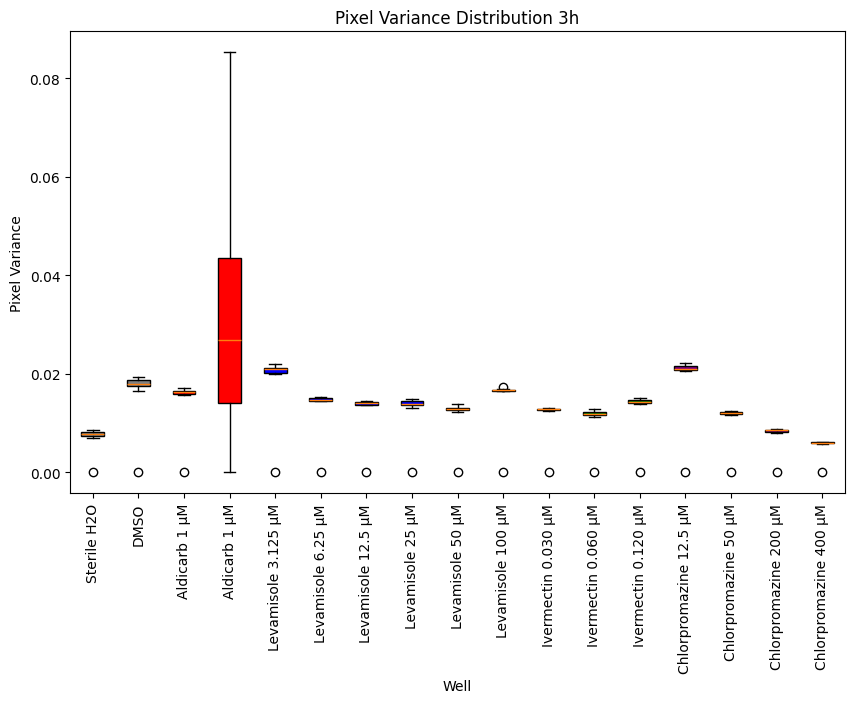

In [4]:
# Plotting the pixel variance data for 3h movies

import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted

# Load the data from the .npy file
movie_var_data_3h = np.load('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/video/pre_screen/N2_Exp1/250211_3h/MovieVarData.npy', allow_pickle=True).item()

# Select the data to plot
data_to_plot_1_3h = movie_var_data_3h['not_viscous_2']

# Sort the data by well names using natsort
sorted_keys = natsorted(data_to_plot_1_3h.keys())

# Define the custom order for the labels
custom_order = [key for key in ['E9', 'F8'] if key in data_to_plot_1_3h] + [key for key in sorted_keys if key not in ['E9', 'F8']]

# Prepare data for boxplot
data = [data_to_plot_1_3h[key] for key in custom_order]
labels = custom_order

# Create a mapping of original labels to custom labels
custom_labels_map = {
    'A6': 'Aldicarb 1 µM',
    'A12': 'Aldicarb 1 µM',
    'B1': 'Levamisole 3.125 µM',
    'B2': 'Levamisole 6.25 µM',
    'B3': 'Levamisole 12.5 µM',
    'B4': 'Levamisole 25 µM',
    'B5': 'Levamisole 50 µM',
    'B6': 'Levamisole 100 µM',
    'C4': 'Ivermectin 0.030 µM',
    'C5': 'Ivermectin 0.060 µM',
    'C6': 'Ivermectin 0.120 µM',
    'D1': 'Chlorpromazine 12.5 µM',
    'D3': 'Chlorpromazine 50 µM',
    'D5': 'Chlorpromazine 200 µM',
    'D6': 'Chlorpromazine 400 µM',
    'E9': 'Sterile H2O',
    'F8': 'DMSO'
}

# Define color map for each well name letter
color_map = {
    'A': 'red',
    'B': 'blue',
    'C': 'green',
    'D': 'purple'
}

# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)

# Color the boxplots
for patch, label in zip(boxplot['boxes'], labels):
    if label == 'Sterile H2O':
        patch.set_facecolor('gray')
    elif label == 'DMSO':
        patch.set_facecolor('gray')
    else:
        well_letter = label[0]
        patch.set_facecolor(color_map.get(well_letter, 'gray'))

# Add labels and title
plt.xlabel('Well')
plt.ylabel('Pixel Variance')
plt.title('Pixel Variance Distribution 3h')

# Change x-axis label orientation
plt.xticks(rotation=90)

# Save the plot
plt.savefig('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/pre_screen/Exp1_N2/250211_3h/pixel_variance_Exp1_N2_3h.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_43419/1408173284.py:88: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)


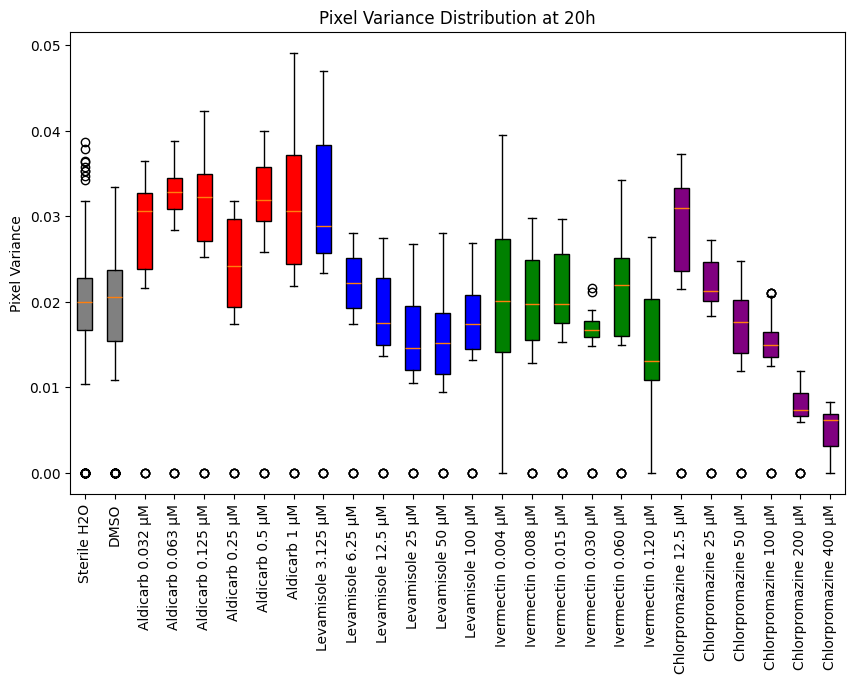

In [5]:
# Plotting the pixel variance data for 20h movies

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from natsort import natsorted

# Load the data from the .npy file
movie_var_data_20h = np.load('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/video/pre_screen/N2_Exp1/250212_20h/MovieVarData.npy', allow_pickle=True).item()

# Select the data to plot
data_to_plot_1_20h = movie_var_data_20h['not_viscous_1']
data_to_plot_2_20h = movie_var_data_20h['not_viscous_2']

# Combine the data from both keys
combined_data_to_plot = defaultdict(list)
for key in data_to_plot_1_20h:
    combined_data_to_plot[key].extend(data_to_plot_1_20h[key])
for key in data_to_plot_2_20h:
    combined_data_to_plot[key].extend(data_to_plot_2_20h[key])

# Sort the data by well names using natsort
sorted_keys = natsorted(combined_data_to_plot.keys())

# Group data by well letter and combine replicates
grouped_data = defaultdict(list)
labels_map = defaultdict(list)
for key in sorted_keys:
    letter = key[0]
    if letter == 'E':
        grouped_key = 'Sterile H2O'
    elif letter == 'F':
        grouped_key = 'DMSO'
    else:
        replicate_group = (int(key[1:]) - 1) % 6 + 1
        grouped_key = f"{letter}{replicate_group}"
    grouped_data[grouped_key].extend(combined_data_to_plot[key])
    labels_map[grouped_key].append(key)

# Define the custom order for the labels
custom_order = ['Sterile H2O', 'DMSO'] + [key for key in natsorted(grouped_data.keys()) if key not in ['Sterile H2O', 'DMSO']]

# Prepare data for boxplot
data = [grouped_data[key] for key in custom_order]
labels = [key if key in ['Sterile H2O', 'DMSO'] else f"{' & '.join(labels_map[key])}" for key in custom_order]

# Create a mapping of original labels to custom labels
custom_labels_map = {
    'A1 & A7': 'Aldicarb 0.032 µM',
    'A2 & A8': 'Aldicarb 0.063 µM',
    'A3 & A9': 'Aldicarb 0.125 µM',
    'A4 & A10': 'Aldicarb 0.25 µM',
    'A5 & A11': 'Aldicarb 0.5 µM',
    'A6 & A12': 'Aldicarb 1 µM',
    'B1 & B7': 'Levamisole 3.125 µM',
    'B2 & B8': 'Levamisole 6.25 µM',
    'B3 & B9': 'Levamisole 12.5 µM',
    'B4 & B10': 'Levamisole 25 µM',
    'B5 & B11': 'Levamisole 50 µM',
    'B6 & B12': 'Levamisole 100 µM',
    'C1 & C7': 'Ivermectin 0.004 µM',
    'C2 & C8': 'Ivermectin 0.008 µM',
    'C3 & C9': 'Ivermectin 0.015 µM',
    'C4 & C10': 'Ivermectin 0.030 µM',
    'C5 & C11': 'Ivermectin 0.060 µM',
    'C6 & C12': 'Ivermectin 0.120 µM',
    'D1 & D7': 'Chlorpromazine 12.5 µM',
    'D2 & D8': 'Chlorpromazine 25 µM',
    'D3 & D9': 'Chlorpromazine 50 µM',
    'D4 & D10': 'Chlorpromazine 100 µM',
    'D5 & D11': 'Chlorpromazine 200 µM',
    'D6 & D12': 'Chlorpromazine 400 µM',
    'Sterile H2O': 'Sterile H2O',
    'DMSO': 'DMSO'
}


# Define color map for each well name letter
color_map = {
    'A': 'red',
    'B': 'blue',
    'C': 'green',
    'D': 'purple'
}

# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)

# Color the boxplots
for patch, label in zip(boxplot['boxes'], labels):
    if label == 'Sterile H2O':
        patch.set_facecolor('gray')
    elif label == 'DMSO':
        patch.set_facecolor('gray')
    else:
        well_letter = label[0]
        patch.set_facecolor(color_map.get(well_letter, 'gray'))
# Add labels and title
plt.xlabel('')
plt.ylabel('Pixel Variance')
plt.title('Pixel Variance Distribution at 20h')

# Change x-axis label orientation
plt.xticks(rotation=90)

# Save the plot
plt.savefig('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/pre_screen/Exp1_N2/250212_20h/pixel_variance_Exp1_N2_20h.png', dpi=300, format='png', bbox_inches='tight')


# Show the plot
plt.show()

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_43419/2866984621.py:87: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)


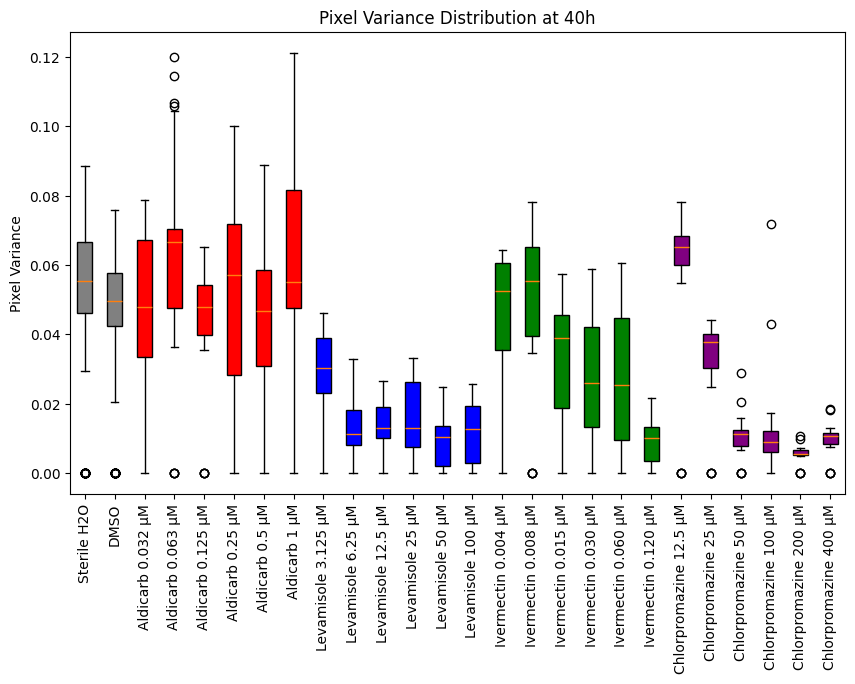

In [6]:
# Plotting the pixel vairance data for 40h movies

# Load the data from the .npy file
movie_var_data_40h = np.load('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/video/pre_screen/N2_Exp1/250213_40h/MovieVarData.npy', allow_pickle=True).item()


# Select the data to plot
data_to_plot_1_40h = movie_var_data_40h['not_viscous_1']
data_to_plot_2_40h = movie_var_data_40h['not_viscous_2']

# Combine the data from both keys
combined_data_to_plot = defaultdict(list)
for key in data_to_plot_1_40h:
    combined_data_to_plot[key].extend(data_to_plot_1_40h[key])
for key in data_to_plot_2_40h:
    combined_data_to_plot[key].extend(data_to_plot_2_40h[key])

# Sort the data by well names using natsort
sorted_keys = natsorted(combined_data_to_plot.keys())

# Group data by well letter and combine replicates
grouped_data = defaultdict(list)
labels_map = defaultdict(list)
for key in sorted_keys:
    letter = key[0]
    if letter == 'E':
        grouped_key = 'Sterile H2O'
    elif letter == 'F':
        grouped_key = 'DMSO'
    else:
        replicate_group = (int(key[1:]) - 1) % 6 + 1
        grouped_key = f"{letter}{replicate_group}"
    grouped_data[grouped_key].extend(combined_data_to_plot[key])
    labels_map[grouped_key].append(key)

# Define the custom order for the labels
custom_order = ['Sterile H2O', 'DMSO'] + [key for key in natsorted(grouped_data.keys()) if key not in ['Sterile H2O', 'DMSO']]

# Prepare data for boxplot
data = [grouped_data[key] for key in custom_order]
labels = [key if key in ['Sterile H2O', 'DMSO'] else f"{' & '.join(labels_map[key])}" for key in custom_order]

# Create a mapping of original labels to custom labels
custom_labels_map = {
    'A1 & A7': 'Aldicarb 0.032 µM',
    'A2 & A8': 'Aldicarb 0.063 µM',
    'A3 & A9': 'Aldicarb 0.125 µM',
    'A4 & A10': 'Aldicarb 0.25 µM',
    'A5 & A11': 'Aldicarb 0.5 µM',
    'A6 & A12': 'Aldicarb 1 µM',
    'B1 & B7': 'Levamisole 3.125 µM',
    'B2 & B8': 'Levamisole 6.25 µM',
    'B3 & B9': 'Levamisole 12.5 µM',
    'B4 & B10': 'Levamisole 25 µM',
    'B5 & B11': 'Levamisole 50 µM',
    'B6 & B12': 'Levamisole 100 µM',
    'C1 & C7': 'Ivermectin 0.004 µM',
    'C2 & C8': 'Ivermectin 0.008 µM',
    'C3 & C9': 'Ivermectin 0.015 µM',
    'C4 & C10': 'Ivermectin 0.030 µM',
    'C5 & C11': 'Ivermectin 0.060 µM',
    'C6 & C12': 'Ivermectin 0.120 µM',
    'D1 & D7': 'Chlorpromazine 12.5 µM',
    'D2 & D8': 'Chlorpromazine 25 µM',
    'D3 & D9': 'Chlorpromazine 50 µM',
    'D4 & D10': 'Chlorpromazine 100 µM',
    'D5 & D11': 'Chlorpromazine 200 µM',
    'D6 & D12': 'Chlorpromazine 400 µM',
    'Sterile H2O': 'Sterile H2O',
    'DMSO': 'DMSO'
    #'E1 & E2 & E3 & E4 & E5 & E6 & E7 & E8 & E9 & E10 & E11 & E12': 'Sterile H2O',
    #'F1 & F2 & F3 & F4 & F5 & F6 & F7 & F8 & F9 & F10 & F11 & F12': 'DMSO',
    # Add more mappings as needed
}


# Define color map for each well name letter
color_map = {
    'A': 'red',
    'B': 'blue',
    'C': 'green',
    'D': 'purple'
}

# Create the boxplot
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)

# Color the boxplots
for patch, label in zip(boxplot['boxes'], labels):
    if label == 'Sterile H2O':
        patch.set_facecolor('gray')
    elif label == 'DMSO':
        patch.set_facecolor('gray')
    else:
        well_letter = label[0]
        patch.set_facecolor(color_map.get(well_letter, 'gray'))
# Add labels and title
plt.xlabel('')
plt.ylabel('Pixel Variance')
plt.title('Pixel Variance Distribution at 40h')

# Change x-axis label orientation
plt.xticks(rotation=90)

# Save the plot
plt.savefig('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/pre_screen/Exp1_N2/250213_40h/pixel_variance_Exp1_N2_40h.png', dpi=300, format='png', bbox_inches='tight')

# Show the plot
plt.show()

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_43419/3651911136.py:109: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)


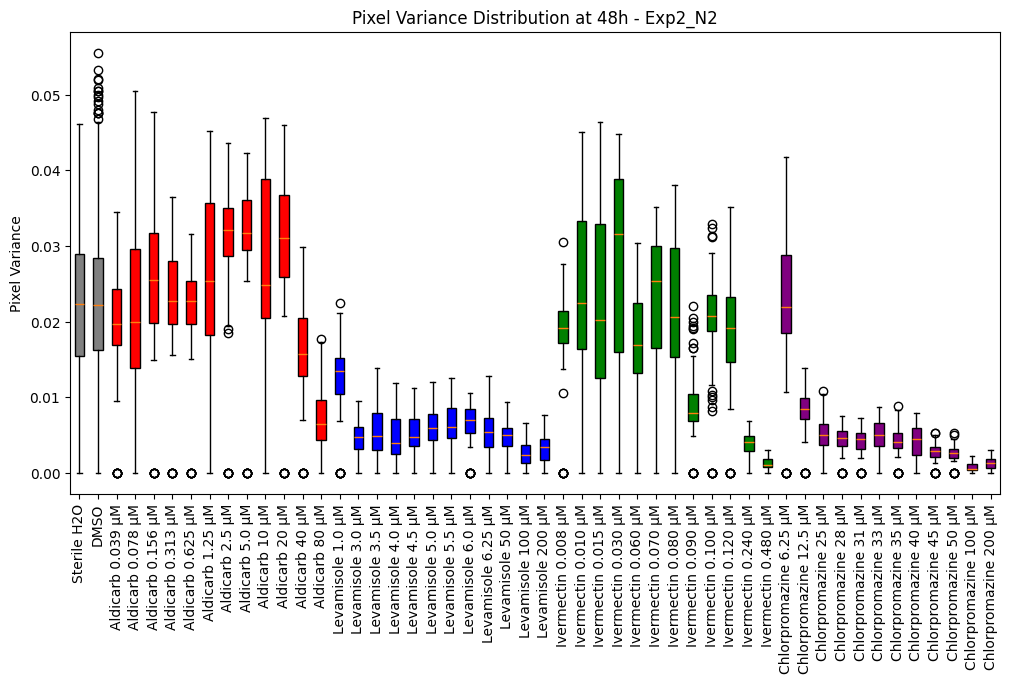

In [7]:
# Plotting the pixel vairance data for 48h plates - Exp2_N2

# Load the data from the .npy file
movie_var_data_Exp2N2_48h = np.load('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/video/pre_screen/N2_Exp2/250225_48h/MovieVarData.npy', allow_pickle=True).item()

# Select the data to plot
plates_data = [
    movie_var_data_Exp2N2_48h['plate_2'],
    movie_var_data_Exp2N2_48h['plate_3'],
    movie_var_data_Exp2N2_48h['plate_4'],
    movie_var_data_Exp2N2_48h['plate_5'],
    movie_var_data_Exp2N2_48h['plate_6'],
    movie_var_data_Exp2N2_48h['plate_7'],
    movie_var_data_Exp2N2_48h['plate_8']
]

# Group data by well names across all plates
grouped_data = defaultdict(list)
for plate_data in plates_data:
    for well, values in plate_data.items():
        if well[0] == 'E':
            grouped_data['Sterile H2O'].extend(values)
        elif well[0] == 'F':
            grouped_data['DMSO'].extend(values)
        else:
            grouped_data[well].extend(values)

# Sort the data by well names using natsort
sorted_keys = natsorted(grouped_data.keys())

# Define the custom order for the labels
custom_order = ['Sterile H2O', 'DMSO'] + [key for key in sorted_keys if key not in ['Sterile H2O', 'DMSO']]

# Prepare data for boxplot
data = [grouped_data[key] for key in custom_order]
labels = [key if key in ['Sterile H2O', 'DMSO'] else key for key in custom_order]




# Create a mapping of original labels to custom labels
custom_labels_map = {
    'A1': 'Aldicarb 0.039 µM',
    'A2': 'Aldicarb 0.078 µM',
    'A3': 'Aldicarb 0.156 µM',
    'A4': 'Aldicarb 0.313 µM',
    'A5': 'Aldicarb 0.625 µM',
    'A6': 'Aldicarb 1.25 µM',
    'A7': 'Aldicarb 2.5 µM',
    'A8': 'Aldicarb 5.0 µM',
    'A9': 'Aldicarb 10 µM',
    'A10': 'Aldicarb 20 µM',
    'A11': 'Aldicarb 40 µM',
    'A12': 'Aldicarb 80 µM',
    'B1': 'Levamisole 1.0 µM',
    'B2': 'Levamisole 3.0 µM',
    'B3': 'Levamisole 3.5 µM',
    'B4': 'Levamisole 4.0 µM',
    'B5': 'Levamisole 4.5 µM',
    'B6': 'Levamisole 5.0 µM',
    'B7': 'Levamisole 5.5 µM',
    'B8': 'Levamisole 6.0 µM',
    'B9': 'Levamisole 6.25 µM',
    'B10': 'Levamisole 50 µM',
    'B11': 'Levamisole 100 µM',
    'B12': 'Levamisole 200 µM',
    'C1': 'Ivermectin 0.008 µM',
    'C2': 'Ivermectin 0.010 µM',
    'C3': 'Ivermectin 0.015 µM',
    'C4': 'Ivermectin 0.030 µM',
    'C5': 'Ivermectin 0.060 µM',
    'C6': 'Ivermectin 0.070 µM',
    'C7': 'Ivermectin 0.080 µM',
    'C8': 'Ivermectin 0.090 µM',
    'C9': 'Ivermectin 0.100 µM',
    'C10': 'Ivermectin 0.120 µM',
    'C11': 'Ivermectin 0.240 µM',
    'C12': 'Ivermectin 0.480 µM',
    'D1': 'Chlorpromazine 6.25 µM',
    'D2': 'Chlorpromazine 12.5 µM',
    'D3': 'Chlorpromazine 25 µM',
    'D4': 'Chlorpromazine 28 µM',
    'D5': 'Chlorpromazine 31 µM',
    'D6': 'Chlorpromazine 33 µM',
    'D7': 'Chlorpromazine 35 µM',
    'D8': 'Chlorpromazine 40 µM',
    'D9': 'Chlorpromazine 45 µM',
    'D10': 'Chlorpromazine 50 µM',
    'D11': 'Chlorpromazine 100 µM',
    'D12': 'Chlorpromazine 200 µM',
    'Sterile H2O': 'Sterile H2O',
    'DMSO': 'DMSO'
    #'E1 & E2 & E3 & E4 & E5 & E6 & E7 & E8 & E9 & E10 & E11 & E12': 'Sterile H2O',
    #'F1 & F2 & F3 & F4 & F5 & F6 & F7 & F8 & F9 & F10 & F11 & F12': 'DMSO',
    # Add more mappings as needed
}


# Define color map for each well name letter
color_map = {
    'A': 'red',
    'B': 'blue',
    'C': 'green',
    'D': 'purple'
}

# Create the boxplot
plt.figure(figsize=(12, 6))
boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)

# Color the boxplots
for patch, label in zip(boxplot['boxes'], labels):
    if label == 'Sterile H2O':
        patch.set_facecolor('gray')
    elif label == 'DMSO':
        patch.set_facecolor('gray')
    else:
        well_letter = label[0]
        patch.set_facecolor(color_map.get(well_letter, 'gray'))
# Add labels and title
plt.xlabel('')
plt.ylabel('Pixel Variance')
plt.title('Pixel Variance Distribution at 48h - Exp2_N2')

# Change x-axis label orientation
plt.xticks(rotation=90)

# Save the plot
plt.savefig('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/pre_screen/Exp2_N2/250225_48h/pixel_variance_Exp2_N2_48h.png', dpi=300, format='png', bbox_inches='tight')


# Show the plot
plt.show()

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_43419/2408080930.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)


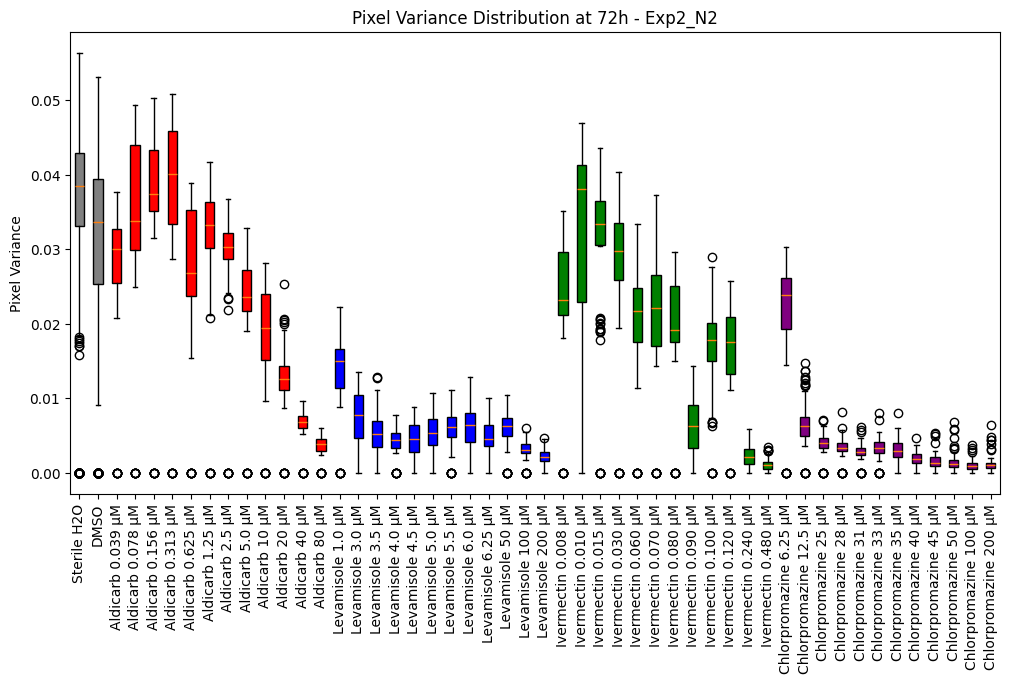

In [8]:
# Plotting the pixel vairance data for 72h plates - Exp2_N2

# Load the data from the .npy file
movie_var_data_Exp2N2_72h = np.load('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/video/pre_screen/N2_Exp2/250226_72h/MovieVarData.npy', allow_pickle=True).item()

# Select the data to plot
plates_data = [
    movie_var_data_Exp2N2_72h['plate_2'],
    movie_var_data_Exp2N2_72h['plate_3'],
    movie_var_data_Exp2N2_72h['plate_4'],
    movie_var_data_Exp2N2_72h['plate_5'],
    movie_var_data_Exp2N2_72h['plate_6'],
    movie_var_data_Exp2N2_72h['plate_7'],
    movie_var_data_Exp2N2_72h['plate_8']
]

# Group data by well names across all plates
grouped_data = defaultdict(list)
for plate_data in plates_data:
    for well, values in plate_data.items():
        if well[0] == 'E':
            grouped_data['Sterile H2O'].extend(values)
        elif well[0] == 'F':
            grouped_data['DMSO'].extend(values)
        else:
            grouped_data[well].extend(values)

# Sort the data by well names using natsort
sorted_keys = natsorted(grouped_data.keys())

# Define the custom order for the labels
custom_order = ['Sterile H2O', 'DMSO'] + [key for key in sorted_keys if key not in ['Sterile H2O', 'DMSO']]

# Prepare data for boxplot
data = [grouped_data[key] for key in custom_order]
labels = [key if key in ['Sterile H2O', 'DMSO'] else key for key in custom_order]






# Create a mapping of original labels to custom labels
custom_labels_map = {
    'A1': 'Aldicarb 0.039 µM',
    'A2': 'Aldicarb 0.078 µM',
    'A3': 'Aldicarb 0.156 µM',
    'A4': 'Aldicarb 0.313 µM',
    'A5': 'Aldicarb 0.625 µM',
    'A6': 'Aldicarb 1.25 µM',
    'A7': 'Aldicarb 2.5 µM',
    'A8': 'Aldicarb 5.0 µM',
    'A9': 'Aldicarb 10 µM',
    'A10': 'Aldicarb 20 µM',
    'A11': 'Aldicarb 40 µM',
    'A12': 'Aldicarb 80 µM',
    'B1': 'Levamisole 1.0 µM',
    'B2': 'Levamisole 3.0 µM',
    'B3': 'Levamisole 3.5 µM',
    'B4': 'Levamisole 4.0 µM',
    'B5': 'Levamisole 4.5 µM',
    'B6': 'Levamisole 5.0 µM',
    'B7': 'Levamisole 5.5 µM',
    'B8': 'Levamisole 6.0 µM',
    'B9': 'Levamisole 6.25 µM',
    'B10': 'Levamisole 50 µM',
    'B11': 'Levamisole 100 µM',
    'B12': 'Levamisole 200 µM',
    'C1': 'Ivermectin 0.008 µM',
    'C2': 'Ivermectin 0.010 µM',
    'C3': 'Ivermectin 0.015 µM',
    'C4': 'Ivermectin 0.030 µM',
    'C5': 'Ivermectin 0.060 µM',
    'C6': 'Ivermectin 0.070 µM',
    'C7': 'Ivermectin 0.080 µM',
    'C8': 'Ivermectin 0.090 µM',
    'C9': 'Ivermectin 0.100 µM',
    'C10': 'Ivermectin 0.120 µM',
    'C11': 'Ivermectin 0.240 µM',
    'C12': 'Ivermectin 0.480 µM',
    'D1': 'Chlorpromazine 6.25 µM',
    'D2': 'Chlorpromazine 12.5 µM',
    'D3': 'Chlorpromazine 25 µM',
    'D4': 'Chlorpromazine 28 µM',
    'D5': 'Chlorpromazine 31 µM',
    'D6': 'Chlorpromazine 33 µM',
    'D7': 'Chlorpromazine 35 µM',
    'D8': 'Chlorpromazine 40 µM',
    'D9': 'Chlorpromazine 45 µM',
    'D10': 'Chlorpromazine 50 µM',
    'D11': 'Chlorpromazine 100 µM',
    'D12': 'Chlorpromazine 200 µM',
    'Sterile H2O': 'Sterile H2O',
    'DMSO': 'DMSO'
    #'E1 & E2 & E3 & E4 & E5 & E6 & E7 & E8 & E9 & E10 & E11 & E12': 'Sterile H2O',
    #'F1 & F2 & F3 & F4 & F5 & F6 & F7 & F8 & F9 & F10 & F11 & F12': 'DMSO',
    # Add more mappings as needed
}


# Define color map for each well name letter
color_map = {
    'A': 'red',
    'B': 'blue',
    'C': 'green',
    'D': 'purple'
}

# Create the boxplot
plt.figure(figsize=(12, 6))
boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)

# Color the boxplots
for patch, label in zip(boxplot['boxes'], labels):
    if label == 'Sterile H2O':
        patch.set_facecolor('gray')
    elif label == 'DMSO':
        patch.set_facecolor('gray')
    else:
        well_letter = label[0]
        patch.set_facecolor(color_map.get(well_letter, 'gray'))
# Add labels and title
plt.xlabel('')
plt.ylabel('Pixel Variance')
plt.title('Pixel Variance Distribution at 72h - Exp2_N2')

# Change x-axis label orientation
plt.xticks(rotation=90)

# Save the plot
plt.savefig('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/pre_screen/Exp2_N2/250226_72h/pixel_variance_Exp2_N2_72h.png', dpi=300, format='png', bbox_inches='tight')


# Show the plot
plt.show()

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_43419/2083957861.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)


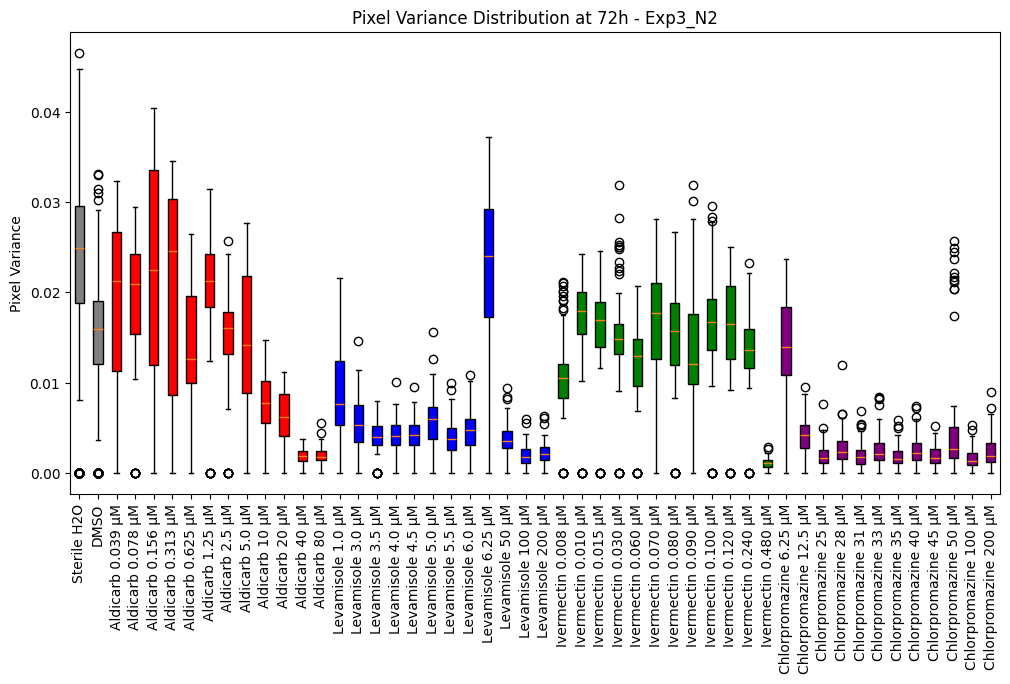

In [9]:
# Plotting the pixel vairance data for 72h plates - Exp3_N2

# Load the data from the .npy file
movie_var_data_Exp2N3_72h = np.load('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/video/pre_screen/N2_Exp3/250307_72h/MovieVarData.npy', allow_pickle=True).item()

# Select the data to plot
plates_data = [
    movie_var_data_Exp2N3_72h['plate_1'],
    movie_var_data_Exp2N3_72h['plate_2'],
    movie_var_data_Exp2N3_72h['plate_3'],
    movie_var_data_Exp2N3_72h['plate_4'],
    movie_var_data_Exp2N3_72h['plate_5'],
    movie_var_data_Exp2N3_72h['plate_6'],
    movie_var_data_Exp2N3_72h['plate_7']
]

# Group data by well names across all plates
grouped_data = defaultdict(list)
for plate_data in plates_data:
    for well, values in plate_data.items():
        if well[0] == 'E':
            grouped_data['Sterile H2O'].extend(values)
        elif well[0] == 'F':
            grouped_data['DMSO'].extend(values)
        else:
            grouped_data[well].extend(values)

# Sort the data by well names using natsort
sorted_keys = natsorted(grouped_data.keys())

# Define the custom order for the labels
custom_order = ['Sterile H2O', 'DMSO'] + [key for key in sorted_keys if key not in ['Sterile H2O', 'DMSO']]

# Prepare data for boxplot
data = [grouped_data[key] for key in custom_order]
labels = [key if key in ['Sterile H2O', 'DMSO'] else key for key in custom_order]


# Create a mapping of original labels to custom labels
custom_labels_map = {
    'A1': 'Aldicarb 0.039 µM',
    'A2': 'Aldicarb 0.078 µM',
    'A3': 'Aldicarb 0.156 µM',
    'A4': 'Aldicarb 0.313 µM',
    'A5': 'Aldicarb 0.625 µM',
    'A6': 'Aldicarb 1.25 µM',
    'A7': 'Aldicarb 2.5 µM',
    'A8': 'Aldicarb 5.0 µM',
    'A9': 'Aldicarb 10 µM',
    'A10': 'Aldicarb 20 µM',
    'A11': 'Aldicarb 40 µM',
    'A12': 'Aldicarb 80 µM',
    'B1': 'Levamisole 1.0 µM',
    'B2': 'Levamisole 3.0 µM',
    'B3': 'Levamisole 3.5 µM',
    'B4': 'Levamisole 4.0 µM',
    'B5': 'Levamisole 4.5 µM',
    'B6': 'Levamisole 5.0 µM',
    'B7': 'Levamisole 5.5 µM',
    'B8': 'Levamisole 6.0 µM',
    'B9': 'Levamisole 6.25 µM',
    'B10': 'Levamisole 50 µM',
    'B11': 'Levamisole 100 µM',
    'B12': 'Levamisole 200 µM',
    'C1': 'Ivermectin 0.008 µM',
    'C2': 'Ivermectin 0.010 µM',
    'C3': 'Ivermectin 0.015 µM',
    'C4': 'Ivermectin 0.030 µM',
    'C5': 'Ivermectin 0.060 µM',
    'C6': 'Ivermectin 0.070 µM',
    'C7': 'Ivermectin 0.080 µM',
    'C8': 'Ivermectin 0.090 µM',
    'C9': 'Ivermectin 0.100 µM',
    'C10': 'Ivermectin 0.120 µM',
    'C11': 'Ivermectin 0.240 µM',
    'C12': 'Ivermectin 0.480 µM',
    'D1': 'Chlorpromazine 6.25 µM',
    'D2': 'Chlorpromazine 12.5 µM',
    'D3': 'Chlorpromazine 25 µM',
    'D4': 'Chlorpromazine 28 µM',
    'D5': 'Chlorpromazine 31 µM',
    'D6': 'Chlorpromazine 33 µM',
    'D7': 'Chlorpromazine 35 µM',
    'D8': 'Chlorpromazine 40 µM',
    'D9': 'Chlorpromazine 45 µM',
    'D10': 'Chlorpromazine 50 µM',
    'D11': 'Chlorpromazine 100 µM',
    'D12': 'Chlorpromazine 200 µM',
    'Sterile H2O': 'Sterile H2O',
    'DMSO': 'DMSO'
    #'E1 & E2 & E3 & E4 & E5 & E6 & E7 & E8 & E9 & E10 & E11 & E12': 'Sterile H2O',
    #'F1 & F2 & F3 & F4 & F5 & F6 & F7 & F8 & F9 & F10 & F11 & F12': 'DMSO',
    # Add more mappings as needed
}


# Define color map for each well name letter
color_map = {
    'A': 'red',
    'B': 'blue',
    'C': 'green',
    'D': 'purple'
}

# Create the boxplot
plt.figure(figsize=(12, 6))
boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)

# Color the boxplots
for patch, label in zip(boxplot['boxes'], labels):
    if label == 'Sterile H2O':
        patch.set_facecolor('gray')
    elif label == 'DMSO':
        patch.set_facecolor('gray')
    else:
        well_letter = label[0]
        patch.set_facecolor(color_map.get(well_letter, 'gray'))
# Add labels and title
plt.xlabel('')
plt.ylabel('Pixel Variance')
plt.title('Pixel Variance Distribution at 72h - Exp3_N2')

# Change x-axis label orientation
plt.xticks(rotation=90)

# Save the plot
plt.savefig('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/pre_screen/Exp3_N2/250307_72h/pixel_variance_Exp3_N2_72h.png', dpi=300, format='png', bbox_inches='tight')


# Show the plot
plt.show()

### Combined Exp2 and Exp3

In [24]:
averaged_data

{'A1': 0.02029143120057188,
 'A10': 0.006850029820795083,
 'A11': 0.0024783315086529833,
 'A12': 0.0021660206789170266,
 'A2': 0.02088487538583599,
 'A3': 0.022952803272430006,
 'A4': 0.020704464424595847,
 'A5': 0.015068971648701962,
 'A6': 0.021660584904319536,
 'A7': 0.016395130339392727,
 'A8': 0.015410143544246644,
 'A9': 0.009369784546192979,
 'B1': 0.00929256693185972,
 'B10': 0.00410726981238347,
 'B11': 0.002075890199895513,
 'B12': 0.0022475117828089277,
 'B2': 0.005743112389151945,
 'B3': 0.003941982551363053,
 'B4': 0.004185776632200696,
 'B5': 0.004079262411746075,
 'B6': 0.005554193773686136,
 'B7': 0.004221969420470894,
 'B8': 0.004820440333199332,
 'B9': 0.020514400777395914,
 'C1': 0.012826194013665753,
 'C10': 0.015441480627510435,
 'C11': 0.011738672495557623,
 'C12': 0.0012604854572013035,
 'C2': 0.017123047418799338,
 'C3': 0.01777869054032422,
 'C4': 0.016292457705248342,
 'C5': 0.012735945707069263,
 'C6': 0.016350615035950977,
 'C7': 0.014919466220731462,
 'C8':

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_43419/3353845801.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)


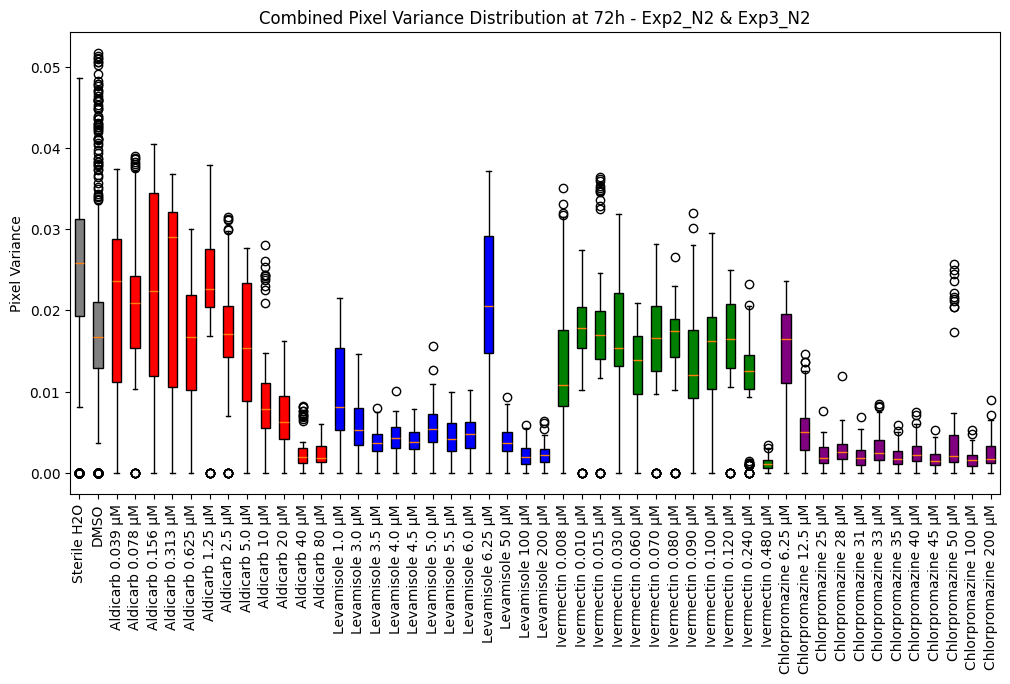

In [11]:
# Exp2_N2 & Exp3_N2 72h data combined

# Load the data from the .npy files
movie_var_data_Exp2N2_72h = np.load('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/video/pre_screen/N2_Exp2/250226_72h/MovieVarData.npy', allow_pickle=True).item()
movie_var_data_Exp3N2_72h = np.load('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/video/pre_screen/N2_Exp3/250307_72h/MovieVarData.npy', allow_pickle=True).item()

# Combine the data from both datasets
combined_data = {}
for key in movie_var_data_Exp2N2_72h.keys():
    combined_data[key] = {**movie_var_data_Exp2N2_72h[key], **movie_var_data_Exp3N2_72h.get(key, {})}

# Select the data to plot
plates_data = [
    combined_data.get('plate_1', {}),
    combined_data.get('plate_2', {}),
    combined_data.get('plate_3', {}),
    combined_data.get('plate_4', {}),
    combined_data.get('plate_5', {}),
    combined_data.get('plate_6', {}),
    combined_data.get('plate_7', {}),
    combined_data.get('plate_8', {})  # Handle missing plate_8
]

# Group data by well names across all plates
grouped_data = defaultdict(list)
for plate_data in plates_data:
    for well, values in plate_data.items():
        if well[0] == 'E':
            grouped_data['Sterile H2O'].extend(values)
        elif well[0] == 'F':
            grouped_data['DMSO'].extend(values)
        else:
            grouped_data[well].extend(values)

# Sort the data by well names using natsort
sorted_keys = natsorted(grouped_data.keys())

# Define the custom order for the labels
custom_order = ['Sterile H2O', 'DMSO'] + [key for key in sorted_keys if key not in ['Sterile H2O', 'DMSO']]

# Prepare data for boxplot
data = [grouped_data[key] for key in custom_order]
labels = [key if key in ['Sterile H2O', 'DMSO'] else key for key in custom_order]

# Create a mapping of original labels to custom labels
custom_labels_map = {
    'A1': 'Aldicarb 0.039 µM',
    'A2': 'Aldicarb 0.078 µM',
    'A3': 'Aldicarb 0.156 µM',
    'A4': 'Aldicarb 0.313 µM',
    'A5': 'Aldicarb 0.625 µM',
    'A6': 'Aldicarb 1.25 µM',
    'A7': 'Aldicarb 2.5 µM',
    'A8': 'Aldicarb 5.0 µM',
    'A9': 'Aldicarb 10 µM',
    'A10': 'Aldicarb 20 µM',
    'A11': 'Aldicarb 40 µM',
    'A12': 'Aldicarb 80 µM',
    'B1': 'Levamisole 1.0 µM',
    'B2': 'Levamisole 3.0 µM',
    'B3': 'Levamisole 3.5 µM',
    'B4': 'Levamisole 4.0 µM',
    'B5': 'Levamisole 4.5 µM',
    'B6': 'Levamisole 5.0 µM',
    'B7': 'Levamisole 5.5 µM',
    'B8': 'Levamisole 6.0 µM',
    'B9': 'Levamisole 6.25 µM',
    'B10': 'Levamisole 50 µM',
    'B11': 'Levamisole 100 µM',
    'B12': 'Levamisole 200 µM',
    'C1': 'Ivermectin 0.008 µM',
    'C2': 'Ivermectin 0.010 µM',
    'C3': 'Ivermectin 0.015 µM',
    'C4': 'Ivermectin 0.030 µM',
    'C5': 'Ivermectin 0.060 µM',
    'C6': 'Ivermectin 0.070 µM',
    'C7': 'Ivermectin 0.080 µM',
    'C8': 'Ivermectin 0.090 µM',
    'C9': 'Ivermectin 0.100 µM',
    'C10': 'Ivermectin 0.120 µM',
    'C11': 'Ivermectin 0.240 µM',
    'C12': 'Ivermectin 0.480 µM',
    'D1': 'Chlorpromazine 6.25 µM',
    'D2': 'Chlorpromazine 12.5 µM',
    'D3': 'Chlorpromazine 25 µM',
    'D4': 'Chlorpromazine 28 µM',
    'D5': 'Chlorpromazine 31 µM',
    'D6': 'Chlorpromazine 33 µM',
    'D7': 'Chlorpromazine 35 µM',
    'D8': 'Chlorpromazine 40 µM',
    'D9': 'Chlorpromazine 45 µM',
    'D10': 'Chlorpromazine 50 µM',
    'D11': 'Chlorpromazine 100 µM',
    'D12': 'Chlorpromazine 200 µM',
    'Sterile H2O': 'Sterile H2O',
    'DMSO': 'DMSO'
    # Add more mappings as needed
}

# Define color map for each well name letter
color_map = {
    'A': 'red',
    'B': 'blue',
    'C': 'green',
    'D': 'purple'
}

# Create the boxplot
plt.figure(figsize=(12, 6))
boxplot = plt.boxplot(data, labels=[custom_labels_map.get(label, label) for label in labels], patch_artist=True)

# Color the boxplots
for patch, label in zip(boxplot['boxes'], labels):
    if label == 'Sterile H2O':
        patch.set_facecolor('gray')
    elif label == 'DMSO':
        patch.set_facecolor('gray')
    else:
        well_letter = label[0]
        patch.set_facecolor(color_map.get(well_letter, 'gray'))

# Add labels and title
plt.xlabel('')
plt.ylabel('Pixel Variance')
plt.title('Combined Pixel Variance Distribution at 72h - Exp2_N2 & Exp3_N2')

# Change x-axis label orientation
plt.xticks(rotation=90)

# Save the plot
plt.savefig('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/pre_screen/combined_Exp2_and_Exp3/pixel_variance_Exp2_Exp3_72h.png', dpi=300, format='png', bbox_inches='tight')


plt.show()

## NHR mutant screen

### Overall Directories

In [3]:
AUX_FILES = Path('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Auxiliary_files/')
DATA_PATH = Path('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/video/mutant_screen')
SAVE_FIG_DIR = Path('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen')

### Process the aux files and the numpy arrays with the pixel variance data

In [3]:
# Process the aux files and the data numpy arrays for each batch

def process_files(aux_path, data_path):
    # Read in the auxiliary files
    drugs = pd.read_csv(aux_path / 'drug_concentration.csv')
    plate_to_strain = pd.read_csv(aux_path / 'plate_to_strain.csv')

    # Convert 'FALSE' and 'TRUE' to booleans in 'keep' column
    plate_to_strain['keep'] = plate_to_strain['keep'].replace({'FALSE': False, 'TRUE': True}).astype(bool)
    drugs['keep'] = drugs['keep'].replace({'FALSE': False, 'TRUE': True}).astype(bool)

    # Filter out rows where 'keep' is False
    plate_to_strain = plate_to_strain[plate_to_strain['keep']]
    drugs = drugs[drugs['keep']]

    # Read in the numpy array for the pixel variance data
    movie_var_data = np.load(data_path / 'MovieVarData.npy', allow_pickle=True).item()

    return drugs, plate_to_strain, movie_var_data

# Batch 1
aux_path_250314 = Path(AUX_FILES) / '20250314'
data_path_250314 = Path(DATA_PATH) / '20250314'
drugs_250314, plate_to_strain_250314, movie_var_data_250314 = process_files(aux_path_250314, data_path_250314)

# Batch 2
aux_path_250321 = Path(AUX_FILES) / '20250321'
data_path_250321 = Path(DATA_PATH) / '20250321'
drugs_250321, plate_to_strain_250321, movie_var_data_250321 = process_files(aux_path_250321, data_path_250321)

# Batch 3
aux_path_250328 = Path(AUX_FILES) / '20250328'
data_path_250328 = Path(DATA_PATH) / '20250328'
drugs_250328, plate_to_strain_250328, movie_var_data_250328 = process_files(aux_path_250328, data_path_250328)

# Batch 4
aux_path_250401 = Path(AUX_FILES) / '20250401'
data_path_250401 = Path(DATA_PATH) / '20250401'
drugs_250401, plate_to_strain_250401, movie_var_data_250401 = process_files(aux_path_250401, data_path_250401)



In [4]:
print(plate_to_strain_250314['keep'].value_counts())
print(plate_to_strain_250321['keep'].value_counts())
print(plate_to_strain_250328['keep'].value_counts())
print(plate_to_strain_250401['keep'].value_counts())

keep
True    24
Name: count, dtype: int64
keep
True    23
Name: count, dtype: int64
keep
True    25
Name: count, dtype: int64
keep
True    37
Name: count, dtype: int64


In [5]:
# Convert the numpy arrays to dataframes and average the pixel variance values for each well across all timepoints (not averaging the replicate wells)

def process_movie_var_data(movie_var_data, drugs_data, plate_to_strain_data, aux_path):
    # Extract the date from the folder name in the aux_path
    date_str = os.path.basename(aux_path)
    date_yyyymmdd = pd.to_datetime(date_str, format='%Y%m%d').strftime('%Y-%m-%d')

    # Convert the nested dictionary to a DataFrame
    data = []
    for plate, wells in movie_var_data.items():
        for well, values in wells.items():
            for i, value in enumerate(values):
                data.append({'plate': plate, 'well': well, 'timepoint': i, 'value': value})

    df = pd.DataFrame(data)

    # Remove the rows with Timepoint '0' as they are only used to calculate the difference in pixel variance between the timepoints, and so should not be plotted
    df = df[df['timepoint'] != 0]

    # Merge the DataFrame with the plate_to_strain DataFrame and the drugs DataFrame
    df = pd.merge(df, drugs_data, on='well')
    df = pd.merge(df, plate_to_strain_data, on='plate')

    # Average the pixel variance values for each well across all timepoints
    df_averaged = df.groupby(['plate', 'well', 'drug', 'concentration', 'strain', 'full_genotype'])['value'].mean().reset_index()

    # Add the date_yyyymmdd column
    df_averaged['date_yyyymmdd'] = date_yyyymmdd

    return df_averaged

df_250314_averaged = process_movie_var_data(movie_var_data_250314, drugs_250314, plate_to_strain_250314, aux_path_250314)
df_250321_averaged = process_movie_var_data(movie_var_data_250321, drugs_250321, plate_to_strain_250321, aux_path_250321)
df_250328_averaged = process_movie_var_data(movie_var_data_250328, drugs_250328, plate_to_strain_250328, aux_path_250328)
df_250401_averaged = process_movie_var_data(movie_var_data_250401, drugs_250401, plate_to_strain_250401, aux_path_250401)

# Display the dataframes
print(df_250314_averaged)
print(df_250321_averaged)
print(df_250328_averaged)
print(df_250401_averaged)

all_data_df = pd.concat([df_250314_averaged, df_250321_averaged, df_250328_averaged, df_250401_averaged], ignore_index=True)

all_data_df.to_csv('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/data/batch1_batch2_batch3_batch4_data.csv', index=False)



        plate well      drug  concentration        strain  \
0     plate_1   A1  Aldicarb            2.5  CHS10799_GUM   
1     plate_1  A10  Aldicarb            7.5  CHS10799_GUM   
2     plate_1  A11  Aldicarb           20.0  CHS10799_GUM   
3     plate_1  A12  Aldicarb           80.0  CHS10799_GUM   
4     plate_1   A2  Aldicarb            7.5  CHS10799_GUM   
...       ...  ...       ...            ...           ...   
1723  plate_9   F5      DMSO            0.0  CHS11227_LKG   
1724  plate_9   F6      DMSO            0.0  CHS11227_LKG   
1725  plate_9   F7      DMSO            0.0  CHS11227_LKG   
1726  plate_9   F8      DMSO            0.0  CHS11227_LKG   
1727  plate_9   F9      DMSO            0.0  CHS11227_LKG   

                full_genotype     value date_yyyymmdd  
0              nhr-89;nhr-242  0.045773    2025-03-14  
1              nhr-89;nhr-242  0.037257    2025-03-14  
2              nhr-89;nhr-242  0.015955    2025-03-14  
3              nhr-89;nhr-242  0.007824    

### Normalise the pixel variance 

In [8]:
# Normalising the pixel variance


control_wells = {
    'Aldicarb': 'S.H2O',
    'Levamisole': 'S.H2O',
    'Chlorpromazine': 'S.H2O',
    'Ivermectin': 'DMSO',
    'S.H2O': 'S.H2O',
    'DMSO': 'DMSO'
}
df_norm = all_data_df.copy()

df_norm['control'] = df_norm['drug'].map(control_wells)


# Calculate mean pixel variance for control wells
control_values = {}
for date in df_norm['date_yyyymmdd'].unique():
    control_values[date] = {}
    for strain in df_norm['strain'].unique():
        control_values[date][strain] = {
            'S.H2O': df_norm[(df_norm['date_yyyymmdd'] == date) & 
                             (df_norm['strain'] == strain) & 
                             (df_norm['drug'] == 'S.H2O')]['value'].mean(),
            'DMSO': df_norm[(df_norm['date_yyyymmdd'] == date) & 
                            (df_norm['strain'] == strain) & 
                            (df_norm['drug'] == 'DMSO')]['value'].mean()
        }

# Function to normalize values using relative change
def normalize_value(row):
    date = row['date_yyyymmdd']
    strain = row['strain']
    if row['drug'] in ['Aldicarb', 'Levamisole', 'Chlorpromazine']:
        control_value = control_values[date][strain]['S.H2O']
    elif row['drug'] == 'Ivermectin':
        control_value = control_values[date][strain]['DMSO']
    else:
        control_value = row['value']  # Use the original value if no control is found
    return (row['value']) / control_value



df_norm['normalized_value'] = df_norm.apply(normalize_value, axis=1)

# Display normalised DataFrame
print(df_norm)

# Save the normalised DataFrame to a CSV file
df_norm.to_csv('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/data/batch1_batch2_batch3_batch4_data_normalised.csv', index=False)

        plate well      drug  concentration        strain  \
0     plate_1   A1  Aldicarb            2.5  CHS10799_GUM   
1     plate_1  A10  Aldicarb            7.5  CHS10799_GUM   
2     plate_1  A11  Aldicarb           20.0  CHS10799_GUM   
3     plate_1  A12  Aldicarb           80.0  CHS10799_GUM   
4     plate_1   A2  Aldicarb            7.5  CHS10799_GUM   
...       ...  ...       ...            ...           ...   
7119  plate_9   F5      DMSO            0.0  CHS10778_HBD   
7120  plate_9   F6      DMSO            0.0  CHS10778_HBD   
7121  plate_9   F7      DMSO            0.0  CHS10778_HBD   
7122  plate_9   F8      DMSO            0.0  CHS10778_HBD   
7123  plate_9   F9      DMSO            0.0  CHS10778_HBD   

                         full_genotype     value date_yyyymmdd control  \
0                       nhr-89;nhr-242  0.045773    2025-03-14   S.H2O   
1                       nhr-89;nhr-242  0.037257    2025-03-14   S.H2O   
2                       nhr-89;nhr-242  0.015

# Plot the data

In [4]:
# Set which plots to print

by_strain = False
by_drug = False

by_strain_norm = False
by_drug_norm = False
heatmap_norm = False
pivoted_heatmap_norm = True


# Read in the dataframes

# Pre-normalised data
all_data_df = pd.read_csv('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/data/batch1_batch2_batch3_batch4_data.csv')
#all_data_df = pd.read_csv('/Users/jb3623/Documents/250511_Analysis/NHR_drugs/batch1_batch2_batch3_batch4_data.csv')

# Normalised data
df_norm = pd.read_csv('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/data/batch1_batch2_batch3_batch4_data_normalised.csv')
#df_norm = pd.read_csv('/Users/jb3623/Documents/250511_Analysis/NHR_drugs/batch1_batch2_batch3_batch4_data_normalised.csv')

In [37]:
# Plotting dependent on the selected plots in the above code block

# Define color map for each drug
color_map = {
    'Aldicarb': 'red',
    'Levamisole': 'blue',
    'Ivermectin': 'green',
    'Chlorpromazine': 'purple',
    'S.H2O': 'gray',
    'DMSO': 'gray'
}

# Function to create a directory if it doesn't exist
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Function to map drug names to colors
def get_color(drug_concentration):
    drug = drug_concentration.split()[0]
    return color_map.get(drug, 'black')

# Function to create a color palette for the stripplot based on unique dates
def create_date_color_palette(dates):
    unique_dates = dates.unique()
    if len(unique_dates) == 1:
        return {unique_dates[0]: 'black'}
    else:
        palette = sns.color_palette("colorblind", len(unique_dates))
        return dict(zip(unique_dates, palette))

# Plot the pixel variance data for each strain (All imaging days for N2 combined)
# Plot all drugs and concentrations in one plot per strain
if by_strain == True:
    strains = all_data_df['strain'].unique()
    for strain in strains:
        plt.figure(figsize=(12, 8))
        
        strain_data = all_data_df[all_data_df['strain'] == strain]
        
        if strain == 'N2':
            # Extract unique dates and create a color palette
            date_palette = create_date_color_palette(strain_data['date_yyyymmdd'])
            
            # Create a combined column for drug and concentration
            strain_data['drug_concentration'] = strain_data['drug'] + ' ' + strain_data['concentration'].astype(str) + 'µM'
            
            # Create a color palette for the drug_concentration column
            unique_drug_concentrations = strain_data['drug_concentration'].unique()
            palette = {dc: get_color(dc) for dc in unique_drug_concentrations}
            
            # Create the boxplot
            boxplot = sns.boxplot(data=strain_data, x='drug_concentration', y='value', palette=palette)
            
            # Create the striplot to show all data points with colors based on date
            striplot = sns.stripplot(data=strain_data, x='drug_concentration', y='value', hue='date_yyyymmdd', palette=date_palette, jitter=True, marker='o', alpha=0.8)
            
            # Plot all values for wells in row E (S.H2O) and row F (DMSO)
            #sh2o_values = all_data_df[(all_data_df['strain'] == strain) & all_data_df['well'].str.startswith('E')]['value']
            #dmso_values = all_data_df[(all_data_df['strain'] == strain) & all_data_df['well'].str.startswith('F')]['value']
            
            # Add labels and title
            plt.xlabel('Drug and Concentration')
            plt.ylabel('Pixel Variation - not normalised')
            plt.title(f"Strain: {strain}")
            
            # Change x-axis label orientation
            plt.xticks(rotation=90)
            plt.legend(title='Date')

            # Save the plot with high DPI
            #strain = plate_data['strain'].iloc[0]  # Assuming 'strain' column exists
            plt.savefig(SAVE_FIG_DIR / 'all' / 'by_strain' / f'{strain}_pixelvariance_all_batches.png', dpi=300, bbox_inches='tight')

            #plt.show()  

        else:
                # Extract unique dates
            unique_dates = strain_data['date_yyyymmdd'].unique()
            
            for date in unique_dates:
                plt.figure(figsize=(12, 8))
                
                date_data = strain_data[strain_data['date_yyyymmdd'] == date]
                
                # Create a combined column for drug and concentration
                date_data['drug_concentration'] = date_data['drug'] + ' ' + date_data['concentration'].astype(str) + 'µM'
                
                # Create a color palette for the drug_concentration column
                unique_drug_concentrations = date_data['drug_concentration'].unique()
                palette = {dc: get_color(dc) for dc in unique_drug_concentrations}
                
                # Create the boxplot
                boxplot = sns.boxplot(data=date_data, x='drug_concentration', y='value', palette=palette)
                
                # Create the striplot to show all data points with colors based on date
                striplot = sns.stripplot(data=date_data, x='drug_concentration', y='value', hue='date_yyyymmdd', palette={date: 'black'}, jitter=True, marker='o', alpha=0.8)
                
                # Add labels and title
                plt.xlabel('Drug and Concentration')
                plt.ylabel('Pixel Variation - not normalised')
                plt.title(f"Strain: {strain}")
                
                # Change x-axis label orientation
                plt.xticks(rotation=90)
                plt.legend(title='Date')

                # Save the plot with high DPI
                date_dir = SAVE_FIG_DIR / 'all' / 'by_strain' / date
                create_directory(date_dir)
                plt.savefig(date_dir / f'{date}_{strain}_pixelvariance.png', dpi=300, bbox_inches='tight')
                #plt.show()

    

# Plot pixel variance data by drug and concentration (All imaging days for N2 combined)
if by_drug == True:
    # Get unique combinations of drug and concentration
    drug_concentrations = all_data_df[['drug', 'concentration']].drop_duplicates()

    # Determine the range of concentrations
    concentration_values = drug_concentrations['concentration'].unique()
    concentration_values_sorted = np.sort(concentration_values)

    # Create a mapping from concentration to alpha value
    alpha_map = {concentration: (i + 1) / len(concentration_values_sorted) for i, concentration in enumerate(concentration_values_sorted)}
    
    # Extract unique dates
    unique_dates = all_data_df['date_yyyymmdd'].unique()
    
    # Plot all strains for each drug and concentration
    for _, row in drug_concentrations.iterrows():
        drug = row['drug']
        concentration = row['concentration']
        for date in unique_dates: # Make plots for each unique date
            plt.figure(figsize=(12, 10))
            plt.title(f"Drug: {drug}, Concentration: {concentration}µM, Date: {date}")
            
            # Filter data for the current drug, concentration, and date
            drug_concentration_data = all_data_df[(all_data_df['drug'] == drug) & 
                                                  (all_data_df['concentration'] == concentration) & 
                                                  (all_data_df['date_yyyymmdd'] == date)]
            
            # Drop rows with NaNs
            drug_concentration_data = drug_concentration_data.dropna()
            
            # Skip if no data is left after dropping NaNs
            if drug_concentration_data.empty:
                print(f"No data for drug: {drug}, concentration: {concentration}, date: {date}, skipping...")
                continue

            # Calculate the mean value for each strain
            strain_means = drug_concentration_data.groupby('strain')['value'].mean()
            
            # Calculate the mean value for N2
            n2_mean = strain_means['N2']
            
            # Calculate the difference to the mean of N2
            strain_diffs = strain_means - n2_mean
            
            # Sort strains based on the difference
            sorted_strains = strain_diffs.abs().sort_values().index.tolist()
            
            # Ensure N2 is the first in the order
            order = ['N2'] + [strain for strain in sorted_strains if strain != 'N2']
            
            # Determine the transparency based on concentration
            alpha = alpha_map[concentration]
            
            # Create the boxplot
            boxplot = sns.boxplot(data=drug_concentration_data, x='strain', y='value', order=order, color=get_color(drug), fliersize=0)
            
            # Set the transparency for the boxplot elements
            for patch in boxplot.patches:
                r, g, b, _ = patch.get_facecolor()
                patch.set_facecolor((r, g, b, alpha))
            
            # Create the striplot to show all data points
            striplot = sns.stripplot(data=drug_concentration_data, x='strain', y='value', color='black', jitter=True, marker='o', alpha=0.5, order=order)
            
            # Add labels and title
            plt.xlabel('Strain, Drug and Concentration')
            plt.ylabel('Pixel Variation - not normalised')

            # Change x-axis label orientation
            plt.xticks(rotation=90)

            plt.ylim(0, 0.1)

            # Format the filename
            drug_formatted = drug.lower().replace(' ', '_')
            concentration_formatted = str(concentration).replace('.', '_')
            filename = f'{drug_formatted}_{concentration_formatted}_pixelvariance.png'
            
            # Save the plot with high DPI
            date_dir = SAVE_FIG_DIR / 'all' / 'by_drug' / date
            create_directory(date_dir)
            plt.savefig(date_dir / filename, dpi=300, bbox_inches='tight')

            #plt.show()
    

    
            # Plot all strains for each drug and concentration with all dates combined
        
        # Filter data for the current drug and concentration across all dates
        drug_concentration_data = all_data_df[(all_data_df['drug'] == drug) & 
                                              (all_data_df['concentration'] == concentration)]

        plt.figure(figsize=(20, 10))
        plt.title(f"Drug: {drug}, Concentration: {concentration}µM (All Dates Combined)")
        
        # Calculate the mean value for each strain
        strain_means = drug_concentration_data.groupby('strain')['value'].mean()
        
        # Calculate the mean value for N2
        n2_mean = strain_means['N2']
            
        # Calculate the difference to the mean of N2
        strain_diffs = strain_means - n2_mean
        
        # Sort strains based on the difference
        sorted_strains = strain_diffs.abs().sort_values().index.tolist()
        
        # Ensure N2 is the first in the order
        order = ['N2'] + [strain for strain in sorted_strains if strain != 'N2']
        
        # Determine the transparency based on concentration
        alpha = alpha_map[concentration]
        
        # Create the boxplot
        boxplot = sns.boxplot(data=drug_concentration_data, x='strain', y='value', order=order, color=get_color(drug), fliersize=0)
        
        # Set the transparency for the boxplot elements
        for patch in boxplot.patches:
            r, g, b, _ = patch.get_facecolor()
            patch.set_facecolor((r, g, b, alpha))
        
        # Create the striplot to show all data points
        striplot = sns.stripplot(data=drug_concentration_data, x='strain', y='value', color='black', jitter=True, marker='o', alpha=0.5, order=order)
        
        # Add labels and title
        plt.xlabel('Strain, Drug and Concentration')
        plt.ylabel('Pixel Variation - not normalised')

        # Change x-axis label orientation
        plt.xticks(rotation=90)

        plt.ylim(0, 0.1)

        # Format the filename
        drug_formatted = drug.lower().replace(' ', '_')
        concentration_formatted = str(concentration).replace('.', '_')
        filename = f'{drug_formatted}_{concentration_formatted}_pixelvariance_all_dates.png'
        
        # Save the plot with high DPI
        save_dir = Path("/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/by_drug/all_dates")
        create_directory(save_dir)
        plt.savefig(save_dir / filename, dpi=300, bbox_inches='tight')

        #plt.show()


# Normalised values


if by_strain_norm == True:
    strains = df_norm['strain'].unique()
    for strain in strains:
        plt.figure(figsize=(12, 8))
        
        strain_data = df_norm[df_norm['strain'] == strain]
        
        if strain == 'N2':
            # Extract unique dates and create a color palette
            date_palette = create_date_color_palette(strain_data['date_yyyymmdd'])
            
            # Create a combined column for drug and concentration
            strain_data['drug_concentration'] = strain_data['drug'] + ' ' + strain_data['concentration'].astype(str) + 'µM'
            
            # Create a color palette for the drug_concentration column
            unique_drug_concentrations = strain_data['drug_concentration'].unique()
            palette = {dc: get_color(dc) for dc in unique_drug_concentrations}
            
            # Create the boxplot
            boxplot = sns.boxplot(data=strain_data, x='drug_concentration', y='normalized_value', palette=palette)
            
            # Create the striplot to show all data points with colors based on date
            striplot = sns.stripplot(data=strain_data, x='drug_concentration', y='normalized_value', hue='date_yyyymmdd', palette=date_palette, jitter=True, marker='o', alpha=0.8)
            
            # Plot all values for wells in row E (S.H2O) and row F (DMSO)
            #sh2o_values = df_norm[(df_norm['strain'] == strain) & df_norm['well'].str.startswith('E')]['normalized_value']
            #dmso_values = df_norm[(df_norm['strain'] == strain) & df_norm['well'].str.startswith('F')]['normalized_value']
            
            # Add labels and title
            plt.xlabel('Drug and Concentration')
            plt.ylabel('Pixel Variation - normalised')
            plt.title(f"Strain: {strain} - normalised")
            
            # Change x-axis label orientation
            plt.xticks(rotation=90)
            plt.legend(title='Date')

            # Save the plot with high DPI
            #strain = plate_data['strain'].iloc[0]  # Assuming 'strain' column exists
            plt.savefig(SAVE_FIG_DIR / 'all' / 'by_strain' / 'normalised' / f'{strain}_pixelvariance_all_batches.png', dpi=300, bbox_inches='tight')

            #plt.show()  

        else:
                # Extract unique dates
            unique_dates = strain_data['date_yyyymmdd'].unique()
            
            for date in unique_dates:
                plt.figure(figsize=(12, 8))
                
                date_data = strain_data[strain_data['date_yyyymmdd'] == date]
                
                # Create a combined column for drug and concentration
                date_data['drug_concentration'] = date_data['drug'] + ' ' + date_data['concentration'].astype(str) + 'µM'
                
                # Create a color palette for the drug_concentration column
                unique_drug_concentrations = date_data['drug_concentration'].unique()
                palette = {dc: get_color(dc) for dc in unique_drug_concentrations}
                
                # Create the boxplot
                boxplot = sns.boxplot(data=date_data, x='drug_concentration', y='normalized_value', palette=palette)
                
                # Create the striplot to show all data points with colors based on date
                striplot = sns.stripplot(data=date_data, x='drug_concentration', y='normalized_value', hue='date_yyyymmdd', palette={date: 'black'}, jitter=True, marker='o', alpha=0.8)
                
                # Add labels and title
                plt.xlabel('Drug and Concentration')
                plt.ylabel('Pixel Variation - normalised')
                plt.title(f"Strain: {strain} - normalised")
                
                # Change x-axis label orientation
                plt.xticks(rotation=90)
                plt.legend(title='Date')

                # Save the plot with high DPI
                #plt.savefig(SAVE_FIG_DIR / 'all' / 'by_strain' / 'normalised' / f'{date}_{strain}_pixelvariance.png', dpi=300, bbox_inches='tight')

                # Save the plot with high DPI
                date_dir = SAVE_FIG_DIR / 'all' / 'by_strain' / 'normalised' / date
                create_directory(date_dir)
                plt.savefig(date_dir / f'{date}_{strain}_pixelvariance.png', dpi=300, bbox_inches='tight')

                #plt.show()




if by_drug_norm == True:
        # Get unique combinations of drug and concentration
    drug_concentrations = df_norm[['drug', 'concentration']].drop_duplicates()

    # Determine the range of concentrations
    concentration_values = drug_concentrations['concentration'].unique()
    concentration_values_sorted = np.sort(concentration_values)

    # Create a mapping from concentration to alpha value
    alpha_map = {concentration: (i + 1) / len(concentration_values_sorted) for i, concentration in enumerate(concentration_values_sorted)}

    # Extract unique dates to plot by drug and concentration, and by day 
    unique_dates = df_norm['date_yyyymmdd'].unique()
    # Plot day by day
    
    for _, row in drug_concentrations.iterrows():
        drug = row['drug']
        concentration = row['concentration']
        for date in unique_dates:
            plt.figure(figsize=(12, 10))
            plt.title(f"Drug: {drug}, Concentration: {concentration}µM")
            
            # Filter data for the current drug, concentration, and date
            drug_concentration_data = df_norm[(df_norm['drug'] == drug) & 
                                                  (df_norm['concentration'] == concentration) & 
                                                  (df_norm['date_yyyymmdd'] == date)]
            
            # Drop rows with NaNs
            drug_concentration_data = drug_concentration_data.dropna()
            
            # Skip if no data is left after dropping NaNs
            if drug_concentration_data.empty:
                print(f"No data for drug: {drug}, concentration: {concentration}, date: {date}, skipping...")
                continue

            # Calculate the mean value for each strain
            strain_means = drug_concentration_data.groupby('strain')['value'].mean()
            
            # Calculate the mean value for N2
            n2_mean = strain_means['N2']
            
            # Calculate the difference to the mean of N2
            strain_diffs = strain_means - n2_mean
            
            # Sort strains based on the difference
            sorted_strains = strain_diffs.abs().sort_values().index.tolist()
            
            # Ensure N2 is the first in the order
            order = ['N2'] + [strain for strain in sorted_strains if strain != 'N2']
            
            # Determine the transparency based on concentration
            alpha = alpha_map[concentration]
            
            # Create the boxplot
            boxplot = sns.boxplot(data=drug_concentration_data, x='strain', y='normalized_value', order=order, color=get_color(drug), fliersize=0)
            
            # Set the transparency for the boxplot elements
            for patch in boxplot.patches:
                r, g, b, _ = patch.get_facecolor()
                patch.set_facecolor((r, g, b, alpha))
            
            # Create the striplot to show all data points
            striplot = sns.stripplot(data=drug_concentration_data, x='strain', y='normalized_value', color='black', jitter=True, marker='o', alpha=0.5, order=order)
            
            # Add labels and title
            plt.xlabel('Strain, Drug and Concentration')
            plt.ylabel('Pixel Variation -  normalised')

            # Change x-axis label orientation
            plt.xticks(rotation=90)

            #plt.ylim(0, 1.4)

            # Format the filename
            drug_formatted = drug.lower().replace(' ', '_')
            concentration_formatted = str(concentration).replace('.', '_')
            filename = f'{drug_formatted}_{concentration_formatted}_pixelvariance.png'
            
            # Save the plot with high DPI
            #plt.savefig(SAVE_FIG_DIR / 'all' / 'by_drug' / 'normalised' / f'{filename}', dpi=300, bbox_inches='tight')

            # Save the plot with high DPI
            for date in drug_concentration_data['date_yyyymmdd'].unique():
                date_dir = SAVE_FIG_DIR / 'all' / 'by_drug' / 'normalised' / date
                create_directory(date_dir)
                plt.savefig(date_dir / filename, dpi=300, bbox_inches='tight')
            #plt.show()

    # Plot all strains together for each drug and concentration       
        # Filter data for the current drug and concentration
        drug_concentration_data = df_norm[(df_norm['drug'] == drug) & 
                                          (df_norm['concentration'] == concentration)]
        
        plt.figure(figsize=(20, 10))
        plt.title(f"Drug: {drug}, Concentration: {concentration}µM")

        # Calculate the mean value for each strain
        strain_means = drug_concentration_data.groupby('strain')['value'].mean()
        
        # Calculate the mean value for N2
        n2_mean = strain_means['N2']
        
        # Calculate the difference to the mean of N2
        strain_diffs = strain_means - n2_mean
        
        # Sort strains based on the difference
        sorted_strains = strain_diffs.abs().sort_values().index.tolist()
        
        # Ensure N2 is the first in the order
        order = ['N2'] + [strain for strain in sorted_strains if strain != 'N2']
        
        # Determine the transparency based on concentration
        alpha = alpha_map[concentration]
        
        # Create the boxplot
        boxplot = sns.boxplot(data=drug_concentration_data, x='strain', y='normalized_value', order=order, color=get_color(drug), fliersize=0)
        
        # Set the transparency for the boxplot elements
        for patch in boxplot.patches:
            r, g, b, _ = patch.get_facecolor()
            patch.set_facecolor((r, g, b, alpha))
        
        # Create the striplot to show all data points
        striplot = sns.stripplot(data=drug_concentration_data, x='strain', y='normalized_value', color='black', jitter=True, marker='o', alpha=0.5, order=order)
        
        # Add labels and title
        plt.xlabel('Strain, Drug and Concentration')
        plt.ylabel('Pixel Variation - normalised')

        # Change x-axis label orientation
        plt.xticks(rotation=90)

        #plt.ylim(0, 1.4)

        # Format the filename
        drug_formatted = drug.lower().replace(' ', '_')
        concentration_formatted = str(concentration).replace('.', '_')
        filename = f'{drug_formatted}_{concentration_formatted}_pixelvariance.png'
        
        # Save the plot with high DPI
        plt.savefig(SAVE_FIG_DIR / 'all' / 'by_drug' / 'normalised' / 'all_dates' / f'{filename}', dpi=300, bbox_inches='tight')



if heatmap_norm == True:

    unique_dates = df_norm['date_yyyymmdd'].unique()

    def plot_heatmap(data, title, filename, figsize=(12, 20)):
        df_pivot_norm_all = data.copy()

        df_pivot_norm_all = df_pivot_norm_all[df_pivot_norm_all['strain'] != 'AE501_shaken']

        df_pivot_norm_all['drug_concentration'] = df_pivot_norm_all['drug'] + ' ' + df_pivot_norm_all['concentration'].astype(str) + 'µM'

        # Pivot the DataFrame
        df_pivot_norm_all = df_pivot_norm_all.pivot_table(index='strain', columns='drug_concentration', values='normalized_value')

        # Flatten the multi-level column index for better readability in the heatmap
        df_pivot_norm_all.columns = [f'{drug_concentration}' for drug_concentration in df_pivot_norm_all.columns]

        # Define the custom order of the drugs
        custom_order = [
            'Aldicarb 2.5µM',
            'Aldicarb 7.5µM',
            'Aldicarb 20.0µM',
            'Aldicarb 80.0µM',
            'Levamisole 0.1µM',
            'Levamisole 0.5µM',
            'Levamisole 2.0µM',
            'Levamisole 4.0µM',
            'Chlorpromazine 3.0µM',
            'Chlorpromazine 7.0µM',
            'Chlorpromazine 10.0µM',
            'Chlorpromazine 30.0µM'
            ]

        # Reorder the columns based on the custom order
        ordered_columns = []
        for drug in custom_order:
            ordered_columns.extend([col for col in df_pivot_norm_all.columns if col.startswith(drug)])
        df_pivot_norm_all = df_pivot_norm_all[ordered_columns]

        # Reorder the rows to place 'N2' at the top and strains with missing values at the bottom
        strains_with_missing_values = df_pivot_norm_all.index[df_pivot_norm_all.isnull().any(axis=1)].tolist()
        strains_with_complete_values = df_pivot_norm_all.index.difference(strains_with_missing_values).tolist()
        
        # Ensure 'N2' is at the top
        if 'N2' in strains_with_complete_values:
            strains_with_complete_values.remove('N2')
            ordered_strains = ['N2'] + strains_with_complete_values + strains_with_missing_values
        else:
            ordered_strains = strains_with_complete_values + strains_with_missing_values

        df_pivot_norm_all = df_pivot_norm_all.loc[ordered_strains]

        colors = [(0, 'blue'), (1, 'white')]
        custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

        # Create a heatmap
        plt.figure(figsize=figsize)
        ax = sns.heatmap(
            df_pivot_norm_all, 
            cmap=custom_cmap, 
            annot=False, # Change to False if you don't want annotations
            fmt=".2f", 
            linewidths=.5, 
            vmin=0, 
            vmax=1, 
            cbar=False
            )

        # Customize the plot
        plt.title(title, fontsize=24)
        plt.xlabel('Drugs and Concentrations', fontsize=20)
        plt.ylabel('')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        
        # Draw vertical lines after every four drugs
        drug_names = df_pivot_norm_all.columns
        drug_groups = [drug_names[i:i+4] for i in range(0, len(drug_names), 4)]  # Group drugs into chunks of 4

        for group in drug_groups[:-1]:  # Skip the last group
            last_col_index = df_pivot_norm_all.columns.get_loc(group[-1])  # Get the index of the last drug in the group
            ax.axvline(x=last_col_index + 1, color='black', linewidth=2)

        # Show the plot
        plt.tight_layout()
        plt.savefig(filename, dpi=600, bbox_inches='tight')
        #plt.show()

        # Create a color bar for the heatmap
        fig, ax = plt.subplots(figsize=(1, 5))
        cmap = custom_cmap
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
        cb1.set_label('Normalised Pixel Variation\nhigh to low ', rotation=270, labelpad=20)
        cb1.set_ticks([0, 1])
        cb1.set_ticklabels(['0', '1'])

        # Save the color bar
        fig.savefig(filename.parent / f'colorbar_{filename.stem}.png', dpi=600, bbox_inches='tight')
        #plt.show()

    # Plot for all data
    plot_heatmap(df_norm, 'All Strains - Normalised Pixel Variation to Drug Control', SAVE_FIG_DIR / 'pixel_variance' / 'all' / 'heatmap' / 'all_days' / 'heatmap_pixelvariance_norm.png')

    # Plot for each unique date
    for date in unique_dates:
        date_data = df_norm[df_norm['date_yyyymmdd'] == date]
        date_dir = SAVE_FIG_DIR / 'pixel_variance' / 'all' / 'heatmap' / 'all_days' / date
        create_directory(date_dir)
        plot_heatmap(date_data, f'All Strains - Normalised Pixel Variation to Drug Control ({date})', date_dir / f'heatmap_pixelvariance_norm_{date}.png')
    
    # Define the custom order for N2 strains
    n2_order = [
        'N2_2025-03-14',
        'N2_2025-03-21',
        'N2_2025-03-28',
        'N2_2025-04-01'
    ]

    for control in df_norm:
        # Filter data for N2 strain and supplement strain name with date
        n2_data = df_norm[df_norm['strain'] == 'N2'].copy()
        n2_data['strain'] = n2_data['strain'] + '_' + n2_data['date_yyyymmdd'].astype(str)

        # Convert the strain column to a categorical type with the specified order
        n2_data['strain'] = pd.Categorical(n2_data['strain'], categories=n2_order, ordered=True)

        # Sort the N2 data by the categorical strain column
        n2_data = n2_data.sort_values(by='strain')

        # Plot heatmap for N2 strain with supplemented date
        plot_heatmap(n2_data, 'N2 Strain - Normalised Pixel Variation to Drug Control (All Days)', SAVE_FIG_DIR / 'pixel_variance' / 'all' / 'heatmap' / 'all_days' / 'control' / 'heatmap_pixelvariance_norm_N2_all_days.png', figsize=(12, 4))



if pivoted_heatmap_norm == True:

    unique_dates = df_norm['date_yyyymmdd'].unique()


    def plot_pivoted_heatmap(data, title, filename, figsize=(20, 10)):
        df_pivot_norm_all = data.copy()

        # Remove Ivermectin
        df_pivot_norm_all = df_pivot_norm_all[df_pivot_norm_all['drug'] != 'Ivermectin']
        # Remove S.H2O and DMSO
        df_pivot_norm_all = df_pivot_norm_all[~df_pivot_norm_all['drug'].isin(['S.H2O', 'DMSO'])]
        # Remove the 'AE501_shaken' strain
        df_pivot_norm_all = df_pivot_norm_all[df_pivot_norm_all['strain'] != 'AE501_shaken']

        df_pivot_norm_all['drug_concentration'] = df_pivot_norm_all['drug'] + ' ' + df_pivot_norm_all['concentration'].astype(str) + 'µM'

        # Pivot the DataFrame
        df_pivot_norm_all = df_pivot_norm_all.pivot_table(index=['drug_concentration'], columns='strain', values='normalized_value')

        # Flatten the multi-level column index for better readability in the heatmap
        #df_pivot_norm_all.columns = [f'{drug}-{concentration}' for drug, concentration in df_pivot_norm_all.columns]

        # Define the custom order for drug_concentration
        custom_row_order = [
            'Aldicarb 2.5µM',
            'Aldicarb 7.5µM',
            'Aldicarb 20.0µM',
            'Aldicarb 80.0µM',
            'Levamisole 0.1µM',
            'Levamisole 0.5µM',
            'Levamisole 2.0µM',
            'Levamisole 4.0µM',
            'Chlorpromazine 3.0µM',
            'Chlorpromazine 7.0µM',
            'Chlorpromazine 10.0µM',
            'Chlorpromazine 30.0µM'
        ]

        # Reorder the columns based on the custom order
        df_pivot_norm_all = df_pivot_norm_all.reindex(index=custom_row_order, fill_value=np.nan)

        # Reorder the rows to place 'N2' at the top and strains with missing values at the bottom
        strains_with_missing_values = df_pivot_norm_all.index[df_pivot_norm_all.isnull().any(axis=1)].tolist()
        strains_with_complete_values = df_pivot_norm_all.index.difference(strains_with_missing_values).tolist()
        
        # Ensure 'N2' is the first column (to the left)
        if 'N2' in df_pivot_norm_all.columns:
            columns = ['N2'] + [col for col in df_pivot_norm_all.columns if col != 'N2']
            df_pivot_norm_all = df_pivot_norm_all[columns]

        # Ensure 'N2' is at the top (rows)
        if 'N2' in df_pivot_norm_all.index:
            strains_with_complete_values = df_pivot_norm_all.index.tolist()
            strains_with_complete_values.remove('N2')
            ordered_strains = ['N2'] + strains_with_complete_values
            df_pivot_norm_all = df_pivot_norm_all.loc[ordered_strains]

        colors = [(0, 'blue'), (1, 'white')]
        custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

        # Create a heatmap
        plt.figure(figsize=figsize)
        ax = sns.heatmap(df_pivot_norm_all, 
                        cmap=custom_cmap, 
                        annot=False, 
                        #fmt=".2f", 
                        linewidths=.5, 
                        vmin=0, 
                        vmax=1, 
                        cbar=False)

        # Customize the plot
        plt.title(title, fontsize=24)
        plt.ylabel('Drugs and Concentrations', fontsize=20)
        plt.xlabel('Strains', fontsize=20)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0, fontsize=14)

        # Show the plot
        plt.tight_layout()
        plt.savefig(filename, dpi=600, bbox_inches='tight')
        #plt.show()

        # Create a color bar for the heatmap
        fig, ax = plt.subplots(figsize=(1, 5))
        cmap = custom_cmap
        norm = mpl.colors.Normalize(vmin=0, vmax=1)
        cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
        cb1.set_label('Normalised Pixel Variation\nhigh to low ', rotation=270, labelpad=20)
        cb1.set_ticks([0, 1])
        cb1.set_ticklabels(['0', '1'])

        # Save the color bar
        fig.savefig(filename.parent / f'colorbar_{filename.stem}.png', dpi=600, bbox_inches='tight')
        #plt.show()

    # Plot for all data
    plot_pivoted_heatmap(df_norm, 'All Strains - Normalised Pixel Variation to Drug Control', SAVE_FIG_DIR / 'pixel_variance' / 'all' / 'heatmap' / 'all_days' / 'pivoted' / 'heatmap_pixelvariance_norm.png')

    # Plot for each unique date
    for date in unique_dates:
        date_data = df_norm[df_norm['date_yyyymmdd'] == date]
        date_dir = SAVE_FIG_DIR / 'pixel_variance' / 'all' / 'heatmap' / 'all_days' / 'pivoted' / date
        create_directory(date_dir)
        plot_pivoted_heatmap(date_data, f'All Strains - Normalised Pixel Variation to Drug Control ({date})', date_dir / f'heatmap_pixelvariance_norm_{date}.png')
    
    # Define the custom order for N2 strains
    n2_order = [
        'N2_2025-03-14',
        'N2_2025-03-21',
        'N2_2025-03-28',
        'N2_2025-04-01'
    ]

    for control in df_norm:
        # Filter data for N2 strain and supplement strain name with date
        n2_data = df_norm[df_norm['strain'] == 'N2'].copy()
        n2_data['strain'] = n2_data['strain'] + '_' + n2_data['date_yyyymmdd'].astype(str)

        # Convert the strain column to a categorical type with the specified order
        n2_data['strain'] = pd.Categorical(n2_data['strain'], categories=n2_order, ordered=True)

        # Sort the N2 data by the categorical strain column
        n2_data = n2_data.sort_values(by='strain')

        # Plot heatmap for N2 strain with supplemented date
        plot_pivoted_heatmap(n2_data, 'N2 Strain - Normalised Pixel Variation to Drug Control (All Days)', SAVE_FIG_DIR / 'pixel_variance' / 'all' / 'heatmap' / 'all_days' / 'pivoted' /'control' / 'heatmap_pixelvariance_norm_N2_all_days.png', figsize=(12, 4))



# Close all plots to free up memory
plt.close('all')


/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_35504/778098601.py:651: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot_norm_all = df_pivot_norm_all.pivot_table(index=['drug_concentration'], columns='strain', values='normalized_value')
/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_35504/778098601.py:651: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot_norm_all = df_pivot_norm_all.pivot_table(index=['drug_concentration'], columns='strain', values='normalized_value')
/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_35504/778098601.py:651: FutureWarning: The default value of observed=False is deprecated and will change 

## Statistical Analysis

#### Checking statistiacal analyiss using CHS11246 as control for proper statistical analyiss. 

CHS11246 is generally slow moving and it did not grow well in the control wells. As such, it has low pixel variance in both the drug wells and the control wells. 

I will check:

1. Control data of CHS11246 against N2 control data (is there a strain effect?)
2. Aldicarb 7.5 µM of CHS11246 against that of N2 (is there a drug effect?)
3. Both control and Aldicarb 7.5 µM for CHS11246 and N2 (is the drug effect independent of the strain effect?)

Control Data - S.H2O (Strain Effect):
            sum_sq    df           F        PR(>F)
strain    0.013153   1.0  163.885157  1.525158e-18
Residual  0.004655  58.0         NaN           NaN

Aldicarb 7.5 µM (Drug Effect):
            sum_sq    df          F    PR(>F)
strain    0.003141   1.0  47.810934  0.000011
Residual  0.000854  13.0        NaN       NaN

Combined Analysis (Interaction Effect):
               sum_sq    df           F        PR(>F)
strain       0.016292   1.0  209.979167  6.726378e-23
drug         0.000179   1.0    2.310601  1.329354e-01
strain:drug  0.000001   1.0    0.017495  8.951455e-01
Residual     0.005509  71.0         NaN           NaN

Significant main effect: strain (combined) (p = 6.726e-23)


/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_4647/429032733.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chs11246_aldi_analysis = n2_chs11246_stats[(all_data_df_stats['drug'].isin(control_wells)) |


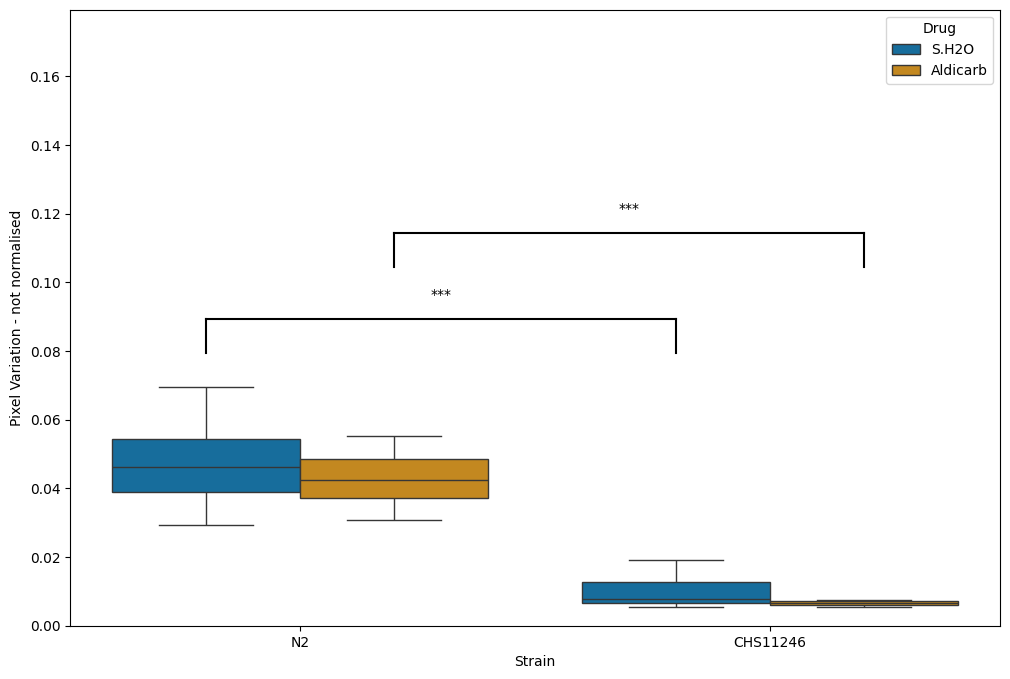

In [4]:
all_data_df_stats = all_data_df.copy()

control_strains = ['N2', 'CHS11246']

# Filter the DataFrame to include only the control strains
n2_chs11246_stats = all_data_df_stats[all_data_df_stats['strain'].isin(control_strains)]

control_wells = ['S.H2O']
aldicarb = ['Aldicarb']
aldicarb_conc = [7.5]

# Filter the DataFrame to include only the controll_wells and aldicarb and aldicarb_conc
chs11246_aldi_analysis = n2_chs11246_stats[(all_data_df_stats['drug'].isin(control_wells)) | 
                                        (all_data_df_stats['drug'].isin(aldicarb)) & 
                                        (all_data_df_stats['concentration'].isin(aldicarb_conc))]


import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 1. Control Data Analysis (Strain Effect)
control_data = n2_chs11246_stats[n2_chs11246_stats['drug'].isin(control_wells)]
model_control = ols('value ~ strain', data=control_data).fit()
anova_control = sm.stats.anova_lm(model_control, typ=2)
print("Control Data - S.H2O (Strain Effect):")
print(anova_control)

# 2. Aldicarb 7.5 µM Analysis (Drug Effect)
aldicarb_data = n2_chs11246_stats[
    (n2_chs11246_stats['drug'].isin(aldicarb)) & 
    (n2_chs11246_stats['concentration'].isin(aldicarb_conc))
]
model_aldicarb = ols('value ~ strain', data=aldicarb_data).fit()
anova_aldicarb = sm.stats.anova_lm(model_aldicarb, typ=2)
print("\nAldicarb 7.5 µM (Drug Effect):")
print(anova_aldicarb)

# 3. Combined Analysis (Interaction Effect)
combined_data = chs11246_aldi_analysis
model_combined = ols('value ~ strain * drug', data=combined_data).fit()
anova_combined = sm.stats.anova_lm(model_combined, typ=2)
print("\nCombined Analysis (Interaction Effect):")
print(anova_combined)

# Determine which test has the main effect
def get_main_effect_test():
    # Extract p-values for each effect from the ANOVA tables
    control_p = anova_control.loc['strain', 'PR(>F)'] if 'strain' in anova_control.index else float('inf')
    aldicarb_p = anova_aldicarb.loc['strain', 'PR(>F)'] if 'strain' in anova_aldicarb.index else float('inf')
    strain_p = anova_combined.loc['strain', 'PR(>F)'] if 'strain' in anova_combined.index else float('inf')
    drug_p = anova_combined.loc['drug', 'PR(>F)'] if 'drug' in anova_combined.index else float('inf')
    interaction_p = anova_combined.loc['strain:drug', 'PR(>F)'] if 'strain:drug' in anova_combined.index else float('inf')

    # Create a dictionary of p-values for each effect
    p_values = {
        'strain (control)': control_p,
        'strain (aldicarb)': aldicarb_p,
        'strain (combined)': strain_p,
        'drug': drug_p,
        'strain:drug': interaction_p
    }

    # Find the effect with the smallest p-value
    main_effect_test = min(p_values, key=p_values.get)

    # Return the test name and its p-value
    return main_effect_test, p_values[main_effect_test]

# Get the main effect test and its p-value
main_effect_test, main_effect_p = get_main_effect_test()

# Print the significant main effect
print(f"\nSignificant main effect: {main_effect_test} (p = {main_effect_p:.3e})")


# Plot the results of the ANOVA by indicating significance in a boxplot
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define the order of the hue categories
hue_order = ['S.H2O', 'Aldicarb']

# Plot the results of the ANOVA by indicating significance in a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='strain', y='value', hue='drug', data=chs11246_aldi_analysis, palette='colorblind', hue_order=hue_order)
plt.xlabel('Strain')
plt.ylabel('Pixel Variation - not normalised')
plt.legend(title='Drug')

# Calculate the maximum y-value across all datasets
max_y_value = max(
    control_data['value'].max(),
    aldicarb_data['value'].max(),
    combined_data['value'].max()
)

# Adjust the y-axis limit dynamically to include space for significance markers
extra_space = 0.01  # Add extra space above the maximum value for significance markers
plt.ylim(0, max_y_value + extra_space + 0.1)

# Function to determine the significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''


# 1. Add significance for 'anova_control'
for i, row in anova_control.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = -0.2, 0.8  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.02  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.005, stars, ha='center', va='bottom', color='black')  # Add significance text

# 2. Add significance for 'anova_aldicarb'
for i, row in anova_aldicarb.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = 0.2, 1.2  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.045  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.005, stars, ha='center', va='bottom', color='black')  # Add significance text

# 3. Add significance for 'anova_combined'
for i, row in anova_combined.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        if ':' in row.name:  # Check if the row name contains a colon
            x1, x2 = 0, 2  # Replace with the indices of the boxplots being compared
            y = max_y_value + 0.06  # Adjust y-position for the bar
            plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
            plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
            plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
            plt.text((x1 + x2) / 2, y + 0.01, stars, ha='center', va='bottom', color='black')  # Add significance text

plt.show()


#### Checking statistiacal analyis using CHS10981_CUC as test for a strain that looks more sensitive to Aldicarb at 20 µM. 

CHS10981_CUC grew well in control wells (similar to N2) and seems to have a lower pixel variance at Aldicarb 20 µM compoared to N2 at same drug and concentration. 
As such, It should come up as a strain:drug interaction effect in the statistical analysis.

I will check:

1. Control data of CHS10981_CUC against N2 control data (is there a strain effect?)
2. Aldicarb 20 µM of CHS10981_CUC against that of N2 (is there a drug effect?)
3. Both control and Aldicarb 20 µM for CHS10981_CUC and N2 (is the drug effect independent of the strain effect?)

Control Data - S.H2O (Strain Effect):
            sum_sq    df         F   PR(>F)
strain    0.000009   1.0  0.177885  0.67729
Residual  0.001083  22.0       NaN      NaN

Aldicarb 20 µM (Drug Effect):
            sum_sq   df         F    PR(>F)
strain    0.000188  1.0  9.376311  0.037582
Residual  0.000080  4.0       NaN       NaN

Combined Analysis (Interaction Effect):
               sum_sq    df          F        PR(>F)
strain       0.000077   1.0   1.720240  2.011265e-01
drug         0.003492   1.0  78.070568  2.612513e-09
strain:drug  0.000119   1.0   2.669342  1.143509e-01
Residual     0.001163  26.0        NaN           NaN

Significant main effect: drug (p = 2.613e-09)


/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_4647/1509972419.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  CHS10981_CUC_aldi_analysis = n2_CHS10981_CUC_stats[(all_data_df_stats['drug'].isin(control_wells)) |


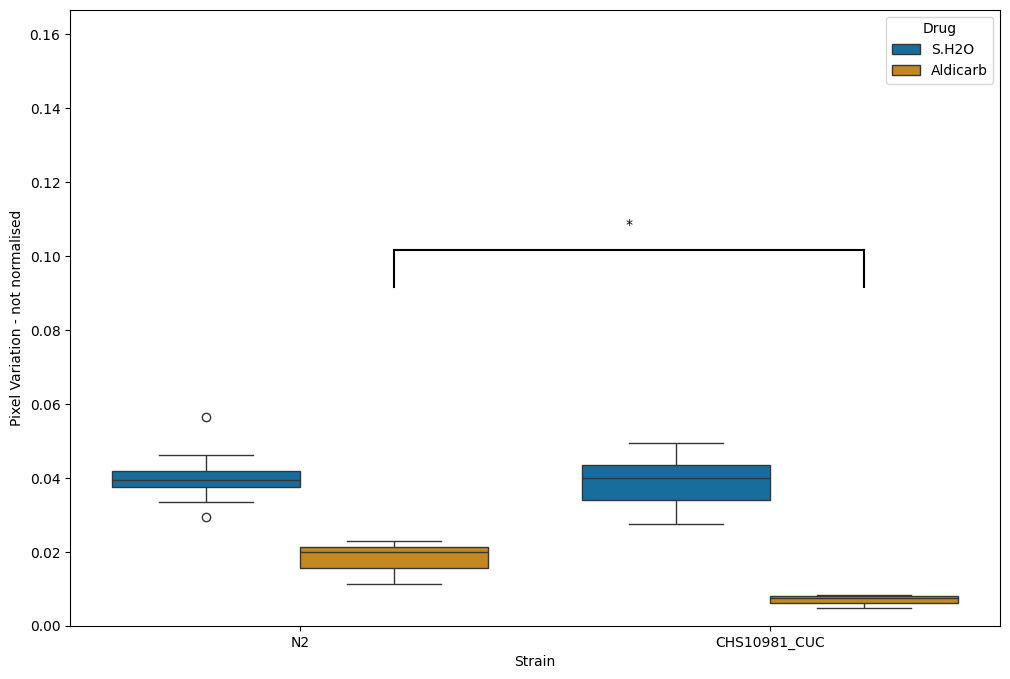

In [21]:
all_data_df_stats = all_data_df.copy()

control_strains = ['N2', 'CHS10981_CUC']

# Filter the DataFrame to include only the control strains
n2_CHS10981_CUC_stats = all_data_df_stats[all_data_df_stats['strain'].isin(control_strains)]


# Get the unique dates for the other strain (excluding 'N2')
other_strain_dates = n2_CHS10981_CUC_stats.loc[
    n2_CHS10981_CUC_stats['strain'] != 'N2', 'date_yyyymmdd'
].unique()

# Filter 'N2' rows to only include matching dates (analasying only to the N2 on that day)
n2_CHS10981_CUC_stats = n2_CHS10981_CUC_stats[
    (n2_CHS10981_CUC_stats['strain'].isin(control_strains)) & (n2_CHS10981_CUC_stats['date_yyyymmdd'].isin(other_strain_dates))
]

control_wells = ['S.H2O']
aldicarb = ['Aldicarb']
aldicarb_conc = [20]

# Filter the DataFrame to include only the controll_wells and aldicarb and aldicarb_conc
CHS10981_CUC_aldi_analysis = n2_CHS10981_CUC_stats[(all_data_df_stats['drug'].isin(control_wells)) | 
                                        (all_data_df_stats['drug'].isin(aldicarb)) & 
                                        (all_data_df_stats['concentration'].isin(aldicarb_conc))]


import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 1. Control Data Analysis (Strain Effect)
control_data = n2_CHS10981_CUC_stats[n2_CHS10981_CUC_stats['drug'].isin(control_wells)]
model_control = ols('value ~ strain', data=control_data).fit()
anova_control = sm.stats.anova_lm(model_control, typ=2)
print("Control Data - S.H2O (Strain Effect):")
print(anova_control)

# 2. Aldicarb 20 µM Analysis (Drug Effect)
aldicarb_data = n2_CHS10981_CUC_stats[
    (n2_CHS10981_CUC_stats['drug'].isin(aldicarb)) & 
    (n2_CHS10981_CUC_stats['concentration'].isin(aldicarb_conc))
]
model_aldicarb = ols('value ~ strain', data=aldicarb_data).fit()
anova_aldicarb = sm.stats.anova_lm(model_aldicarb, typ=2)
print("\nAldicarb 20 µM (Drug Effect):")
print(anova_aldicarb)

# 3. Combined Analysis (Interaction Effect)
combined_data = CHS10981_CUC_aldi_analysis
model_combined = ols('value ~ strain * drug', data=combined_data).fit()
anova_combined = sm.stats.anova_lm(model_combined, typ=2)
print("\nCombined Analysis (Interaction Effect):")
print(anova_combined)


# Determine which test has the main effect
def get_main_effect_test():
    # Extract p-values for each effect from the ANOVA tables
    control_p = anova_control.loc['strain', 'PR(>F)'] if 'strain' in anova_control.index else float('inf')
    aldicarb_p = anova_aldicarb.loc['strain', 'PR(>F)'] if 'strain' in anova_aldicarb.index else float('inf')
    strain_p = anova_combined.loc['strain', 'PR(>F)'] if 'strain' in anova_combined.index else float('inf')
    drug_p = anova_combined.loc['drug', 'PR(>F)'] if 'drug' in anova_combined.index else float('inf')
    interaction_p = anova_combined.loc['strain:drug', 'PR(>F)'] if 'strain:drug' in anova_combined.index else float('inf')

    # Create a dictionary of p-values for each effect
    p_values = {
        'strain (control)': control_p,
        'strain (aldicarb)': aldicarb_p,
        'strain (combined)': strain_p,
        'drug': drug_p,
        'strain:drug': interaction_p
    }

    # Find the effect with the smallest p-value
    main_effect_test = min(p_values, key=p_values.get)

    # Return the test name and its p-value
    return main_effect_test, p_values[main_effect_test]

# Get the main effect test and its p-value
main_effect_test, main_effect_p = get_main_effect_test()

# Print the significant main effect
print(f"\nSignificant main effect: {main_effect_test} (p = {main_effect_p:.3e})")

# Plot the results of the ANOVA by indicating significance in a boxplot
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define the order of the hue categories
hue_order = ['S.H2O', 'Aldicarb']

# Plot the results of the ANOVA by indicating significance in a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='strain', y='value', hue='drug', data=CHS10981_CUC_aldi_analysis, palette='colorblind', hue_order=hue_order)
plt.xlabel('Strain')
plt.ylabel('Pixel Variation - not normalised')
plt.legend(title='Drug')

# Calculate the maximum y-value across all datasets
max_y_value = max(
    control_data['value'].max(),
    aldicarb_data['value'].max(),
    combined_data['value'].max()
)

# Adjust the y-axis limit dynamically to include space for significance markers
extra_space = 0.01  # Add extra space above the maximum value for significance markers
plt.ylim(0, max_y_value + extra_space + 0.1)

# Function to determine the significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''


# 1. Add significance for 'anova_control'
for i, row in anova_control.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = -0.2, 0.8  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.02  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.005, stars, ha='center', va='bottom', color='black')  # Add significance text

# 2. Add significance for 'anova_aldicarb'
for i, row in anova_aldicarb.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = 0.2, 1.2  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.045  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.005, stars, ha='center', va='bottom', color='black')  # Add significance text

# 3. Add significance for 'anova_combined'
for i, row in anova_combined.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        if ':' in row.name:  # Check if the row name contains a colon
            x1, x2 = 0, 2  # Replace with the indices of the boxplots being compared
            y = max_y_value + 0.06  # Adjust y-position for the bar
            plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
            plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
            plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
            plt.text((x1 + x2) / 2, y + 0.01, stars, ha='center', va='bottom', color='black')  # Add significance text

plt.show()


### Another ANOVA analysis - this one significant strain:drug interaction

nhr-8 / AE501 which is a strain control already confirmed to be more sensitive to some drugs. 

Comparing N2 of the day of recording the strain only

Control Data - S.H2O (Strain Effect):
            sum_sq    df          F        PR(>F)
strain    0.006241   1.0  63.860323  6.011262e-08
Residual  0.002150  22.0        NaN           NaN

Levamisole 2.0 µM (Drug Effect):
            sum_sq   df          F    PR(>F)
strain    0.001558  1.0  21.126076  0.010059
Residual  0.000295  4.0        NaN       NaN

Combined Analysis (Interaction Effect):
                   sum_sq    df          F        PR(>F)
strain       7.799491e-03   1.0  82.934638  1.433000e-09
drug         1.204108e-03   1.0  12.803692  1.389783e-03
strain:drug  4.707897e-10   1.0   0.000005  9.982319e-01
Residual     2.445140e-03  26.0        NaN           NaN

Significant main effect: strain (combined) (p = 1.433e-09)

The strain:drug interaction is not significant (p = 9.982e-01).


/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_4647/3692250496.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  strain_drug_analysis = n2_strain_stats[(all_data_df_stats['drug'].isin(control_wells)) |


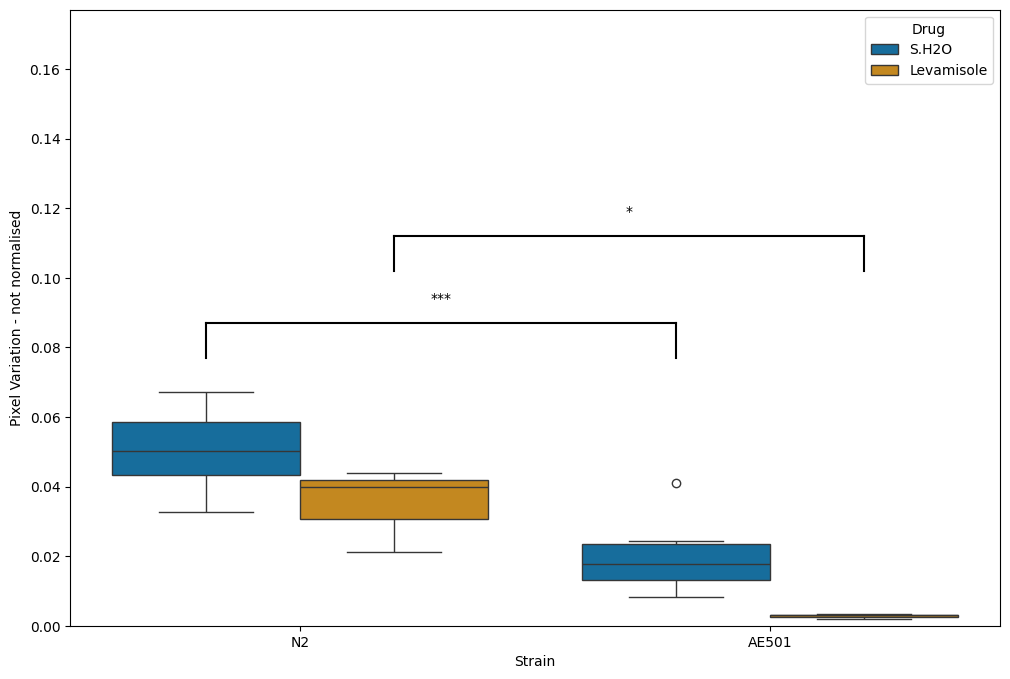

In [20]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


all_data_df_stats = all_data_df.copy()

control_strains = ['N2', 'AE501']

# Define the order of the hue categories (plotting)
hue_order = ['S.H2O', 'Levamisole']

# Filter the DataFrame to include only the control strains
n2_strain_stats = all_data_df_stats[all_data_df_stats['strain'].isin(control_strains)]

# Get the unique dates for the other strain (excluding 'N2')
other_strain_dates = n2_strain_stats.loc[
    n2_strain_stats['strain'] != 'N2', 'date_yyyymmdd'
].unique()

# Filter 'N2' rows to only include matching dates (analasying only to the N2 on that day)
n2_strain_stats = n2_strain_stats[
    (n2_strain_stats['strain'].isin(control_strains)) & (n2_strain_stats['date_yyyymmdd'].isin(other_strain_dates))
]

control_wells = ['S.H2O']
drug = ['Levamisole']
drug_conc = [2.0]

# Filter the DataFrame to include only the controll_wells and drug and drug_conc
strain_drug_analysis = n2_strain_stats[(all_data_df_stats['drug'].isin(control_wells)) | 
                                        (all_data_df_stats['drug'].isin(drug)) & 
                                        (all_data_df_stats['concentration'].isin(drug_conc))]


# 1. Control Data Analysis (Strain Effect)
control_data = n2_strain_stats[n2_strain_stats['drug'].isin(control_wells)]
model_control = ols('value ~ strain', data=control_data).fit()
anova_control = sm.stats.anova_lm(model_control, typ=2)
print("Control Data - S.H2O (Strain Effect):")
print(anova_control)

# 2. Drug at one concentration (µM) Analysis (Drug Effect)
drug_data = n2_strain_stats[
    (n2_strain_stats['drug'].isin(drug)) & 
    (n2_strain_stats['concentration'].isin(drug_conc))
]
model_drug = ols('value ~ strain', data=drug_data).fit()
anova_drug = sm.stats.anova_lm(model_drug, typ=2)
print("\nLevamisole 2.0 µM (Drug Effect):")
print(anova_drug)

# 3. Combined Analysis (Interaction Effect)
combined_data = strain_drug_analysis
model_combined = ols('value ~ strain * drug', data=combined_data).fit()
anova_combined = sm.stats.anova_lm(model_combined, typ=2)
print("\nCombined Analysis (Interaction Effect):")
print(anova_combined)


# Determine which test has the main effect
def get_main_effect_test():
    # Extract p-values for each effect from the ANOVA tables
    control_p = anova_control.loc['strain', 'PR(>F)'] if 'strain' in anova_control.index else float('inf')
    drug_indep_p = anova_drug.loc['strain', 'PR(>F)'] if 'strain' in anova_drug.index else float('inf')
    strain_p = anova_combined.loc['strain', 'PR(>F)'] if 'strain' in anova_combined.index else float('inf')
    drug_p = anova_combined.loc['drug', 'PR(>F)'] if 'drug' in anova_combined.index else float('inf')
    interaction_p = anova_combined.loc['strain:drug', 'PR(>F)'] if 'strain:drug' in anova_combined.index else float('inf')

    # Create a dictionary of p-values for each effect
    p_values = {
        'strain (control)': control_p,
        'strain (drug)': drug_indep_p,
        'strain (combined)': strain_p,
        'drug': drug_p,
        'strain:drug': interaction_p
    }

    # Find the effect with the smallest p-value
    main_effect_test = min(p_values, key=p_values.get)

    # Check if the strain:drug interaction is significant
    interaction_significance = "significant" if interaction_p < 0.05 else "not significant"

    # Return the test name and its p-value
    return main_effect_test, p_values[main_effect_test], interaction_p, interaction_significance

# Get the main effect test and its p-value
main_effect_test, main_effect_p, interaction_p, interaction_significance = get_main_effect_test()

# Print the significant main effect
print(f"\nSignificant main effect: {main_effect_test} (p = {main_effect_p:.3e})")

# Print whether the strain:drug interaction is significant
print(f"\nThe strain:drug interaction is {interaction_significance} (p = {interaction_p:.3e}).")





# Plot the results of the ANOVA by indicating significance in a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='strain', y='value', hue='drug', data=strain_drug_analysis, palette='colorblind', hue_order=hue_order)
plt.xlabel('Strain')
plt.ylabel('Pixel Variation - not normalised')
plt.legend(title='Drug')

# Calculate the maximum y-value across all datasets
max_y_value = max(
    control_data['value'].max(),
    drug_data['value'].max(),
    combined_data['value'].max()
)

# Adjust the y-axis limit dynamically to include space for significance markers
extra_space = 0.01  # Add extra space above the maximum value for significance markers
plt.ylim(0, max_y_value + extra_space + 0.1)

# Function to determine the significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''


# 1. Add significance for 'anova_control'
for i, row in anova_control.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = -0.2, 0.8  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.02  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.005, stars, ha='center', va='bottom', color='black')  # Add significance text

# 2. Add significance for 'anova_drug'
for i, row in anova_drug.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = 0.2, 1.2  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.045  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.005, stars, ha='center', va='bottom', color='black')  # Add significance text

# 3. Add significance for 'anova_combined'
for i, row in anova_combined.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        if ':' in row.name:  # Check if the row name contains a colon
            x1, x2 = 0, 2  # Replace with the indices of the boxplots being compared
            y = max_y_value + 0.06  # Adjust y-position for the bar
            plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
            plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
            plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
            plt.text((x1 + x2) / 2, y + 0.01, stars, ha='center', va='bottom', color='black')  # Add significance text

plt.show()


### CHS11186_VZR

Comapring N2s of the day of the strain recording only


Control Data - S.H2O (Strain Effect):
            sum_sq    df          F    PR(>F)
strain    0.003336   1.0  44.447908  0.000001
Residual  0.001651  22.0        NaN       NaN

Levamisole 2.0 µM (Drug Effect):
            sum_sq   df          F    PR(>F)
strain    0.001775  1.0  72.512624  0.001043
Residual  0.000098  4.0        NaN       NaN

Combined Analysis (Interaction Effect):
               sum_sq    df          F        PR(>F)
strain       0.004970   1.0  73.882744  4.484575e-09
drug         0.000227   1.0   3.372963  7.773379e-02
strain:drug  0.000140   1.0   2.087171  1.604856e-01
Residual     0.001749  26.0        NaN           NaN

Significant main effect: strain (combined) (p = 4.485e-09)

The strain:drug interaction is not significant (p = 1.605e-01).


/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_4647/1227493208.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  strain_drug_analysis = n2_strain_stats[(all_data_df_stats['drug'].isin(control_wells)) |


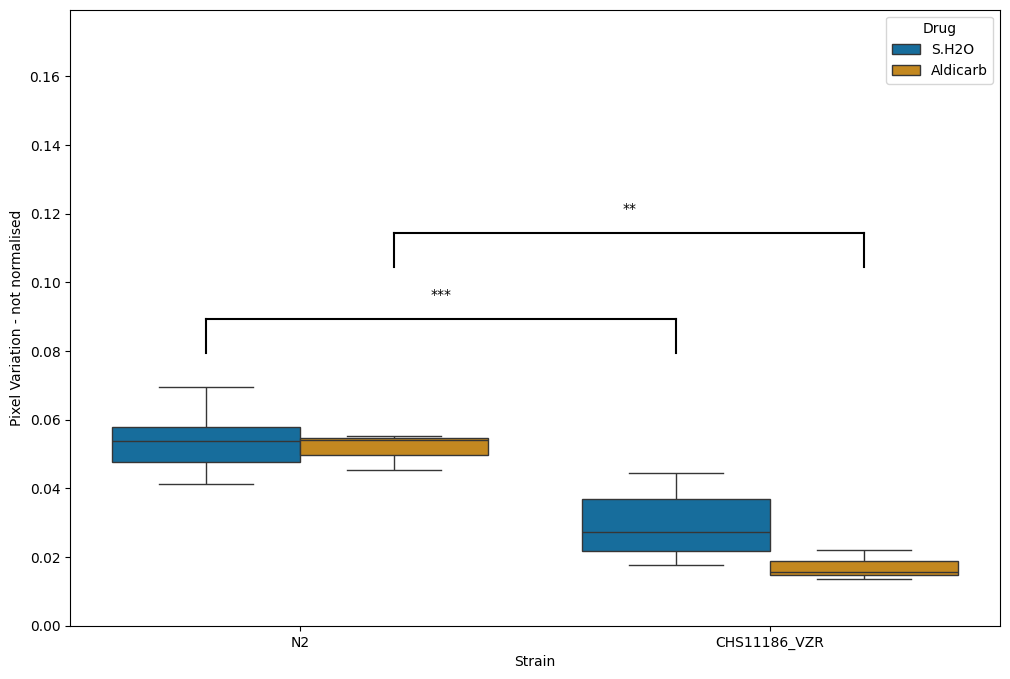

In [19]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


all_data_df_stats = all_data_df.copy()

control_strains = ['N2', 'CHS11186_VZR']

# Filter the DataFrame to include only the control strains
n2_strain_stats = all_data_df_stats[all_data_df_stats['strain'].isin(control_strains)]

# Get the unique dates for the other strain (excluding 'N2')
other_strain_dates = n2_strain_stats.loc[
    n2_strain_stats['strain'] != 'N2', 'date_yyyymmdd'
].unique()

# Filter 'N2' rows to only include matching dates (analasying only to the N2 on that day)
n2_strain_stats = n2_strain_stats[
    (n2_strain_stats['strain'].isin(control_strains)) & (n2_strain_stats['date_yyyymmdd'].isin(other_strain_dates))
]


control_wells = ['S.H2O']
drug = ['Aldicarb']
drug_conc = [7.5]

# Define the order of the hue categories (plotting)
hue_order = ['S.H2O', 'Aldicarb']

# Filter the DataFrame to include only the controll_wells and drug and drug_conc
strain_drug_analysis = n2_strain_stats[(all_data_df_stats['drug'].isin(control_wells)) | 
                                        (all_data_df_stats['drug'].isin(drug)) & 
                                        (all_data_df_stats['concentration'].isin(drug_conc))]


# 1. Control Data Analysis (Strain Effect)
control_data = n2_strain_stats[n2_strain_stats['drug'].isin(control_wells)]
model_control = ols('value ~ strain', data=control_data).fit()
anova_control = sm.stats.anova_lm(model_control, typ=2)
print("Control Data - S.H2O (Strain Effect):")
print(anova_control)

# 2. Drug at one concentration (µM) Analysis (Drug Effect)
drug_data = n2_strain_stats[
    (n2_strain_stats['drug'].isin(drug)) & 
    (n2_strain_stats['concentration'].isin(drug_conc))
]
model_drug = ols('value ~ strain', data=drug_data).fit()
anova_drug = sm.stats.anova_lm(model_drug, typ=2)
print("\nLevamisole 2.0 µM (Drug Effect):")
print(anova_drug)

# 3. Combined Analysis (Interaction Effect)
combined_data = strain_drug_analysis
model_combined = ols('value ~ strain * drug', data=combined_data).fit()
anova_combined = sm.stats.anova_lm(model_combined, typ=2)
print("\nCombined Analysis (Interaction Effect):")
print(anova_combined)


# Determine which test has the main effect
def get_main_effect_test():
    # Extract p-values for each effect from the ANOVA tables
    control_p = anova_control.loc['strain', 'PR(>F)'] if 'strain' in anova_control.index else float('inf')
    drug_indep_p = anova_drug.loc['strain', 'PR(>F)'] if 'strain' in anova_drug.index else float('inf')
    strain_p = anova_combined.loc['strain', 'PR(>F)'] if 'strain' in anova_combined.index else float('inf')
    drug_p = anova_combined.loc['drug', 'PR(>F)'] if 'drug' in anova_combined.index else float('inf')
    interaction_p = anova_combined.loc['strain:drug', 'PR(>F)'] if 'strain:drug' in anova_combined.index else float('inf')

    # Create a dictionary of p-values for each effect
    p_values = {
        'strain (control)': control_p,
        'strain (drug)': drug_indep_p,
        'strain (combined)': strain_p,
        'drug': drug_p,
        'strain:drug': interaction_p
    }

    # Find the effect with the smallest p-value
    main_effect_test = min(p_values, key=p_values.get)

    # Check if the strain:drug interaction is significant
    interaction_significance = "significant" if interaction_p < 0.05 else "not significant"

    # Return the test name and its p-value
    return main_effect_test, p_values[main_effect_test], interaction_p, interaction_significance

# Get the main effect test and its p-value
main_effect_test, main_effect_p, interaction_p, interaction_significance = get_main_effect_test()

# Print the significant main effect
print(f"\nSignificant main effect: {main_effect_test} (p = {main_effect_p:.3e})")

# Print whether the strain:drug interaction is significant
print(f"\nThe strain:drug interaction is {interaction_significance} (p = {interaction_p:.3e}).")



# Plot the results of the ANOVA by indicating significance in a boxplot



# Plot the results of the ANOVA by indicating significance in a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='strain', y='value', hue='drug', data=strain_drug_analysis, palette='colorblind', hue_order=hue_order)
plt.xlabel('Strain')
plt.ylabel('Pixel Variation - not normalised')
plt.legend(title='Drug')

# Calculate the maximum y-value across all datasets
max_y_value = max(
    control_data['value'].max(),
    drug_data['value'].max(),
    combined_data['value'].max()
)

# Adjust the y-axis limit dynamically to include space for significance markers
extra_space = 0.01  # Add extra space above the maximum value for significance markers
plt.ylim(0, max_y_value + extra_space + 0.1)

# Function to determine the significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''


# 1. Add significance for 'anova_control'
for i, row in anova_control.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = -0.2, 0.8  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.02  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.005, stars, ha='center', va='bottom', color='black')  # Add significance text

# 2. Add significance for 'anova_drug'
for i, row in anova_drug.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = 0.2, 1.2  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.045  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.005, stars, ha='center', va='bottom', color='black')  # Add significance text

# 3. Add significance for 'anova_combined'
for i, row in anova_combined.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        if ':' in row.name:  # Check if the row name contains a colon
            x1, x2 = 0, 2  # Replace with the indices of the boxplots being compared
            y = max_y_value + 0.06  # Adjust y-position for the bar
            plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
            plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
            plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
            plt.text((x1 + x2) / 2, y + 0.01, stars, ha='center', va='bottom', color='black')  # Add significance text

plt.show()


### CHS11227_LKG

comparing to N2 of the day of the strain recording only

Control Data - S.H2O (Strain Effect):
            sum_sq    df         F    PR(>F)
strain    0.000002   1.0  0.025911  0.872677
Residual  0.005149  58.0       NaN       NaN
\Chlorpromazine 10 µM (Drug Effect):
            sum_sq    df         F    PR(>F)
strain    0.000738   1.0  5.211614  0.039904
Residual  0.001840  13.0       NaN       NaN

Combined Analysis (Interaction Effect):
               sum_sq    df          F        PR(>F)
strain       0.000182   1.0   1.851900  1.778667e-01
drug         0.003777   1.0  38.371362  3.391731e-08
strain:drug  0.000558   1.0   5.663735  2.000820e-02
Residual     0.006989  71.0        NaN           NaN

Significant main effect: drug (p = 3.392e-08)

The strain:drug interaction is significant (p = 2.001e-02).


/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_4647/3872684195.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  strain_drug_analysis = n2_strain_stats[(all_data_df_stats['drug'].isin(control_wells)) |


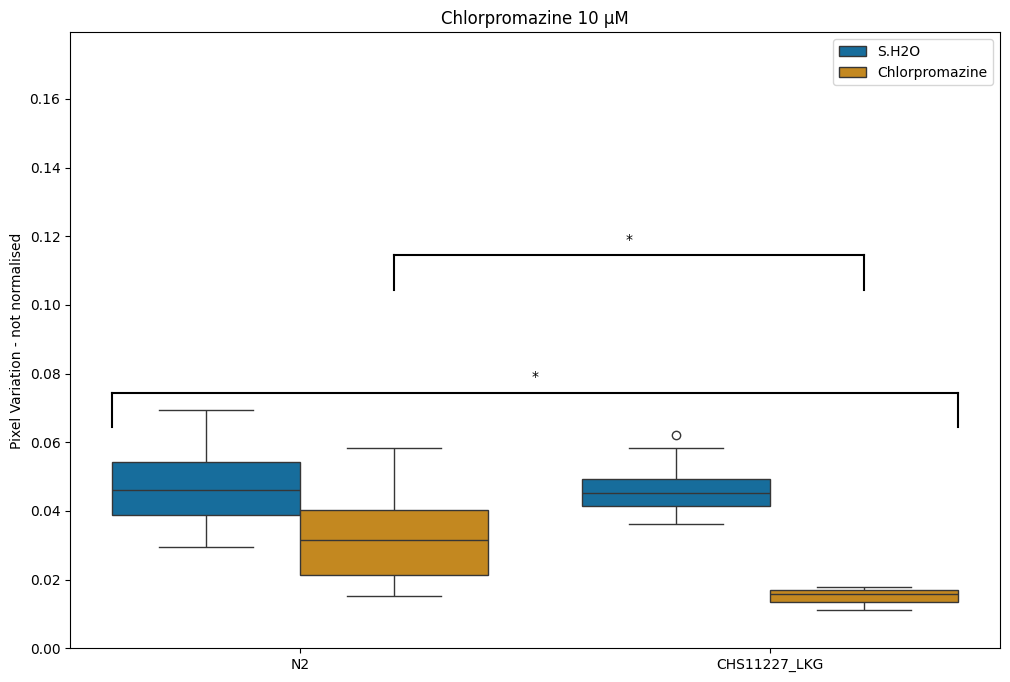

In [53]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


all_data_df_stats = all_data_df.copy()

control_strains = ['N2', 'CHS11227_LKG']

# Filter the DataFrame to include only the control strains
n2_strain_stats = all_data_df_stats[all_data_df_stats['strain'].isin(control_strains)]

# Get the unique dates for the other strain (excluding 'N2')
#other_strain_dates = n2_strain_stats.loc[
#    n2_strain_stats['strain'] != 'N2', 'date_yyyymmdd'
#].unique()
#
## Filter 'N2' rows to only include matching dates (analasying only to the N2 on that day)
#n2_strain_stats = n2_strain_stats[
#    (n2_strain_stats['strain'].isin(control_strains)) & (n2_strain_stats['date_yyyymmdd'].isin(other_strain_dates))
#]


control_wells = ['S.H2O']
drug = ['Chlorpromazine']
drug_conc = [10]

# Define the order of the hue categories (plotting)
hue_order = ['S.H2O', 'Chlorpromazine']

# Filter the DataFrame to include only the controll_wells and drug and drug_conc
strain_drug_analysis = n2_strain_stats[(all_data_df_stats['drug'].isin(control_wells)) | 
                                        (all_data_df_stats['drug'].isin(drug)) & 
                                        (all_data_df_stats['concentration'].isin(drug_conc))]


# 1. Control Data Analysis (Strain Effect)
control_data = n2_strain_stats[n2_strain_stats['drug'].isin(control_wells)]
model_control = ols('value ~ strain', data=control_data).fit()
anova_control = sm.stats.anova_lm(model_control, typ=2)
print("Control Data - S.H2O (Strain Effect):")
print(anova_control)

# 2. Drug at one concentration (µM) Analysis (Drug Effect)
drug_data = n2_strain_stats[
    (n2_strain_stats['drug'].isin(drug)) & 
    (n2_strain_stats['concentration'].isin(drug_conc))
]
model_drug = ols('value ~ strain', data=drug_data).fit()
anova_drug = sm.stats.anova_lm(model_drug, typ=2)
print("\Chlorpromazine 10 µM (Drug Effect):")
print(anova_drug)

# 3. Combined Analysis (Interaction Effect)
combined_data = strain_drug_analysis
model_combined = ols('value ~ strain * drug', data=combined_data).fit()
anova_combined = sm.stats.anova_lm(model_combined, typ=2)
print("\nCombined Analysis (Interaction Effect):")
print(anova_combined)


# Determine which test has the main effect
def get_main_effect_test():
    # Extract p-values for each effect from the ANOVA tables
    control_p = anova_control.loc['strain', 'PR(>F)'] if 'strain' in anova_control.index else float('inf')
    drug_indep_p = anova_drug.loc['strain', 'PR(>F)'] if 'strain' in anova_drug.index else float('inf')
    strain_p = anova_combined.loc['strain', 'PR(>F)'] if 'strain' in anova_combined.index else float('inf')
    drug_p = anova_combined.loc['drug', 'PR(>F)'] if 'drug' in anova_combined.index else float('inf')
    interaction_p = anova_combined.loc['strain:drug', 'PR(>F)'] if 'strain:drug' in anova_combined.index else float('inf')

    # Create a dictionary of p-values for each effect
    p_values = {
        'strain (control)': control_p,
        'strain (drug)': drug_indep_p,
        'strain (combined)': strain_p,
        'drug': drug_p,
        'strain:drug': interaction_p
    }

    # Find the effect with the smallest p-value
    main_effect_test = min(p_values, key=p_values.get)

    # Check if the strain:drug interaction is significant
    interaction_significance = "significant" if interaction_p < 0.05 else "not significant"

    # Return the test name and its p-value
    return main_effect_test, p_values[main_effect_test], interaction_p, interaction_significance

# Get the main effect test and its p-value
main_effect_test, main_effect_p, interaction_p, interaction_significance = get_main_effect_test()

# Print the significant main effect
print(f"\nSignificant main effect: {main_effect_test} (p = {main_effect_p:.3e})")

# Print whether the strain:drug interaction is significant
print(f"\nThe strain:drug interaction is {interaction_significance} (p = {interaction_p:.3e}).")



# Plot the results of the ANOVA by indicating significance in a boxplot



# Plot the results of the ANOVA by indicating significance in a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='strain', y='value', hue='drug', data=strain_drug_analysis, palette='colorblind', hue_order=hue_order)
plt.xlabel('')
plt.title(f"{drug[0]} {drug_conc[0]} µM")
plt.ylabel('Pixel Variation - not normalised')
plt.legend(title='')

# Calculate the maximum y-value across all datasets
max_y_value = max(
    control_data['value'].max(),
    drug_data['value'].max(),
    combined_data['value'].max()
)

# Adjust the y-axis limit dynamically to include space for significance markers
extra_space = 0.01  # Add extra space above the maximum value for significance markers
plt.ylim(0, max_y_value + extra_space + 0.1)

# Function to determine the significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''


# 1. Add significance for 'anova_control'
for i, row in anova_control.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = -0.2, 0.8  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.02  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.0025, stars, ha='center', va='bottom', color='black')  # Add significance text


# 2. Add significance for 'anova_drug'
for i, row in anova_drug.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = 0.2, 1.2  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.045  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.0025, stars, ha='center', va='bottom', color='black')  # Add significance text


# 3. Add significance for 'anova_combined'
for i, row in anova_combined.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        if ':' in row.name:  # Check if the row name contains a colon
            x1, x2 = -0.4, 1.4  # Replace with the indices of the boxplots being compared
            y = max_y_value + 0.005  # Adjust y-position for the bar
            plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
            plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
            plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
            plt.text((x1 + x2) / 2, y + 0.0025, stars, ha='center', va='bottom', color='black')  # Add significance text


plt.show()


### Do above analysis for all strains in a loop


Analyzing strain: CHS10799_GUM

Analyzing drug: Aldicarb 2.5 µM

No significant interaction effect found for CHS10799_GUM with Aldicarb 2.5 µM.

Analyzing drug: Aldicarb 7.5 µM

No significant interaction effect found for CHS10799_GUM with Aldicarb 7.5 µM.

Analyzing drug: Aldicarb 20.0 µM

No significant interaction effect found for CHS10799_GUM with Aldicarb 20.0 µM.

Analyzing drug: Aldicarb 80.0 µM

No significant interaction effect found for CHS10799_GUM with Aldicarb 80.0 µM.

Analyzing drug: Levamisole 0.1 µM

No significant interaction effect found for CHS10799_GUM with Levamisole 0.1 µM.

Analyzing drug: Levamisole 0.5 µM

No significant interaction effect found for CHS10799_GUM with Levamisole 0.5 µM.

Analyzing drug: Levamisole 2.0 µM

Significant interaction effect found for CHS10799_GUM with Levamisole 2.0 µM:
               sum_sq    df          F    PR(>F)
strain       0.000875   1.0  10.905826  0.002792
drug         0.002661   1.0  33.172286  0.000005
strain:drug  0.00

KeyboardInterrupt: 

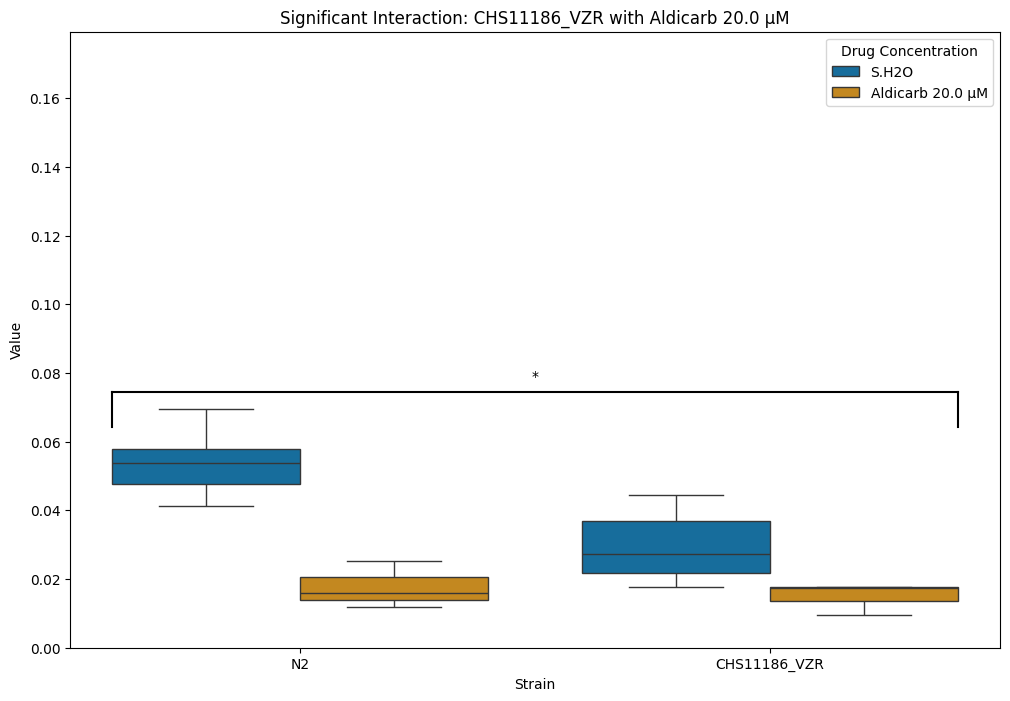

In [64]:
import pandas as pd
import os
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Ensure the directory exists
output_dir = '/Users/jb3623/Documents/250511_Analysis/NHR_drugs/sig'
os.makedirs(output_dir, exist_ok=True)

all_data_df_stats = all_data_df.copy()

# Remove rows with 'Ivermectin' in the 'drug' column from the dataset
all_data_df_stats = all_data_df_stats[all_data_df_stats['drug'] != 'Ivermectin']

# merge the 'drug' and 'concentration' columns into a single column
all_data_df_stats['drug_conc'] = all_data_df_stats['drug'] + ' ' + all_data_df_stats['concentration'].astype(str) + ' µM'
# Revert the values for 'S.H2O' and 'DMSO' back to their original names
all_data_df_stats.loc[all_data_df_stats['drug'] == 'S.H2O', 'drug_conc'] = 'S.H2O'
all_data_df_stats.loc[all_data_df_stats['drug'] == 'DMSO', 'drug_conc'] = 'DMSO'


# Define the control strain
control_strain = 'N2'
control_wells = 'S.H2O'
unique_strains = all_data_df_stats['strain'].unique()
uniuqe_strains = [strain for strain in unique_strains if strain != control_strain]
unique_drugs = all_data_df_stats['drug_conc'].unique()

# Function to determine the significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''


anova_results = []

# Loop through each strain
for strain in unique_strains:
    # Skip the control strain
    if strain == control_strain:
        continue
    # Print the current strain being analyzed
    print(f"\nAnalyzing strain: {strain}")

    # Filter data for the current strain and corresponding N2 rows with the same date
    strain_data = all_data_df_stats[all_data_df_stats['strain'] == strain]
    n2_data = all_data_df_stats[
        (all_data_df_stats['strain'] == control_strain) &
        (all_data_df_stats['date_yyyymmdd'].isin(strain_data['date_yyyymmdd']))
    ]

    # Combine the strain data and N2 data
    combined_data = pd.concat([strain_data, n2_data])

    for drug in unique_drugs:
        # Skip the control treatment ('S.H2O') as a drug
        if drug == control_wells:
            continue

        print(f"\nAnalyzing drug: {drug}")

        # Filter the combined data for the current drug
        drug_data = combined_data[combined_data['drug_conc'] == drug]

        control_treatment = combined_data[combined_data['drug_conc'] == control_wells]

        drug_data = pd.concat([drug_data, control_treatment])

        # Perform ANOVA
        model = ols('value ~ strain * drug', data=drug_data).fit()
        anova_results = sm.stats.anova_lm(model, typ=2)

        if 'strain:drug' in anova_results.index and anova_results.loc['strain:drug', 'PR(>F)'] < 0.05:
            print(f"\nSignificant interaction effect found for {strain} with {drug}:")
            print(anova_results)

            # Define the order for plotting
            drug_data['strain'] = pd.Categorical(
                drug_data['strain'], categories=[control_strain, strain], ordered=True
            )
            drug_data['drug_conc'] = pd.Categorical(
                drug_data['drug_conc'], categories=[control_wells, drug], ordered=True
            )

            # Generate the plot
            plt.figure(figsize=(12, 8))
            sns.boxplot(
                x='strain', y='value', hue='drug_conc', 
                data=drug_data, palette='colorblind'
            )
            plt.title(f"Significant Interaction: {strain} with {drug}")
            plt.xlabel('Strain')
            plt.ylabel('Value')
            plt.legend(title='Drug Concentration')

            # Calculate the maximum y-value across all datasets
            max_y_value = drug_data['value'].max()

            # Adjust the y-axis limit dynamically to include space for significance markers
            extra_space = 0.01  # Add extra space above the maximum value for significance markers
            plt.ylim(0, max_y_value + extra_space + 0.1)

            # Add significance markers
            for i, row in anova_results.iterrows():
                stars = get_significance_stars(row['PR(>F)'])
                if stars:
                    if ':' in row.name:  # Check if the row name contains a colon
                        x1, x2 = -0.4, 1.4  # Replace with the indices of the boxplots being compared
                        y = max_y_value + 0.005  # Adjust y-position for the bar
                        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
                        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
                        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
                        plt.text((x1 + x2) / 2, y + 0.0025, stars, ha='center', va='bottom', color='black')  # Add significance text

            # Save the plot
            plot_filename = f"{strain}_{drug}_interaction_plot.png".replace('/', '_')
            plot_path = os.path.join(output_dir, plot_filename)
            plt.savefig(plot_path)
            plt.close()  # Close the plot to free memory

        else:
            print(f"\nNo significant interaction effect found for {strain} with {drug}.")


'''

# Filter the DataFrame to include only the control strains
n2_strain_stats = all_data_df_stats[all_data_df_stats['strain'].isin(control_strains)]

# Get the unique dates for the other strain (excluding 'N2')
other_strain_dates = n2_strain_stats.loc[
    n2_strain_stats['strain'] != 'N2', 'date_yyyymmdd'
].unique()

# Filter 'N2' rows to only include matching dates (analasying only to the N2 on that day)
n2_strain_stats = n2_strain_stats[
    (n2_strain_stats['strain'].isin(control_strains)) & (n2_strain_stats['date_yyyymmdd'].isin(other_strain_dates))
]


control_wells = ['S.H2O']
drug = ['Chlorpromazine']
drug_conc = [10]

# Define the order of the hue categories (plotting)
hue_order = ['S.H2O', 'Chlorpromazine']

# Filter the DataFrame to include only the controll_wells and drug and drug_conc
strain_drug_analysis = n2_strain_stats[(all_data_df_stats['drug'].isin(control_wells)) | 
                                        (all_data_df_stats['drug'].isin(drug)) & 
                                        (all_data_df_stats['concentration'].isin(drug_conc))]


# 1. Control Data Analysis (Strain Effect)
control_data = n2_strain_stats[n2_strain_stats['drug'].isin(control_wells)]
model_control = ols('value ~ strain', data=control_data).fit()
anova_control = sm.stats.anova_lm(model_control, typ=2)
print("Control Data - S.H2O (Strain Effect):")
print(anova_control)

# 2. Drug at one concentration (µM) Analysis (Drug Effect)
drug_data = n2_strain_stats[
    (n2_strain_stats['drug'].isin(drug)) & 
    (n2_strain_stats['concentration'].isin(drug_conc))
]
model_drug = ols('value ~ strain', data=drug_data).fit()
anova_drug = sm.stats.anova_lm(model_drug, typ=2)
print("\Chlorpromazine 10 µM (Drug Effect):")
print(anova_drug)

# 3. Combined Analysis (Interaction Effect)
combined_data = strain_drug_analysis
model_combined = ols('value ~ strain * drug', data=combined_data).fit()
anova_combined = sm.stats.anova_lm(model_combined, typ=2)
print("\nCombined Analysis (Interaction Effect):")
print(anova_combined)


# Determine which test has the main effect
def get_main_effect_test():
    # Extract p-values for each effect from the ANOVA tables
    control_p = anova_control.loc['strain', 'PR(>F)'] if 'strain' in anova_control.index else float('inf')
    drug_indep_p = anova_drug.loc['strain', 'PR(>F)'] if 'strain' in anova_drug.index else float('inf')
    strain_p = anova_combined.loc['strain', 'PR(>F)'] if 'strain' in anova_combined.index else float('inf')
    drug_p = anova_combined.loc['drug', 'PR(>F)'] if 'drug' in anova_combined.index else float('inf')
    interaction_p = anova_combined.loc['strain:drug', 'PR(>F)'] if 'strain:drug' in anova_combined.index else float('inf')

    # Create a dictionary of p-values for each effect
    p_values = {
        'strain (control)': control_p,
        'strain (drug)': drug_indep_p,
        'strain (combined)': strain_p,
        'drug': drug_p,
        'strain:drug': interaction_p
    }

    # Find the effect with the smallest p-value
    main_effect_test = min(p_values, key=p_values.get)

    # Check if the strain:drug interaction is significant
    interaction_significance = "significant" if interaction_p < 0.05 else "not significant"

    # Return the test name and its p-value
    return main_effect_test, p_values[main_effect_test], interaction_p, interaction_significance

# Get the main effect test and its p-value
main_effect_test, main_effect_p, interaction_p, interaction_significance = get_main_effect_test()

# Print the significant main effect
print(f"\nSignificant main effect: {main_effect_test} (p = {main_effect_p:.3e})")

# Print whether the strain:drug interaction is significant
print(f"\nThe strain:drug interaction is {interaction_significance} (p = {interaction_p:.3e}).")



# Plot the results of the ANOVA by indicating significance in a boxplot



# Plot the results of the ANOVA by indicating significance in a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='strain', y='value', hue='drug', data=strain_drug_analysis, palette='colorblind', hue_order=hue_order)
plt.xlabel('')
plt.title(f"{drug[0]} {drug_conc[0]} µM")
plt.ylabel('Pixel Variation - not normalised')
plt.legend(title='')

# Calculate the maximum y-value across all datasets
max_y_value = max(
    control_data['value'].max(),
    drug_data['value'].max(),
    combined_data['value'].max()
)

# Adjust the y-axis limit dynamically to include space for significance markers
extra_space = 0.01  # Add extra space above the maximum value for significance markers
plt.ylim(0, max_y_value + extra_space + 0.1)

# Function to determine the significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''


# 1. Add significance for 'anova_control'
for i, row in anova_control.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = -0.2, 0.8  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.02  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.0025, stars, ha='center', va='bottom', color='black')  # Add significance text


# 2. Add significance for 'anova_drug'
for i, row in anova_drug.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        x1, x2 = 0.2, 1.2  # Replace with the indices of the boxplots being compared
        y = max_y_value + 0.045  # Adjust y-position for the bar
        plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
        plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
        plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
        plt.text((x1 + x2) / 2, y + 0.0025, stars, ha='center', va='bottom', color='black')  # Add significance text


# 3. Add significance for 'anova_combined'
for i, row in anova_combined.iterrows():
    stars = get_significance_stars(row['PR(>F)'])
    if stars:
        if ':' in row.name:  # Check if the row name contains a colon
            x1, x2 = -0.4, 1.4  # Replace with the indices of the boxplots being compared
            y = max_y_value + 0.005  # Adjust y-position for the bar
            plt.plot([x1, x2], [y, y], color='black', linewidth=1.5)  # Draw the horizontal bar
            plt.plot([x1, x1], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x1
            plt.plot([x2, x2], [y, y - 0.01], color='black', linewidth=1.5)  # Add vertical overhang at x2
            plt.text((x1 + x2) / 2, y + 0.0025, stars, ha='center', va='bottom', color='black')  # Add significance text


plt.show()'''

## Make a heatmap of only the truly significant strains


         strain            drug  concentration     stat_sig_type  \
0      CHS10482  Chlorpromazine            7.0  mutant sensitive   
1      CHS10482      Levamisole            0.5  mutant sensitive   
2  CHS10503_LTQ  Chlorpromazine            7.0  mutant sensitive   
3  CHS10504_ZJT      Levamisole            0.5  mutant sensitive   
4  CHS10505_API        Aldicarb            7.5  mutant sensitive   

  baseline_to_control              drug_conc  
0             similar  Chlorpromazine 7.0 µM  
1             similar      Levamisole 0.5 µM  
2             similar  Chlorpromazine 7.0 µM  
3             similar      Levamisole 0.5 µM  
4              higher        Aldicarb 7.5 µM  
         strain               drug_conc   p_value  \
0  CHS10799_GUM       Levamisole 2.0 µM  0.030662   
1  CHS10542_SJA  Chlorpromazine 10.0 µM  0.021514   
2  CHS10514_MDY         Aldicarb 7.5 µM  0.032950   
3  CHS10514_MDY       Levamisole 0.5 µM  0.007176   
4  CHS10514_MDY       Levamisole 2.0 µM  0.0

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_22907/2540254743.py:122: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = all_merged.pivot_table(index='strain', columns='drug_conc', values='normalized_value', aggfunc='first')


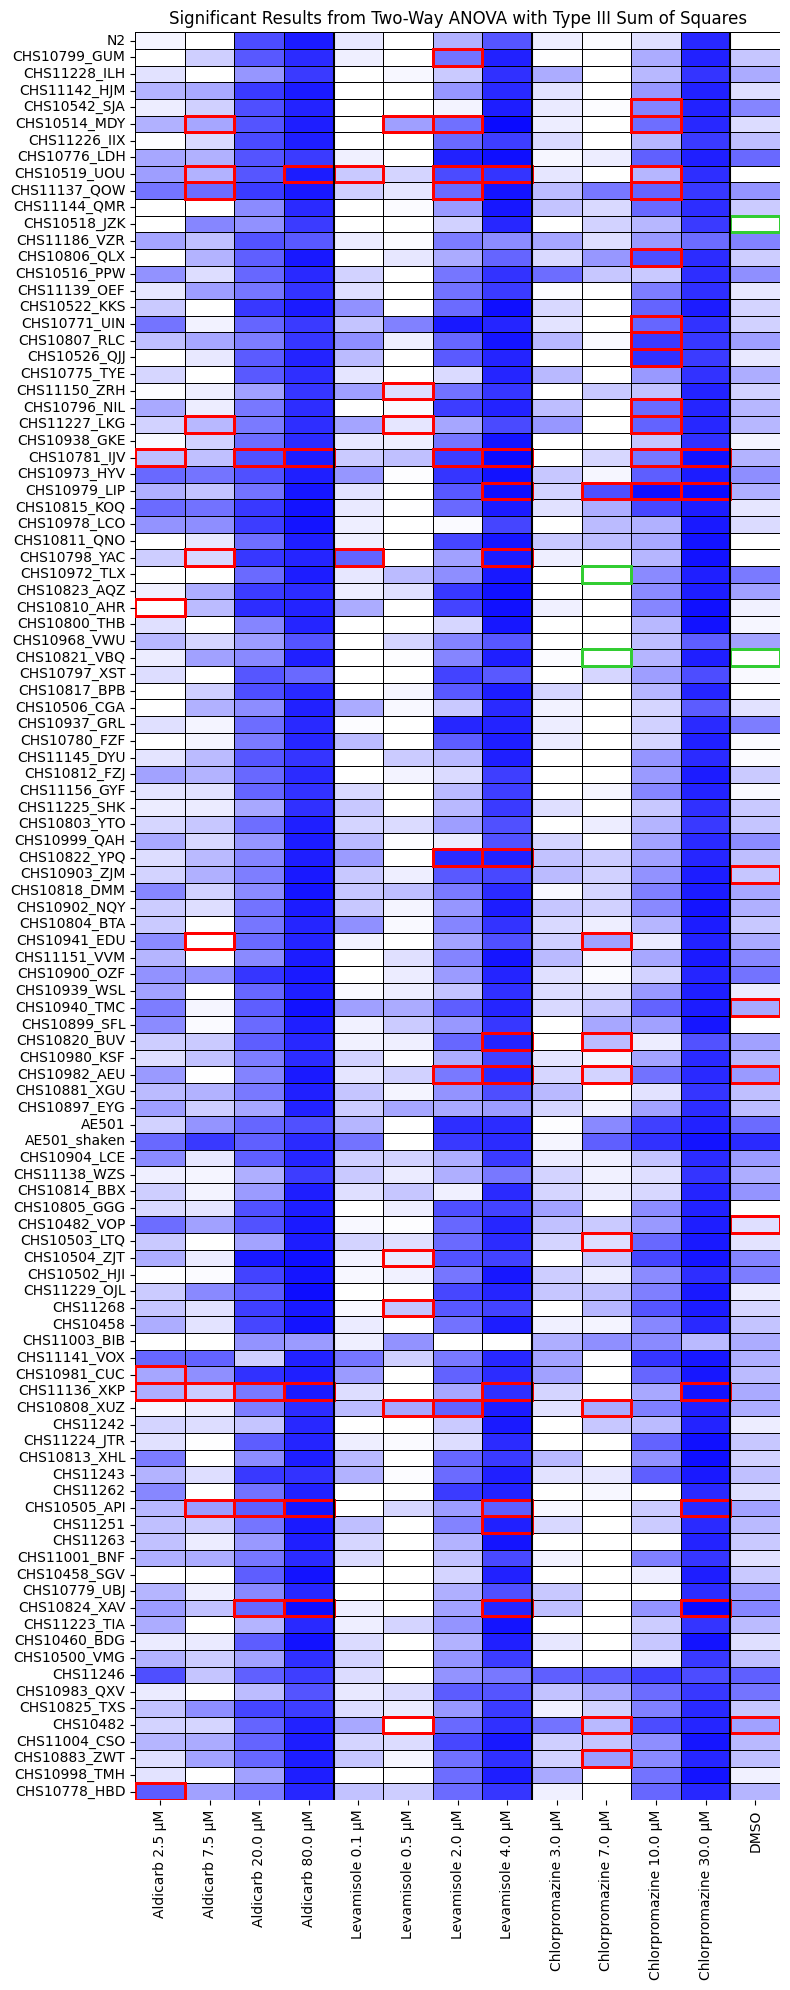

In [55]:
# Load the csv with annotations on the type of significance

type_III_sig = pd.read_csv('/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/data/statistical_analyses/all/twoway_anova/type_III_anova_result/type_III_anova_result.csv')

# Filter the df to not include the strains that in the column 'stat_sig_type' has thee string 'control difference' or 'unsure'
type_III_sig = type_III_sig[~type_III_sig['stat_sig_type'].isin(['control difference', 'unsure'])]

# Create a new column called drug_conc which combined the 'drug' and 'concentration' columns, and adds ' µM' to the end of the concentration value
type_III_sig['drug_conc'] = type_III_sig['drug'] + ' ' + type_III_sig['concentration'].astype(str) + ' µM'
# Revert the values for 'S.H2O' and 'DMSO' back to their original names
type_III_sig.loc[type_III_sig['drug'] == 'S.H2O', 'drug_conc'] = 'S.H2O'
type_III_sig.loc[type_III_sig['drug'] == 'DMSO', 'drug_conc'] = 'DMSO'

print(type_III_sig.head())


# Load the anova_results csv
anova_results = pd.read_csv('/Users/jb3623/Documents/250511_Analysis/NHR_drugs/significance/type_III_anova/anova_results.csv', encoding='latin1')
# Change the name 'drug' column to 'drug_conc' to match the type_III_sig dataframe
anova_results.rename(columns={'drug': 'drug_conc'}, inplace=True)


# Merge the two dataframes on the 'strain' and 'drug' columns and drop any rows that are not in both dataframes
merged_df = pd.merge(anova_results, type_III_sig, on=['strain', 'drug_conc'], how='inner')
print (merged_df.head())
print(merged_df.shape)



### Re-doing normalisation to include DMSO data

control_wells = {
    'Aldicarb': 'S.H2O',
    'Levamisole': 'S.H2O',
    'Chlorpromazine': 'S.H2O',
    'Ivermectin': 'DMSO',
    'S.H2O': 'S.H2O',
    'DMSO': 'S.H20'
}
df_norm = all_data_df.copy()

df_norm['control'] = df_norm['drug'].map(control_wells)


# Calculate mean pixel variance for control wells
control_values = {}
for date in df_norm['date_yyyymmdd'].unique():
    control_values[date] = {}
    for strain in df_norm['strain'].unique():
        control_values[date][strain] = {
            'S.H2O': df_norm[(df_norm['date_yyyymmdd'] == date) & 
                             (df_norm['strain'] == strain) & 
                             (df_norm['drug'] == 'S.H2O')]['value'].mean(),
            'DMSO': df_norm[(df_norm['date_yyyymmdd'] == date) & 
                            (df_norm['strain'] == strain) & 
                            (df_norm['drug'] == 'DMSO')]['value'].mean()
        }

# Function to normalize values using relative change
def normalize_value(row):
    date = row['date_yyyymmdd']
    strain = row['strain']
    if row['drug'] in ['Aldicarb', 'Levamisole', 'Chlorpromazine', 'DMSO']:
        control_value = control_values[date][strain]['S.H2O']
    elif row['drug'] == 'Ivermectin':
        control_value = control_values[date][strain]['DMSO']
    else:
        control_value = row['value']  # Use the original value if no control is found
    return (row['value']) / control_value



df_norm['normalized_value'] = df_norm.apply(normalize_value, axis=1)

# Display normalised DataFrame
print(df_norm)



# Load the data
all_data_df_stats = df_norm.copy()

# Remove rows with 'Ivermectin' in the 'drug' column from the dataset
all_data_df_stats = all_data_df_stats[all_data_df_stats['drug'] != 'Ivermectin']

# merge the 'drug' and 'concentration' columns into a single column
all_data_df_stats['drug_conc'] = all_data_df_stats['drug'] + ' ' + all_data_df_stats['concentration'].astype(str) + ' µM'
# Revert the values for 'S.H2O' and 'DMSO' back to their original names
all_data_df_stats.loc[all_data_df_stats['drug'] == 'S.H2O', 'drug_conc'] = 'S.H2O'
all_data_df_stats.loc[all_data_df_stats['drug'] == 'DMSO', 'drug_conc'] = 'DMSO'

all_merged = pd.merge(all_data_df_stats, merged_df, on=['strain', 'drug_conc'], how='left')



# Define the custom order of the drug_conc
custom_order = [
    'Aldicarb 2.5 µM',
    'Aldicarb 7.5 µM',
    'Aldicarb 20.0 µM',
    'Aldicarb 80.0 µM',
    'Levamisole 0.1 µM',
    'Levamisole 0.5 µM',
    'Levamisole 2.0 µM',
    'Levamisole 4.0 µM',
    'Chlorpromazine 3.0 µM',
    'Chlorpromazine 7.0 µM',
    'Chlorpromazine 10.0 µM',
    'Chlorpromazine 30.0 µM',
    'DMSO'
    ]


# Make sure that the strain 'N2' is at the top of the list
all_merged['strain'] = pd.Categorical(
    all_merged['strain'], 
    categories=['N2'] + [strain for strain in all_merged['strain'].unique() if strain != 'N2'], 
    ordered=True
)

# Create the pivot table
pivot_table = all_merged.pivot_table(index='strain', columns='drug_conc', values='normalized_value', aggfunc='first')

# Reorder the columns of the pivot table based on the custom order
pivot_table = pivot_table[custom_order]



# Define the custom colormap
colors = [(0, 'blue'), (1, 'white')]  # Blue for minimum, White for maximum
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)



import matplotlib.patches as patches

# Filter rows in 'all_merged' where 'stat_sig_type' is 'mutant gain' or 'mutant sensitive'
filtered_rows = all_merged[
    all_merged['stat_sig_type'].isin(['mutant gain', 'mutant sensitive'])
]

# Make a heatmap of all the results
plt.figure(figsize=(8, 20))
sns.heatmap(
    pivot_table,
    annot=False, fmt='.2f', cmap=custom_cmap, cbar=False,
    linewidths=0.5, linecolor='black',
    vmin=0, vmax=1,  # Set the limits for the color scale
    annot_kws={"size": 8, "weight": "bold"}
)

# Add black vertical lines between every fourth drug
for i in range(4, len(pivot_table.columns), 4):  # Iterate over column indices
    plt.axvline(x=i, color='black', linestyle='-', linewidth=1.5)

# Draw boxes around cells based on 'stat_sig_type'
for _, row in filtered_rows.iterrows():
    strain = row['strain']  # Extract the 'strain' value
    drug_conc = row['drug_conc']  # Extract the 'drug_conc' value
    stat_sig_type = row['stat_sig_type']  # Extract the 'stat_sig_type' value

    # Match the strain and drug_conc with the pivot_table
    if strain in pivot_table.index and drug_conc in pivot_table.columns:
        row_pos = pivot_table.index.get_loc(strain)  # Get numerical position of the strain
        col_pos = pivot_table.columns.get_loc(drug_conc)  # Get numerical position of the drug_conc

        # Determine the color based on 'stat_sig_type'
        if stat_sig_type == 'mutant gain':
            color = 'limegreen'
        elif stat_sig_type == 'mutant sensitive':
            color = 'red'

        # Add a rectangle around the matched cell
        plt.gca().add_patch(
            patches.Rectangle(
                (col_pos, row_pos), 1, 1,  # Position and size of the rectangle
                fill=False, edgecolor=color, linewidth=2
            )
        )

plt.title('Significant Results from Two-Way ANOVA with Type III Sum of Squares')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
plt.close()



## Plotting the data and the significance for strains that are more sensitive to several of the drugs compared to N2

Strains to plot: CHS11227_LKG, CHS11137_QOW, CHS10808_XUZ, CHS10979_LIP



Analyzing strain: CHS11227_LKG

Analyzing drug: Aldicarb 7.5 µM

Significant interaction effect found for CHS11227_LKG with Aldicarb 7.5 µM:
               sum_sq    df          F    PR(>F)
strain       0.000754   1.0  11.943172  0.001897
drug         0.000456   1.0   7.230806  0.012343
strain:drug  0.000329   1.0   5.218753  0.030751
Residual     0.001641  26.0        NaN       NaN

Analyzing drug: Levamisole 0.5 µM

Significant interaction effect found for CHS11227_LKG with Levamisole 0.5 µM:
               sum_sq    df          F    PR(>F)
strain       0.000747   1.0  12.379636  0.001618
drug         0.000017   1.0   0.288172  0.595958
strain:drug  0.000321   1.0   5.311713  0.029423
Residual     0.001569  26.0        NaN       NaN

Analyzing drug: Chlorpromazine 10.0 µM

Significant interaction effect found for CHS11227_LKG with Chlorpromazine 10.0 µM:
               sum_sq    df          F    PR(>F)
strain       0.001080   1.0  17.072513  0.000331
drug         0.001581   1.0  24.

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_22907/159833316.py:163: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


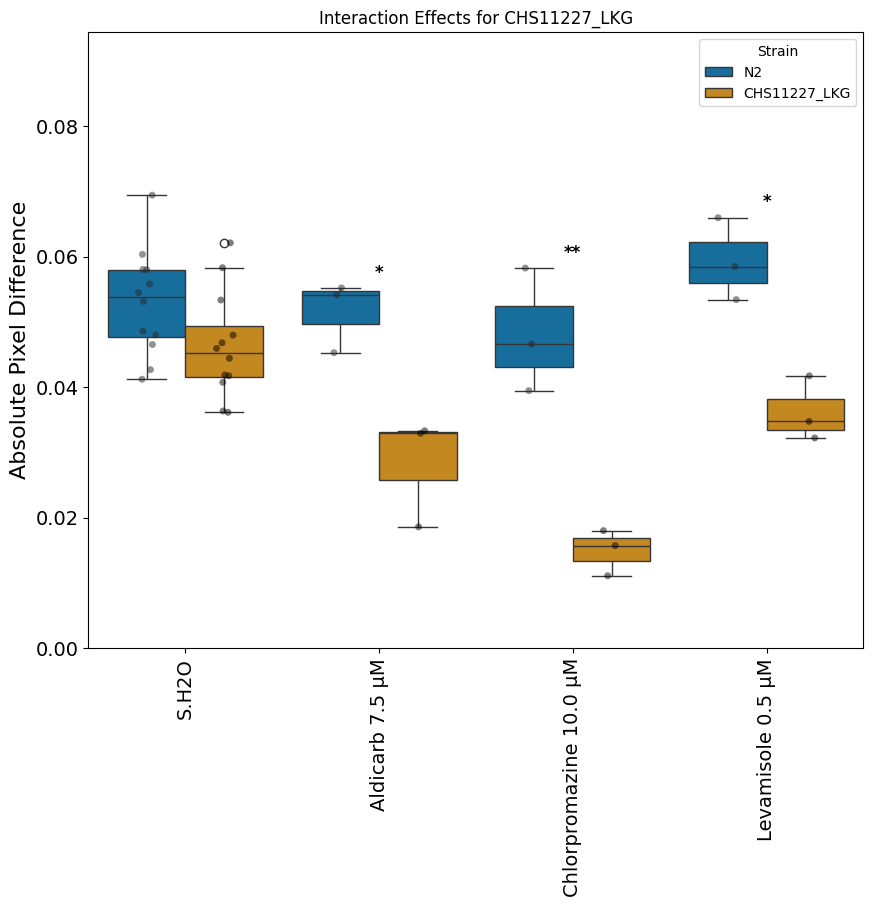


Analyzing strain: CHS11137_QOW

Analyzing drug: Aldicarb 7.5 µM

Significant interaction effect found for CHS11137_QOW with Aldicarb 7.5 µM:
               sum_sq    df          F    PR(>F)
strain       0.000953   1.0  12.295760  0.001668
drug         0.001431   1.0  18.464657  0.000215
strain:drug  0.001198   1.0  15.460152  0.000558
Residual     0.002015  26.0        NaN       NaN

Analyzing drug: Levamisole 2.0 µM

Significant interaction effect found for CHS11137_QOW with Levamisole 2.0 µM:
               sum_sq    df          F    PR(>F)
strain       0.000594   1.0   8.271542  0.007935
drug         0.002783   1.0  38.725156  0.000001
strain:drug  0.000468   1.0   6.515800  0.016910
Residual     0.001868  26.0        NaN       NaN

Analyzing drug: Chlorpromazine 10.0 µM

Significant interaction effect found for CHS11137_QOW with Chlorpromazine 10.0 µM:
               sum_sq    df          F    PR(>F)
strain       0.000604   1.0   7.776840  0.009767
drug         0.001076   1.0  13.

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_22907/159833316.py:163: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


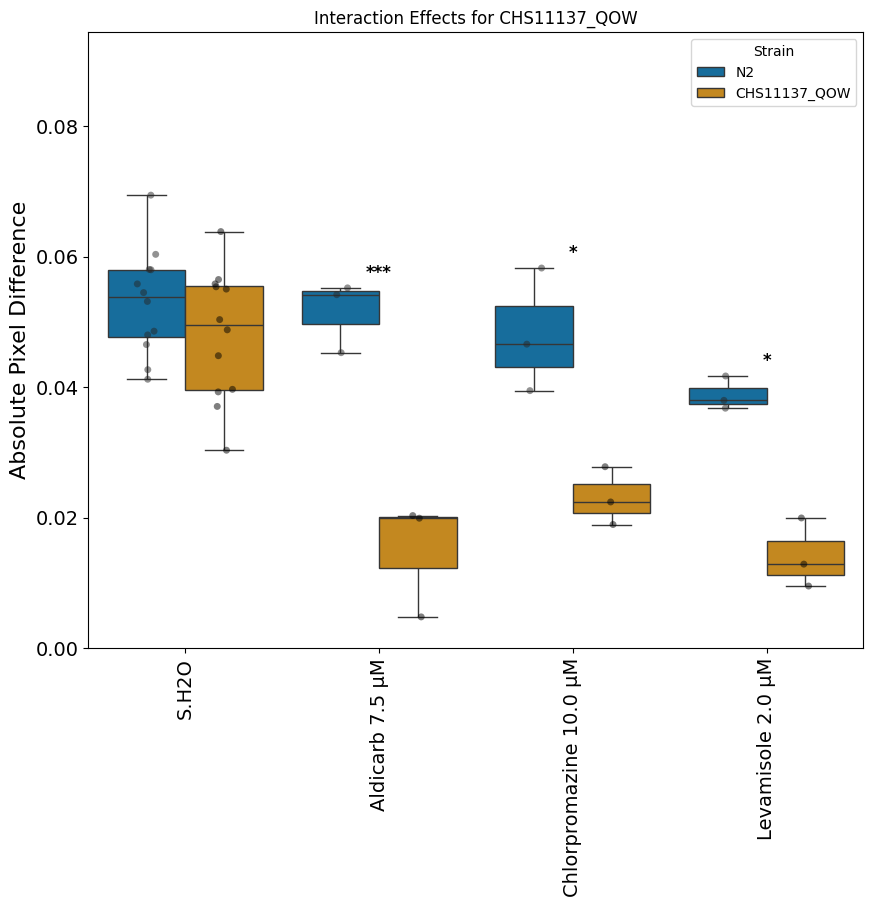


Analyzing strain: CHS10808_XUZ

Analyzing drug: Levamisole 0.5 µM

Significant interaction effect found for CHS10808_XUZ with Levamisole 0.5 µM:
               sum_sq    df          F    PR(>F)
strain       0.000038   1.0   0.752775  0.393537
drug         0.000001   1.0   0.028239  0.867848
strain:drug  0.000688   1.0  13.522822  0.001078
Residual     0.001324  26.0        NaN       NaN

Analyzing drug: Levamisole 2.0 µM

Significant interaction effect found for CHS10808_XUZ with Levamisole 2.0 µM:
               sum_sq    df          F        PR(>F)
strain       0.000003   1.0   0.051015  8.230725e-01
drug         0.002667   1.0  53.656119  8.864339e-08
strain:drug  0.000290   1.0   5.843286  2.294957e-02
Residual     0.001292  26.0        NaN           NaN

Analyzing drug: Chlorpromazine 7.0 µM

Significant interaction effect found for CHS10808_XUZ with Chlorpromazine 7.0 µM:
               sum_sq    df         F    PR(>F)
strain       0.000011   1.0  0.214339  0.647239
drug        

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_22907/159833316.py:163: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


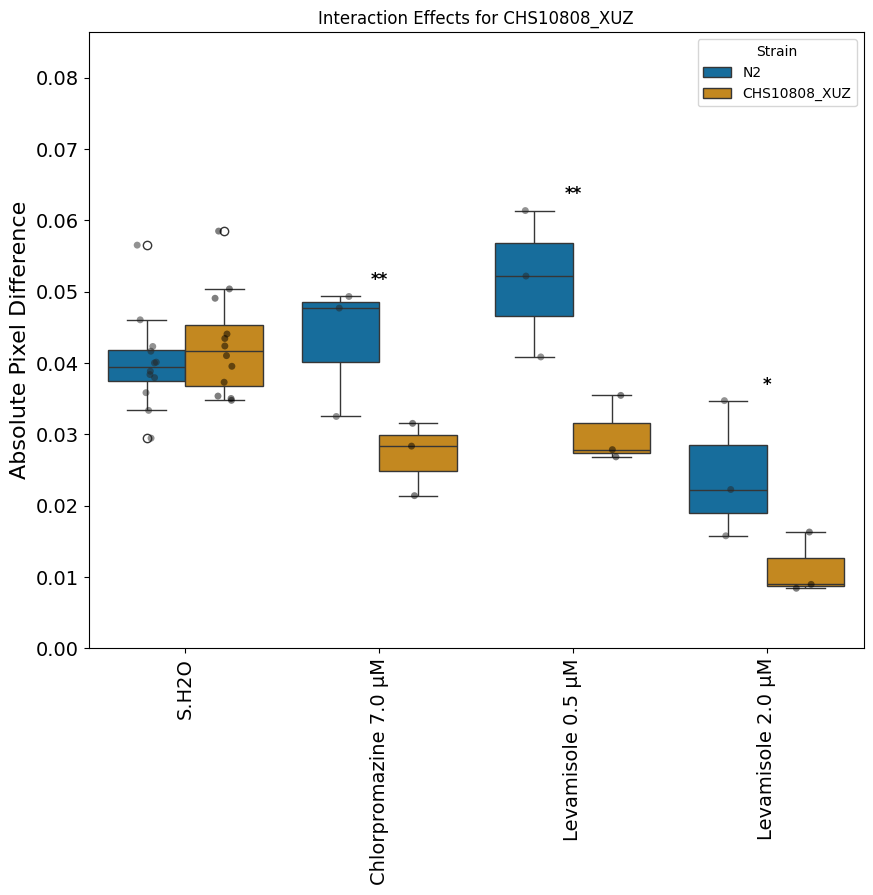


Analyzing strain: CHS10979_LIP

Analyzing drug: Levamisole 4.0 µM

Significant interaction effect found for CHS10979_LIP with Levamisole 4.0 µM:
               sum_sq    df           F        PR(>F)
strain       0.000451   1.0    7.963819  9.025069e-03
drug         0.008206   1.0  144.992102  3.884345e-12
strain:drug  0.000373   1.0    6.598993  1.629322e-02
Residual     0.001472  26.0         NaN           NaN

Analyzing drug: Chlorpromazine 7.0 µM

Significant interaction effect found for CHS10979_LIP with Chlorpromazine 7.0 µM:
               sum_sq    df          F    PR(>F)
strain       0.000124   1.0   2.274638  0.143562
drug         0.002079   1.0  38.218311  0.000002
strain:drug  0.001563   1.0  28.737260  0.000013
Residual     0.001414  26.0        NaN       NaN

Analyzing drug: Chlorpromazine 10.0 µM

Significant interaction effect found for CHS10979_LIP with Chlorpromazine 10.0 µM:
               sum_sq    df          F        PR(>F)
strain       0.000180   1.0   2.954181  

/var/folders/bz/jhtqqpy107ldkxyhp5pv18n40000gq/T/ipykernel_22907/159833316.py:163: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


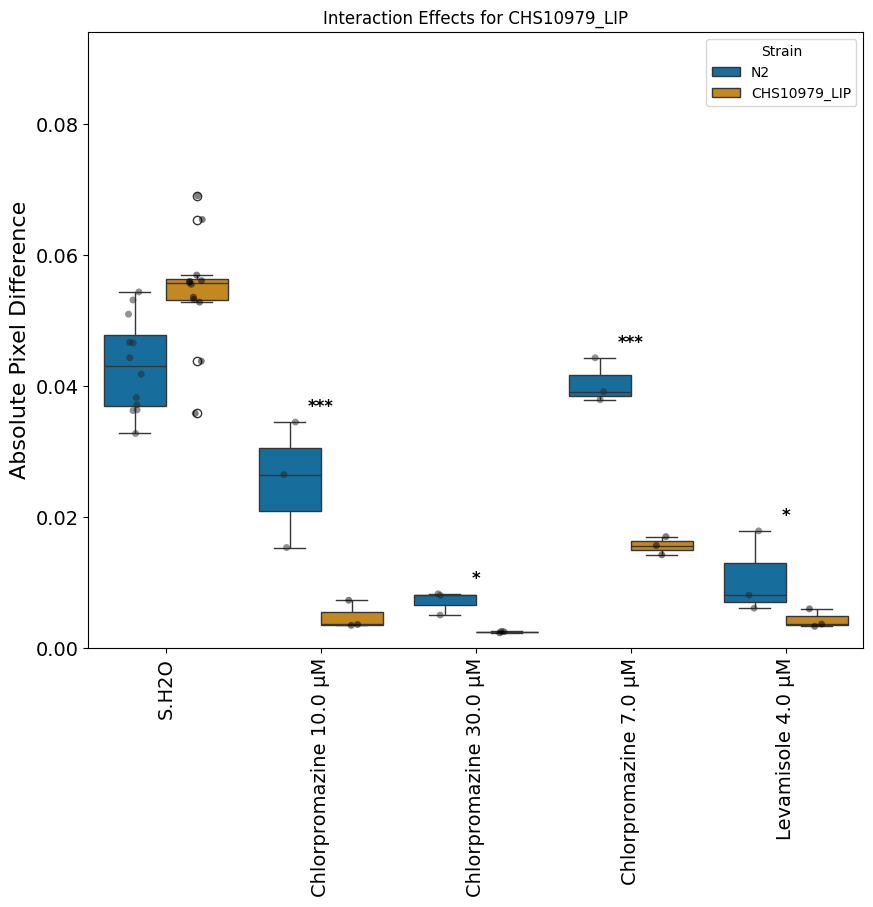

In [66]:
import pandas as pd
import os
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Ensure the directory exists
output_dir = '/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/pixel_variance/all/two-way_ANOVA/multi_drug_sensitivity'
os.makedirs(output_dir, exist_ok=True)

all_data_df_stats = all_data_df.copy()

# Remove rows with 'Ivermectin' in the 'drug' column from the dataset
all_data_df_stats = all_data_df_stats[all_data_df_stats['drug'] != 'Ivermectin']


# merge the 'drug' and 'concentration' columns into a single column
all_data_df_stats['drug_conc'] = all_data_df_stats['drug'] + ' ' + all_data_df_stats['concentration'].astype(str) + ' µM'
# Revert the values for 'S.H2O' and 'DMSO' back to their original names
all_data_df_stats.loc[all_data_df_stats['drug'] == 'S.H2O', 'drug_conc'] = 'S.H2O'
all_data_df_stats.loc[all_data_df_stats['drug'] == 'DMSO', 'drug_conc'] = 'DMSO'

# Define the control strain
control_strain = 'N2'
control_wells = 'S.H2O'

# Function to determine the significance stars
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return ''

# Create a dictionary to map strains to their corresponding drug concentrations
strain_drug_conc_map = {
    'CHS11227_LKG': ['S.H2O', 'Aldicarb 7.5 µM', 'Levamisole 0.5 µM', 'Chlorpromazine 10.0 µM'],
    'CHS11137_QOW': ['S.H2O', 'Aldicarb 7.5 µM', 'Levamisole 2.0 µM', 'Chlorpromazine 10.0 µM'],
    'CHS10808_XUZ': ['S.H2O', 'Levamisole 0.5 µM', 'Levamisole 2.0 µM', 'Chlorpromazine 7.0 µM'],
    'CHS10979_LIP': ['S.H2O', 'Levamisole 4.0 µM', 'Chlorpromazine 7.0 µM', 'Chlorpromazine 10.0 µM', 'Chlorpromazine 30.0 µM']
}

# Filter the data for each strain based on the mapping
def filter_strain_and_control(data, strain_map, control_strain):
    dfs = []
    for strain, drug_list in strain_map.items():
        strain_df = data[(data['strain'] == strain) & (data['drug_conc'].isin(drug_list))].copy()
        strain_df['target_strain'] = strain

        control_df = data[
            (data['strain'] == control_strain) &
            (data['drug_conc'].isin(drug_list)) &
            (data['date_yyyymmdd'].isin(strain_df['date_yyyymmdd']))
        ].copy()
        control_df['target_strain'] = strain  # Tag which strain this control is paired with

        dfs.extend([strain_df, control_df])
    return pd.concat(dfs, ignore_index=True)

combined_df = filter_strain_and_control(all_data_df_stats, strain_drug_conc_map, control_strain)

unique_strains = combined_df['strain'].unique()
uniuqe_strains = [strain for strain in unique_strains if strain != control_strain]
unique_drugs = combined_df['drug_conc'].unique()


# Ensure the control strain data is included in the combined dataset
anova_results = []
for strain, drug_conc_list in strain_drug_conc_map.items():
    print(f"\nAnalyzing strain: {strain}")

    # Filter data for the current strain
    strain_data = combined_df[combined_df['strain'] == strain]

    # Filter control strain data for matching drug concentrations
    n2_data = combined_df[
        (combined_df['strain'] == control_strain) &
        (combined_df['drug_conc'].isin(drug_conc_list)) &
        (combined_df['date_yyyymmdd'].isin(strain_data['date_yyyymmdd']) &
        combined_df['target_strain'].isin([strain]))
    ]

    # Combine the strain data and N2 data
    combined_data = pd.concat([strain_data, n2_data])

    # Initialize a list to store significance markers
    significance_markers = []

    # Perform ANOVA for each drug concentration
    for drug in drug_conc_list:
        if drug == control_wells:
            continue

        print(f"\nAnalyzing drug: {drug}")

        # Filter the combined data for the current drug
        drug_data = combined_data[combined_data['drug_conc'] == drug]

        control_treatment = combined_data[combined_data['drug_conc'] == control_wells]

        drug_data = pd.concat([drug_data, control_treatment])

        # Ensure both strains are present and have sufficient replicates
        strains_in_data = drug_data['strain'].unique()

        if control_strain not in strains_in_data or strain not in strains_in_data:
            print(f"Skipping {drug} — missing data for one or both strains.")
            continue

        if (drug_data['strain'] == strain).sum() < 2 or (drug_data['strain'] == control_strain).sum() < 2:
            print(f"Skipping {drug} — not enough replicates for one or both strains.")
            continue

        # Perform ANOVA
        model = ols('value ~ strain * drug', data=drug_data).fit()
        try:
            anova_results = sm.stats.anova_lm(model, typ=2)
        except ValueError as e:
            print(f"ANOVA failed for {drug}: {e}")
            continue

        if 'strain:drug' in anova_results.index and anova_results.loc['strain:drug', 'PR(>F)'] < 0.05:
            print(f"\nSignificant interaction effect found for {strain} with {drug}:")
            print(anova_results)

            # Add significance marker for this drug
            significance_markers.append({
                'drug': drug,
                'p_value': anova_results.loc['strain:drug', 'PR(>F)']
            })

    # Generate a single plot for all drug concentrations
    plt.figure(figsize=(10, 8))

    # Ensure 'S.H2O' is the first in the order
    drug_order = sorted(combined_data['drug_conc'].unique(), key=lambda x: str(x))
    if 'S.H2O' in drug_order:
        drug_order.remove('S.H2O')
        drug_order.insert(0, 'S.H2O')  # Place 'S.H2O' at the beginning
    
    hue_order = [control_strain, strain]

    sns.boxplot(
        x='drug_conc',
        y='value', 
        hue='strain', 
        data=combined_data, 
        palette='colorblind', 
        order=drug_order,
        hue_order=hue_order
    )

    sns.stripplot(
        data=combined_data,
        x='drug_conc',
        y='value',
        hue='strain',
        color='black',
        hue_order=[control_strain, strain],
        dodge=True,
        alpha=0.5,
        jitter=True,
        legend=False
    )

    plt.title(f"Interaction Effects for {strain}")
    plt.xlabel('')
    plt.ylabel('Absolute Pixel Difference', fontsize = 16)
    plt.legend(title='Strain')
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=14)

    # Calculate the maximum y-value across all datasets
    max_y_value = combined_data['value'].max()
    extra_space = 0.005
    plt.ylim(0, max_y_value + extra_space + 0.02)

    # Add significance markers
    for marker in significance_markers:
        stars = get_significance_stars(marker['p_value'])
        if stars:
            # Find the x-coordinate of the boxplot corresponding to the drug concentration
            drug = marker['drug']
            x_positions = drug_order  # Use the explicitly ordered drug concentrations
            x = x_positions.index(drug)  # Get the index of the current drug concentration

            # Filter the data for the current drug concentration
            drug_data = combined_data[combined_data['drug_conc'] == drug]

            # Calculate the maximum y-value for the current drug concentration
            max_box_height = drug_data['value'].max()

            # Add an offset to position the significance marker above the boxplot
            y = max_box_height + 0.001  # Adjust the offset as needed

            # Add the significance stars above the boxplot
            plt.text(
                x, y, stars,
                ha='center', va='bottom', color='black', fontsize=12, weight='bold'
            )

    # Save the plot
    plot_filename = f"{strain}_interaction_plot.png".replace('/', '_')
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    plt.show()  # Show the plot
    plt.close()


#### Not working stat analysis below

In [6]:
# Splitting the dataset into four different datasets based on the concentration of the drugs (lowest, low, high, highest)

df_norm_stat = df_norm.copy()
# Reomve the control wells from the dataframe
df_norm_stat = df_norm_stat[(df_norm_stat['drug'] != 'S.H2O') & (df_norm_stat['drug'] != 'DMSO')]

df_norm_stat['concentration'] = df_norm_stat['concentration'].astype(float)

# Initialize lists for each concentration category
lowest_list = []
low_list = []
high_list = []
highest_list = []

for drug in df_norm_stat['drug'].unique():
    drug_data = df_norm_stat[df_norm_stat['drug'] == drug]
    concentration_ranges = pd.qcut(drug_data['concentration'], 4, labels=['lowest', 'low', 'high', 'highest'])
    for concentration in concentration_ranges.unique():
        if concentration == 'lowest':
            lowest_list.append(drug_data[concentration_ranges == concentration])
        elif concentration == 'low':
            low_list.append(drug_data[concentration_ranges == concentration])
        elif concentration == 'high':
            high_list.append(drug_data[concentration_ranges == concentration])
        elif concentration == 'highest':
            highest_list.append(drug_data[concentration_ranges == concentration])

# Concatenate the lists into single dataframes for each concentration category
lowest_df = pd.concat(lowest_list)
low_df = pd.concat(low_list)
high_df = pd.concat(high_list)
highest_df = pd.concat(highest_list)



In [7]:
## Two-way ANOVA with drug as a fixed effect - All data (All N2 data across the days combined)

import statsmodels.formula.api as smf
import statsmodels.api as sm
from IPython.display import display

# List of dataframes to analyze
dataframes = [lowest_df, low_df, high_df, highest_df]
results = {}

for df, name in zip(dataframes, ['lowest', 'low', 'high', 'highest']):
    df_stat = df.copy()

    # Remove the control wells from the dataframe
    df_stat = df_stat[(df_stat['drug'] != 'S.H2O') & (df_stat['drug'] != 'DMSO')]

    # Convert categorical variables
    df_stat['strain'] = df_stat['strain'].astype('category')
    df_stat['drug'] = df_stat['drug'].astype('category')
    df_stat['concentration'] = df_stat['concentration'].astype('category')

    # Define an even more complex ANOVA model with Drug as a fixed effect
    model = smf.ols('normalized_value ~ strain + drug + concentration + strain:drug:concentration', data=df_stat).fit()

    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA (common for factorial designs)

    # Store results
    results[name] = anova_table

    # Display results
    print(f"ANOVA results for {name} dataframe:")
    display(anova_table)

/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 105, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 0
  warnings.warn('covariance of constraints does 

ANOVA results for lowest dataframe:


/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2007, but rank is 3
  warnings.warn('covariance of constraints does not have full '


sum_sq      df         F    PR(>F)
strain                           NaN   105.0       NaN       NaN
drug                             NaN     3.0       NaN       NaN
concentration                    NaN     4.0       NaN       NaN
strain:drug:concentration  35.341821  2007.0  0.481136  0.695461
Residual                   39.454091  1078.0       NaN       NaN

/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 105, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does 

ANOVA results for low dataframe:


/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1584, but rank is 4
  warnings.warn('covariance of constraints does not have full '


sum_sq      df        F    PR(>F)
strain                           NaN   105.0      NaN       NaN
drug                             NaN     3.0      NaN       NaN
concentration                    NaN     3.0      NaN       NaN
strain:drug:concentration  83.404843  1584.0  1.82822  0.121451
Residual                   21.946370   762.0      NaN       NaN

ANOVA results for high dataframe:


/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 105, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does 

sum_sq     df         F    PR(>F)
strain                          NaN  105.0       NaN       NaN
drug                            NaN    1.0       NaN       NaN
concentration                   NaN    1.0       NaN       NaN
strain:drug:concentration  3.761263  316.0  0.607825  0.544989
Residual                   8.655469  442.0       NaN       NaN

/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 105, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1923: RuntimeWarning: invalid value encountered in divide
  F /= J
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 0
  warnings.warn('covariance of constraints does 

ANOVA results for highest dataframe:


/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1584, but rank is 2
  warnings.warn('covariance of constraints does not have full '


sum_sq      df         F    PR(>F)
strain                           NaN   105.0       NaN       NaN
drug                             NaN     3.0       NaN       NaN
concentration                    NaN     3.0       NaN       NaN
strain:drug:concentration  10.357727  1584.0  1.766547  0.171621
Residual                    2.820585   762.0       NaN       NaN

In [23]:
# Multiple t-tests with bonferroni correction (All N2 data across the days combined)

import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

df_norm_stat = df_norm.copy()

# Store results
results_list = []

# Get unique drugs and concentrations
unique_drugs = df_norm_stat['drug'].unique()
unique_concentrations = df_norm_stat['concentration'].unique()

# Loop through each drug and concentration
for drug in unique_drugs:
    for concentration in unique_concentrations:
        # Subset data for the current drug and concentration
        df_subset = df_norm_stat[(df_norm_stat['drug'] == drug) & (df_norm_stat['concentration'] == concentration)]

        # Get unique strains excluding N2
        mutant_strains = df_subset['strain'].unique()
        mutant_strains = [strain for strain in mutant_strains if strain != 'N2']

        p_values = []  # Store p-values for correction

        # Loop through each mutant and compare to N2 for the current drug and concentration
        for mutant in mutant_strains:
            # Get data for N2 and mutant on the current drug and concentration
            n2_data = df_subset[df_subset['strain'] == 'N2']['normalized_value']
            mutant_data = df_subset[df_subset['strain'] == mutant]['normalized_value']

            # Perform t-test
            t_stat, p_value = stats.ttest_ind(n2_data, mutant_data, equal_var=False, nan_policy='omit')
            p_values.append(p_value)

            # Store raw result
            results_list.append({
                'drug': drug,
                'concentration': concentration,
                'strain': mutant,
                't_stat': t_stat,
                'p_value': p_value
            })

        # Apply Bonferroni correction for all comparisons within this drug-concentration group
        if len(p_values) > 0:
            corrected_p = multipletests(p_values, method='bonferroni')[1]

            # Update results with corrected p-values
            for i, mutant in enumerate(mutant_strains):
                results_list[-len(mutant_strains) + i]['corrected_p_value'] = corrected_p[i]

# Create a dataframe from results
results_df = pd.DataFrame(results_list)

# Add significance indicator
results_df['significant'] = results_df['corrected_p_value'] < 0.05

# Display final results
print(results_df)

results_df.to_csv(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/data/statistical_analyses/all/ttest/mutant_vs_n2_results_with_drugs_bonferroni_AllDaysCombined.csv', index=False)

# Filter the dataframe to get rows where 'significant' is True
significant_rows = results_df[results_df['significant'] == True]
print(f'Strains and drugs (concentration) with significant differences: {significant_rows}')
# number of significant results
num_significant = significant_rows.shape[0]
print(f'Number of significant results: {num_significant}')


          drug  concentration        strain    t_stat   p_value  \
0     Aldicarb            2.5  CHS10799_GUM -0.611334  0.578067   
1     Aldicarb            2.5  CHS11228_ILH  0.104325  0.923107   
2     Aldicarb            2.5  CHS11142_HJM  2.093055  0.059810   
3     Aldicarb            2.5  CHS10542_SJA -0.911734  0.406290   
4     Aldicarb            2.5  CHS10514_MDY  1.904050  0.112600   
...        ...            ...           ...       ...       ...   
1653      DMSO            0.0      CHS10482       NaN       NaN   
1654      DMSO            0.0  CHS11004_CSO       NaN       NaN   
1655      DMSO            0.0  CHS10883_ZWT       NaN       NaN   
1656      DMSO            0.0  CHS10998_TMH       NaN       NaN   
1657      DMSO            0.0  CHS10778_HBD       NaN       NaN   

      corrected_p_value  significant  
0                   1.0        False  
1                   1.0        False  
2                   1.0        False  
3                   1.0        False  


/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


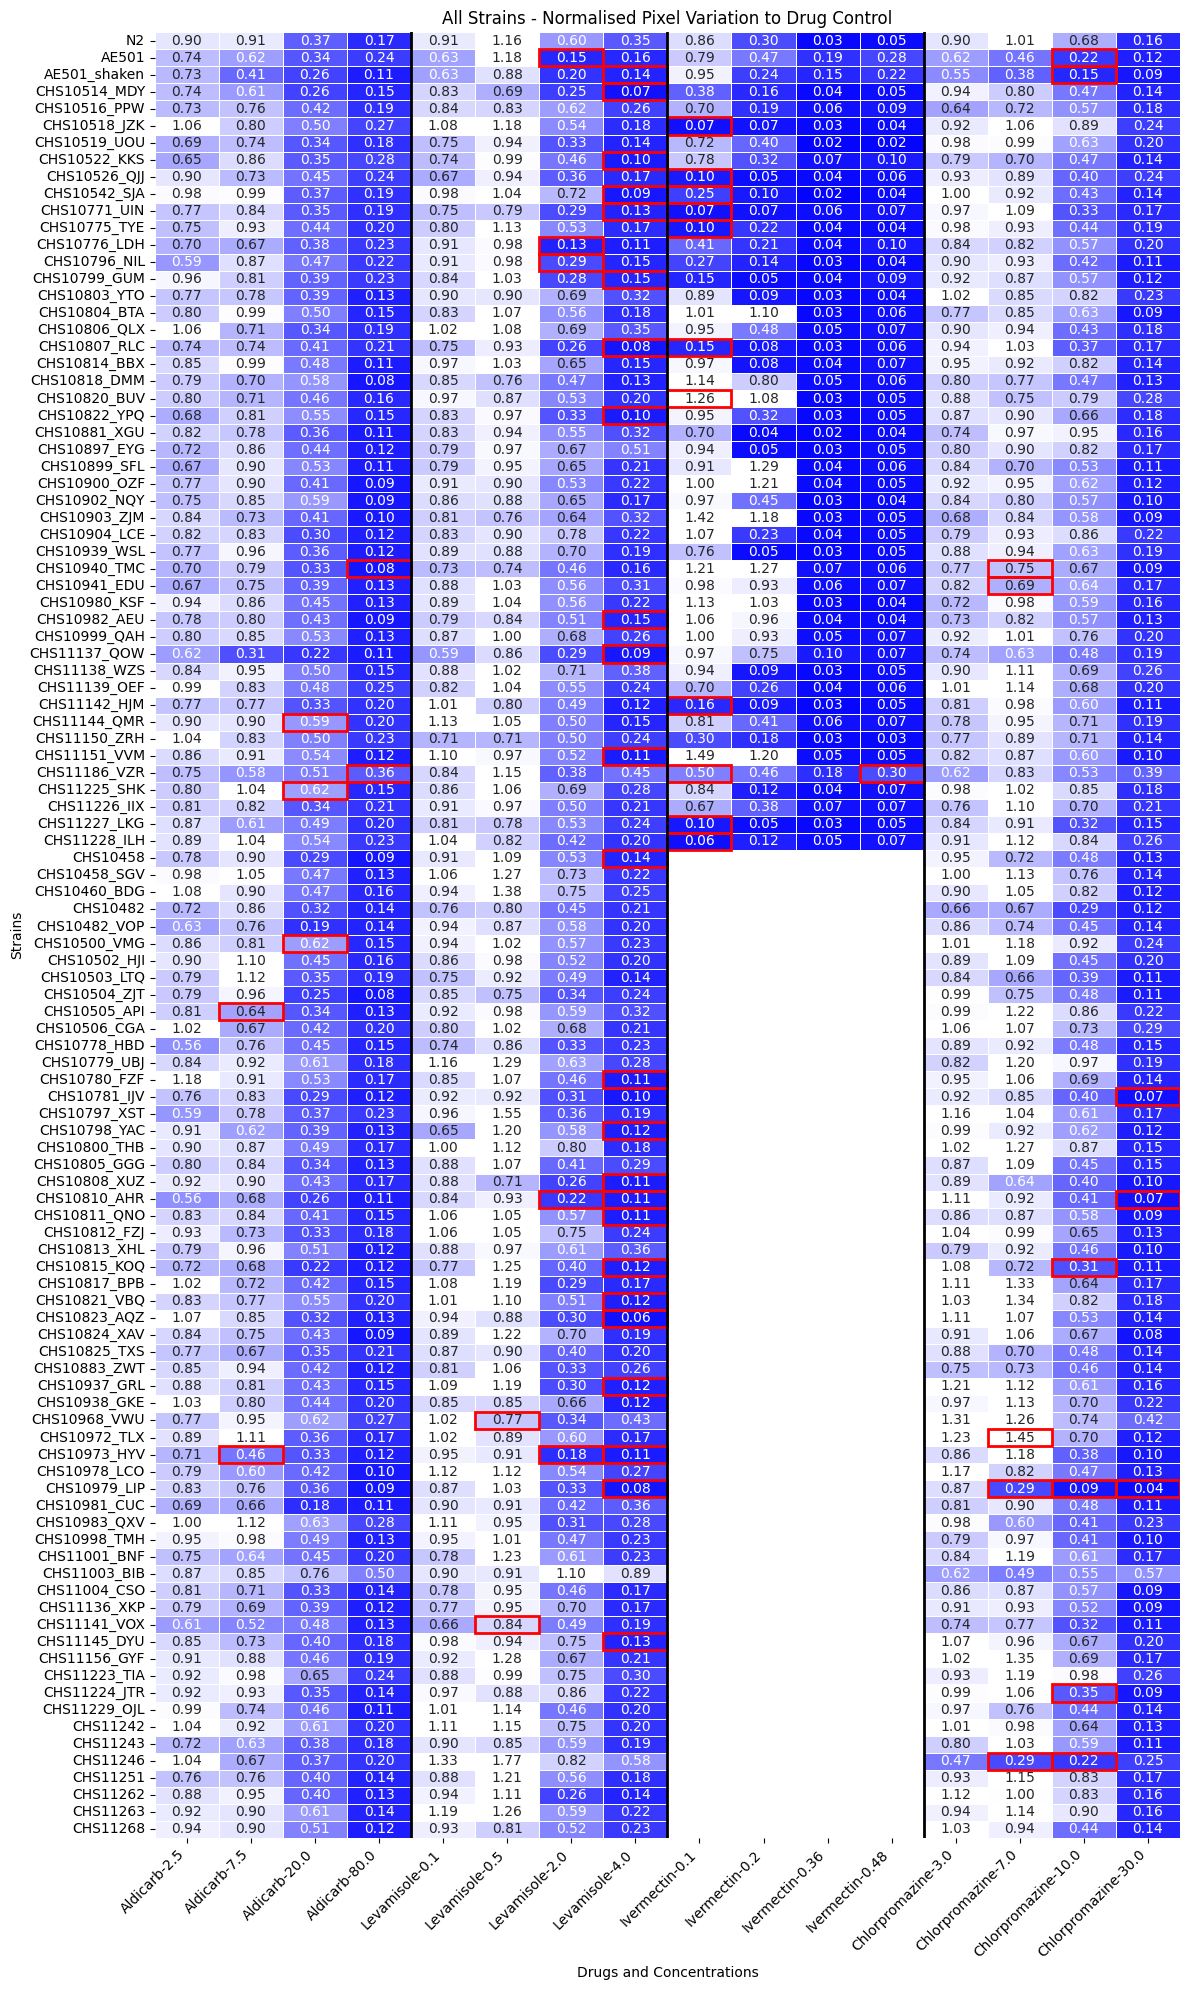

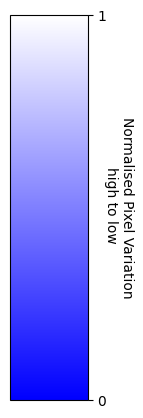

In [24]:
# heatmap with significane from multiple t-test with Bonferroni correction highlighted

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# Heatmap for normalised values 
df_pivot_norm_all = df_norm.copy()

# Pivot the DataFrame
df_pivot_norm_all = df_pivot_norm_all.pivot_table(index='strain', columns=['drug', 'concentration'], values='normalized_value')

# Flatten the multi-level column index for better readability in the heatmap
df_pivot_norm_all.columns = [f'{drug}-{concentration}' for drug, concentration in df_pivot_norm_all.columns]

# Define the custom order of the drugs
custom_order = ['Aldicarb', 'Levamisole', 'Ivermectin', 'Chlorpromazine']

# Reorder the columns based on the custom order
ordered_columns = []
for drug in custom_order:
    ordered_columns.extend([col for col in df_pivot_norm_all.columns if col.startswith(drug)])
df_pivot_norm_all = df_pivot_norm_all[ordered_columns]

# Reorder the rows to place 'N2' at the top and strains with missing values at the bottom
strains_with_missing_values = df_pivot_norm_all.index[df_pivot_norm_all.isnull().any(axis=1)].tolist()
strains_with_complete_values = df_pivot_norm_all.index.difference(strains_with_missing_values).tolist()

# Ensure 'N2' is at the top
if 'N2' in strains_with_complete_values:
    strains_with_complete_values.remove('N2')
    ordered_strains = ['N2'] + strains_with_complete_values + strains_with_missing_values
else:
    ordered_strains = strains_with_complete_values + strains_with_missing_values

df_pivot_norm_all = df_pivot_norm_all.loc[ordered_strains]

colors = [(0, 'blue'), (1, 'white')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Create a heatmap
plt.figure(figsize=(12, 20))
ax = sns.heatmap(df_pivot_norm_all, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, vmin=0, vmax=1, cbar=False)

# Customize the plot
plt.title('All Strains - Normalised Pixel Variation to Drug Control')
plt.xlabel('Drugs and Concentrations')
plt.ylabel('Strains')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Draw vertical lines between different drugs
drug_names = df_pivot_norm_all.columns
unique_drugs = df_pivot_norm_all.columns.str.split('-').str[0].unique()
for drug in unique_drugs[:-1]:  # Skip the last drug
    last_col_index = np.where(df_pivot_norm_all.columns.str.startswith(drug))[0][-1]
    ax.axvline(x=last_col_index + 1, color='black', linewidth=2)

# Highlight significant values
for _, row in results_df[results_df['significant']].iterrows():
    drug = row['drug']
    concentration = row['concentration']
    strain = row['strain']
    col_name = f'{drug}-{concentration}'
    if col_name in df_pivot_norm_all.columns and strain in df_pivot_norm_all.index:
        col_idx = df_pivot_norm_all.columns.get_loc(col_name)
        row_idx = df_pivot_norm_all.index.get_loc(strain)
        ax.add_patch(plt.Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='red', lw=2))

# Show the plot
plt.tight_layout()
plt.savefig(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/heatmap/significance/heatmap_pixelvariance_norm_sig_mttest_bonferroni_mutantVsN2_AllDaysCombined.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a color bar for the heatmap
fig, ax = plt.subplots(figsize=(1, 5))
cmap = custom_cmap
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('Normalised Pixel Variation\nhigh to low ', rotation=270, labelpad=20)
cb1.set_ticks([0, 1])
cb1.set_ticklabels(['0', '1'])

# Save the color bar
fig.savefig(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/heatmap/significance/colorbar_pixelvariance_norm.png', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
# Multiple t-tests with Benjamini-Hochberg correction (All N2 data across the days combined)

import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

df_norm_stat = df_norm.copy()

# Store results
results_list = []

# Get unique drugs and concentrations
unique_drugs = df_norm_stat['drug'].unique()
unique_concentrations = df_norm_stat['concentration'].unique()

# Loop through each drug and concentration
for drug in unique_drugs:
    for concentration in unique_concentrations:
        # Subset data for the current drug and concentration
        df_subset = df_norm_stat[(df_norm_stat['drug'] == drug) & (df_norm_stat['concentration'] == concentration)]

        # Get unique strains excluding N2
        mutant_strains = df_subset['strain'].unique()
        mutant_strains = [strain for strain in mutant_strains if strain != 'N2']

        p_values = []  # Store p-values for correction

        # Loop through each mutant and compare to N2 for the current drug and concentration
        for mutant in mutant_strains:
            # Get data for N2 and mutant on the current drug and concentration
            n2_data = df_subset[df_subset['strain'] == 'N2']['normalized_value']
            mutant_data = df_subset[df_subset['strain'] == mutant]['normalized_value']

            # Perform t-test
            t_stat, p_value = stats.ttest_ind(n2_data, mutant_data, equal_var=False, nan_policy='omit')
            p_values.append(p_value)

            # Store raw result
            results_list.append({
                'drug': drug,
                'concentration': concentration,
                'strain': mutant,
                't_stat': t_stat,
                'p_value': p_value
            })

        # Apply Benjamini-Hochberg correction for all comparisons within this drug-concentration group
        if len(p_values) > 0:
            corrected_p = multipletests(p_values, method='fdr_bh')[1]

            # Update results with corrected p-values
            for i, mutant in enumerate(mutant_strains):
                results_list[-len(mutant_strains) + i]['corrected_p_value'] = corrected_p[i]

# Create a dataframe from results
results_df = pd.DataFrame(results_list)

# Add significance indicator
results_df['significant'] = results_df['corrected_p_value'] < 0.05

# Display final results
print(results_df)

results_df.to_csv(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/data/statistical_analyses/all/ttest/mutant_vs_n2_results_with_drugs_2_benjamini-hochberg_AllDaysCombined.csv', index=False)

# Filter the dataframe to get rows where 'significant' is True
significant_rows = results_df[results_df['significant'] == True]
print(f'Strains and drugs (concentration) with significant differences: {significant_rows}')
# number of significant results
num_significant = significant_rows.shape[0]
print(f'Number of significant results: {num_significant}')

          drug  concentration        strain    t_stat   p_value  \
0     Aldicarb            2.5  CHS10799_GUM -0.611334  0.578067   
1     Aldicarb            2.5  CHS11228_ILH  0.104325  0.923107   
2     Aldicarb            2.5  CHS11142_HJM  2.093055  0.059810   
3     Aldicarb            2.5  CHS10542_SJA -0.911734  0.406290   
4     Aldicarb            2.5  CHS10514_MDY  1.904050  0.112600   
...        ...            ...           ...       ...       ...   
1653      DMSO            0.0      CHS10482       NaN       NaN   
1654      DMSO            0.0  CHS11004_CSO       NaN       NaN   
1655      DMSO            0.0  CHS10883_ZWT       NaN       NaN   
1656      DMSO            0.0  CHS10998_TMH       NaN       NaN   
1657      DMSO            0.0  CHS10778_HBD       NaN       NaN   

      corrected_p_value  significant  
0              0.841926        False  
1              0.981068        False  
2              0.569307        False  
3              0.773076        False  


/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


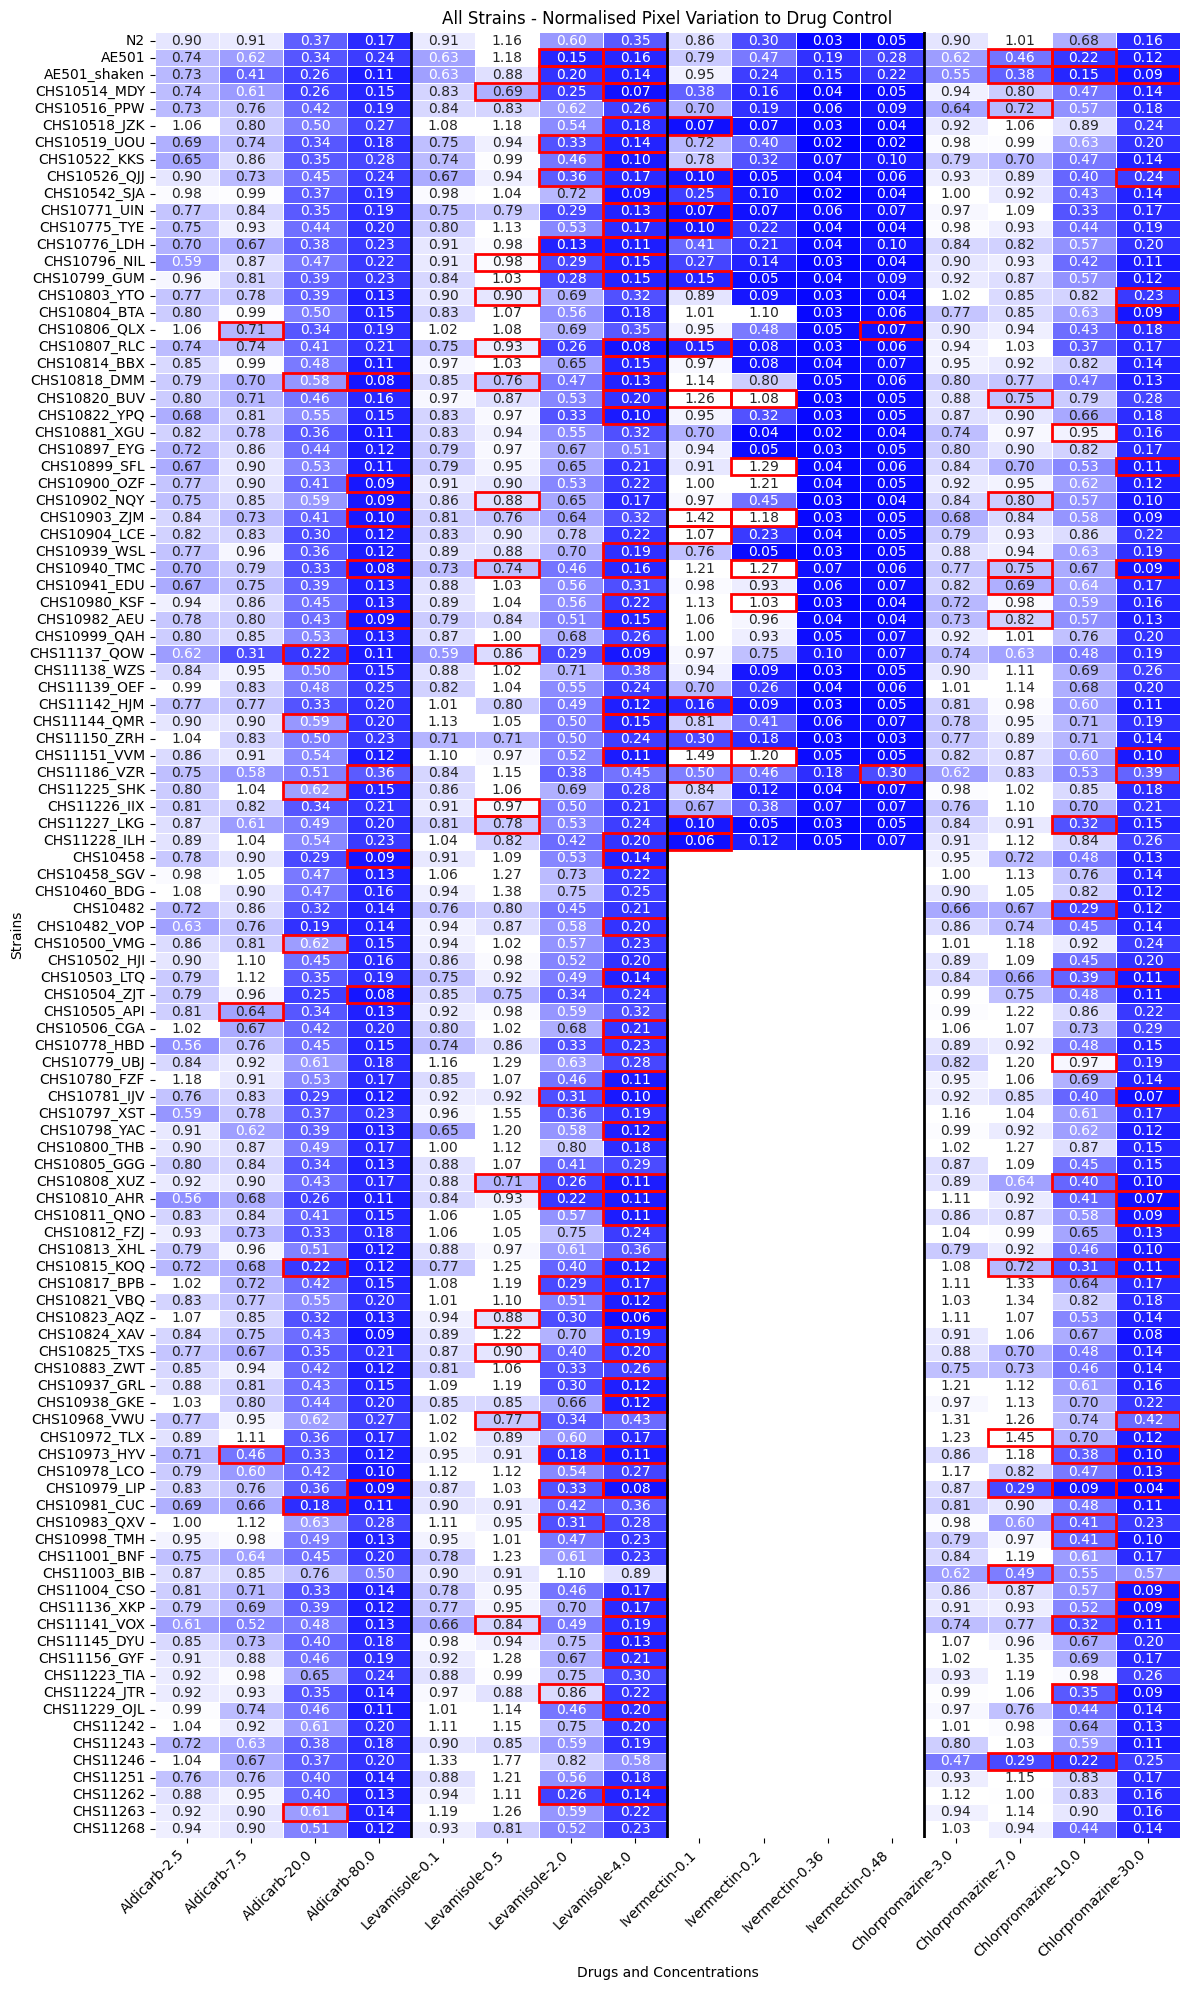

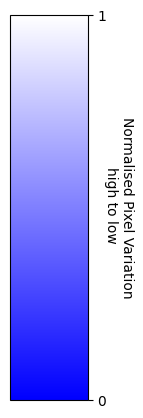

In [27]:
# heatmap with significane from Multiple t-tests with Benjamini-Hochberg correction highlighted - All N2s across the days combined

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# Heatmap for normalised values 
df_pivot_norm_all = df_norm.copy()

# Pivot the DataFrame
df_pivot_norm_all = df_pivot_norm_all.pivot_table(index='strain', columns=['drug', 'concentration'], values='normalized_value')

# Flatten the multi-level column index for better readability in the heatmap
df_pivot_norm_all.columns = [f'{drug}-{concentration}' for drug, concentration in df_pivot_norm_all.columns]

# Define the custom order of the drugs
custom_order = ['Aldicarb', 'Levamisole', 'Ivermectin', 'Chlorpromazine']

# Reorder the columns based on the custom order
ordered_columns = []
for drug in custom_order:
    ordered_columns.extend([col for col in df_pivot_norm_all.columns if col.startswith(drug)])
df_pivot_norm_all = df_pivot_norm_all[ordered_columns]

# Reorder the rows to place 'N2' at the top and strains with missing values at the bottom
strains_with_missing_values = df_pivot_norm_all.index[df_pivot_norm_all.isnull().any(axis=1)].tolist()
strains_with_complete_values = df_pivot_norm_all.index.difference(strains_with_missing_values).tolist()

# Ensure 'N2' is at the top
if 'N2' in strains_with_complete_values:
    strains_with_complete_values.remove('N2')
    ordered_strains = ['N2'] + strains_with_complete_values + strains_with_missing_values
else:
    ordered_strains = strains_with_complete_values + strains_with_missing_values

df_pivot_norm_all = df_pivot_norm_all.loc[ordered_strains]

colors = [(0, 'blue'), (1, 'white')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Create a heatmap
plt.figure(figsize=(12, 20))
ax = sns.heatmap(df_pivot_norm_all, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, vmin=0, vmax=1, cbar=False)

# Customize the plot
plt.title('All Strains - Normalised Pixel Variation to Drug Control')
plt.xlabel('Drugs and Concentrations')
plt.ylabel('Strains')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Draw vertical lines between different drugs
drug_names = df_pivot_norm_all.columns
unique_drugs = df_pivot_norm_all.columns.str.split('-').str[0].unique()
for drug in unique_drugs[:-1]:  # Skip the last drug
    last_col_index = np.where(df_pivot_norm_all.columns.str.startswith(drug))[0][-1]
    ax.axvline(x=last_col_index + 1, color='black', linewidth=2)

# Highlight significant values
for _, row in results_df[results_df['significant']].iterrows():
    drug = row['drug']
    concentration = row['concentration']
    strain = row['strain']
    col_name = f'{drug}-{concentration}'
    if col_name in df_pivot_norm_all.columns and strain in df_pivot_norm_all.index:
        col_idx = df_pivot_norm_all.columns.get_loc(col_name)
        row_idx = df_pivot_norm_all.index.get_loc(strain)
        ax.add_patch(plt.Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='red', lw=2))

# Show the plot
plt.tight_layout()
plt.savefig(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/heatmap/significance/heatmap_pixelvariance_norm_sig_mttest_benjamini-hochberg_mutantVsN2_AllDaysCombined.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a color bar for the heatmap
fig, ax = plt.subplots(figsize=(1, 5))
cmap = custom_cmap
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('Normalised Pixel Variation\nhigh to low ', rotation=270, labelpad=20)
cb1.set_ticks([0, 1])
cb1.set_ticklabels(['0', '1'])

# Save the color bar
fig.savefig(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/heatmap/significance/colorbar_pixelvariance_norm.png', dpi=300, bbox_inches='tight')

In [26]:
# Multiple t-tests with Benjamini-Hochberg correction (low_df) (All N2 data for 'low' concentration across the days combined)
# 'low' concentration means the second lowest concentration (range: lowest, low, high, highest)

#low_df high_df

import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Store results
results_list = []

# Get unique drugs and concentrations
unique_drugs = low_df['drug'].unique()
unique_concentrations = low_df['concentration'].unique()

# Loop through each drug and concentration
for drug in unique_drugs:
    for concentration in unique_concentrations:
        # Subset data for the current drug and concentration
        df_subset = low_df[(low_df['drug'] == drug) & (low_df['concentration'] == concentration)]

        # Get unique strains excluding N2
        mutant_strains = df_subset['strain'].unique()
        mutant_strains = [strain for strain in mutant_strains if strain != 'N2']

        p_values = []  # Store p-values for correction

        # Loop through each mutant and compare to N2 for the current drug and concentration
        for mutant in mutant_strains:
            # Get data for N2 and mutant on the current drug and concentration
            n2_data = df_subset[df_subset['strain'] == 'N2']['normalized_value']
            mutant_data = df_subset[df_subset['strain'] == mutant]['normalized_value']

            # Perform t-test
            t_stat, p_value = stats.ttest_ind(n2_data, mutant_data, equal_var=False, nan_policy='omit')
            p_values.append(p_value)

            # Store raw result
            results_list.append({
                'drug': drug,
                'concentration': concentration,
                'strain': mutant,
                't_stat': t_stat,
                'p_value': p_value
            })

        # Apply Benjamini-Hochberg correction for all comparisons within this drug-concentration group
        if len(p_values) > 0:
            corrected_p = multipletests(p_values, method='fdr_bh')[1]

            # Update results with corrected p-values
            for i, mutant in enumerate(mutant_strains):
                results_list[-len(mutant_strains) + i]['corrected_p_value'] = corrected_p[i]

# Create a dataframe from results
results_df = pd.DataFrame(results_list)

# Add significance indicator
results_df['significant'] = results_df['corrected_p_value'] < 0.05

# Display final results
#print(results_df)

#results_df.to_csv(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/ttest/nested_mutant_vs_n2_results_with_drugs_2_benjamini-hochberg.csv', index=False)

# Filter the dataframe to get rows where 'significant' is True
significant_rows = results_df[results_df['significant'] == True]
print(f'Strains and drugs (concentration) with significant differences: {significant_rows}')
# number of significant results
num_significant = significant_rows.shape[0]
print(f'Number of significant results: {num_significant}')

Strains and drugs (concentration) with significant differences:                drug  concentration        strain    t_stat   p_value  \
25         Aldicarb            7.5  CHS10973_HYV  8.151662  0.000018   
207  Chlorpromazine           10.0  CHS11227_LKG  4.082382  0.002207   
211  Chlorpromazine           10.0  CHS10979_LIP  6.948345  0.000069   
212  Chlorpromazine           10.0  CHS10815_KOQ  4.421579  0.001447   
249  Chlorpromazine           10.0         AE501  5.387377  0.000370   
250  Chlorpromazine           10.0  AE501_shaken  6.298851  0.000161   

     corrected_p_value  significant  
25            0.001263         True  
207           0.030452         True  
211           0.004761         True  
212           0.024962         True  
249           0.008507         True  
250           0.005553         True  


In [27]:
# Multiple t-tests with Benjamini-Hochberg correction (high_df) (All N2 data for 'high' concentration across the days combined)
# 'high' concentration means the second to highest concentration (range: lowest, low, high, highest)

#low_df high_df

import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Store results
results_list = []

# Get unique drugs and concentrations
unique_drugs = high_df['drug'].unique()
unique_concentrations = high_df['concentration'].unique()

# Loop through each drug and concentration
for drug in unique_drugs:
    for concentration in unique_concentrations:
        # Subset data for the current drug and concentration
        df_subset = high_df[(high_df['drug'] == drug) & (high_df['concentration'] == concentration)]

        # Get unique strains excluding N2
        mutant_strains = df_subset['strain'].unique()
        mutant_strains = [strain for strain in mutant_strains if strain != 'N2']

        p_values = []  # Store p-values for correction

        # Loop through each mutant and compare to N2 for the current drug and concentration
        for mutant in mutant_strains:
            # Get data for N2 and mutant on the current drug and concentration
            n2_data = df_subset[df_subset['strain'] == 'N2']['normalized_value']
            mutant_data = df_subset[df_subset['strain'] == mutant]['normalized_value']

            # Perform t-test
            t_stat, p_value = stats.ttest_ind(n2_data, mutant_data, equal_var=False, nan_policy='omit')
            p_values.append(p_value)

            # Store raw result
            results_list.append({
                'drug': drug,
                'concentration': concentration,
                'strain': mutant,
                't_stat': t_stat,
                'p_value': p_value
            })

        # Apply Benjamini-Hochberg correction for all comparisons within this drug-concentration group
        if len(p_values) > 0:
            corrected_p = multipletests(p_values, method='fdr_bh')[1]

            # Update results with corrected p-values
            for i, mutant in enumerate(mutant_strains):
                results_list[-len(mutant_strains) + i]['corrected_p_value'] = corrected_p[i]

# Create a dataframe from results
results_df = pd.DataFrame(results_list)

# Add significance indicator
results_df['significant'] = results_df['corrected_p_value'] < 0.05

# Display final results
#print(results_df)

#results_df.to_csv(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/ttest/nested_mutant_vs_n2_results_with_drugs_2_benjamini-hochberg.csv', index=False)

# Filter the dataframe to get rows where 'significant' is True
significant_rows = results_df[results_df['significant'] == True]
print(f'Strains and drugs (concentration) with significant differences: {significant_rows}')
# number of significant results
num_significant = significant_rows.shape[0]
print(f'Number of significant results: {num_significant}')

Strains and drugs (concentration) with significant differences:            drug  concentration        strain    t_stat   p_value  \
9      Aldicarb           20.0  CHS11144_QMR -5.395089  0.000316   
45     Aldicarb           20.0  CHS11225_SHK -5.834530  0.000217   
50     Aldicarb           20.0  CHS10818_DMM -5.070386  0.000562   
75   Levamisole            2.0  CHS10776_LDH  5.128655  0.000462   
94   Levamisole            2.0  CHS10973_HYV  4.955358  0.000882   
102  Levamisole            2.0  CHS10810_AHR  4.129642  0.002053   
133  Levamisole            2.0         AE501  5.198568  0.000565   
134  Levamisole            2.0  AE501_shaken  4.114231  0.002197   

     corrected_p_value  significant  
9             0.010885         True  
45            0.010885         True  
50            0.012921         True  
75            0.019476         True  
94            0.020277         True  
102           0.030313         True  
133           0.019476         True  
134           0.030

Perform statistical analysis against N2 split up by 'date_yyyymmdd'

In [28]:
# Multiple t-tests with Bonferroni correction (t-test done by day - mutants compared to N2 of that imaging day)

import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests


df_norm_stat = df_norm.copy()

# Store results
results_list = []

# Get unique drugs, concentrations, and dates
unique_drugs = df_norm_stat['drug'].unique()
unique_concentrations = df_norm_stat['concentration'].unique()
unique_dates = df_norm_stat['date_yyyymmdd'].unique()

# Loop through each drug, concentration, and date
for drug in unique_drugs:
    for concentration in unique_concentrations:
        for date in unique_dates:
            # Subset data for the current drug, concentration, and date
            df_subset = df_norm_stat[(df_norm_stat['drug'] == drug) & 
                                     (df_norm_stat['concentration'] == concentration) & 
                                     (df_norm_stat['date_yyyymmdd'] == date)]

            # Get unique strains excluding N2
            mutant_strains = df_subset['strain'].unique()
            mutant_strains = [strain for strain in mutant_strains if strain != 'N2']

            p_values = []  # Store p-values for correction

            # Loop through each mutant and compare to N2 for the current drug, concentration, and date
            for mutant in mutant_strains:
                # Get data for N2 and mutant on the current drug, concentration, and date
                n2_data = df_subset[df_subset['strain'] == 'N2']['normalized_value']
                mutant_data = df_subset[df_subset['strain'] == mutant]['normalized_value']

                # Perform t-test
                t_stat, p_value = stats.ttest_ind(n2_data, mutant_data, equal_var=False, nan_policy='omit')
                p_values.append(p_value)

                # Store raw result
                results_list.append({
                    'drug': drug,
                    'concentration': concentration,
                    'date_yyyymmdd': date,
                    'strain': mutant,
                    't_stat': t_stat,
                    'p_value': p_value
                })

            # Apply Benjamini-Hochberg correction for all comparisons within this drug-concentration-date group
            if len(p_values) > 0:
                corrected_p = multipletests(p_values, method='bonferroni')[1]

                # Update results with corrected p-values
                for i, mutant in enumerate(mutant_strains):
                    results_list[-len(mutant_strains) + i]['corrected_p_value'] = corrected_p[i]

# Create a dataframe from results
results_df = pd.DataFrame(results_list)

# Add significance indicator
results_df['significant'] = results_df['corrected_p_value'] < 0.05

# Display final results
#print(results_df)

results_df.to_csv(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/ttest/mutant_vs_n2_results_with_drugs_2_benjamini-hochberg_DaybyDayN2.csv', index=False)

# Filter the dataframe to get rows where 'significant' is True
significant_rows = results_df[results_df['significant'] == True]
print(f'Strains and drugs (concentration) with significant differences: {significant_rows}')
# number of significant results
num_significant = significant_rows.shape[0]
print(f'Number of significant results: {num_significant}')

/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Strains and drugs (concentration) with significant differences:                 drug  concentration date_yyyymmdd        strain     t_stat  \
636       Levamisole           2.00    2025-03-14  CHS10776_LDH  12.956362   
637       Levamisole           2.00    2025-03-14  CHS10519_UOU  12.482562   
651       Levamisole           2.00    2025-03-14  CHS10796_NIL  11.794119   
841       Ivermectin           0.10    2025-03-14  CHS11228_ILH  42.352345   
843       Ivermectin           0.10    2025-03-14  CHS10542_SJA  13.124032   
850       Ivermectin           0.10    2025-03-14  CHS10518_JZK  24.091716   
851       Ivermectin           0.10    2025-03-14  CHS11186_VZR  10.726558   
856       Ivermectin           0.10    2025-03-14  CHS10771_UIN  34.905991   
858       Ivermectin           0.10    2025-03-14  CHS10526_QJJ  17.367487   
859       Ivermectin           0.10    2025-03-14  CHS10775_TYE  20.206931   
862       Ivermectin           0.10    2025-03-14  CHS11227_LKG  23.847222   


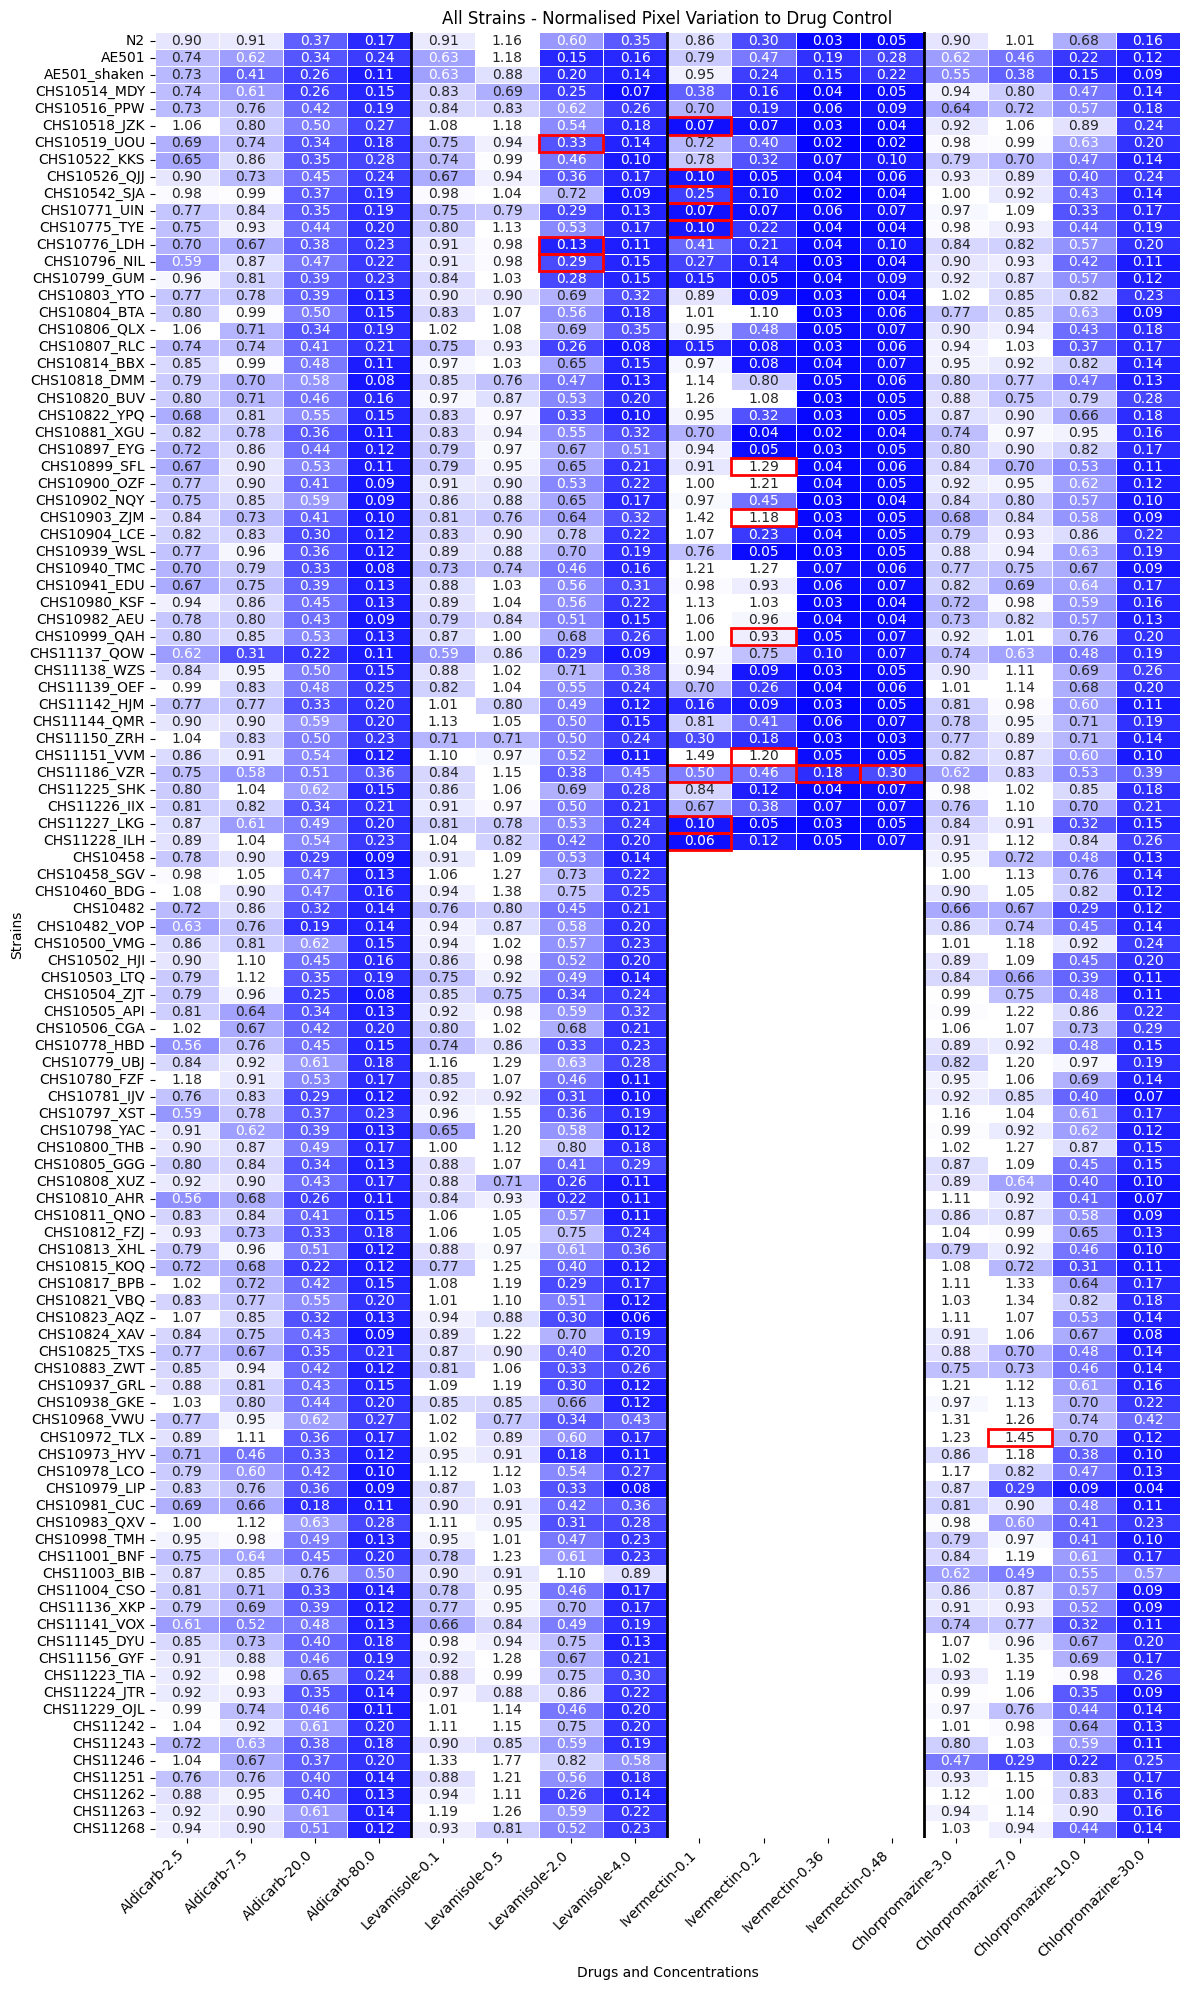

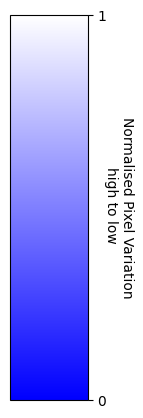

In [29]:
# heatmap with significane from multiple t-test with Bonferroni correction highlighted

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# Heatmap for normalised values 
df_pivot_norm_all = df_norm.copy()

# Pivot the DataFrame
df_pivot_norm_all = df_pivot_norm_all.pivot_table(index='strain', columns=['drug', 'concentration'], values='normalized_value')

# Flatten the multi-level column index for better readability in the heatmap
df_pivot_norm_all.columns = [f'{drug}-{concentration}' for drug, concentration in df_pivot_norm_all.columns]

# Define the custom order of the drugs
custom_order = ['Aldicarb', 'Levamisole', 'Ivermectin', 'Chlorpromazine']

# Reorder the columns based on the custom order
ordered_columns = []
for drug in custom_order:
    ordered_columns.extend([col for col in df_pivot_norm_all.columns if col.startswith(drug)])
df_pivot_norm_all = df_pivot_norm_all[ordered_columns]

# Reorder the rows to place 'N2' at the top and strains with missing values at the bottom
strains_with_missing_values = df_pivot_norm_all.index[df_pivot_norm_all.isnull().any(axis=1)].tolist()
strains_with_complete_values = df_pivot_norm_all.index.difference(strains_with_missing_values).tolist()

# Ensure 'N2' is at the top
if 'N2' in strains_with_complete_values:
    strains_with_complete_values.remove('N2')
    ordered_strains = ['N2'] + strains_with_complete_values + strains_with_missing_values
else:
    ordered_strains = strains_with_complete_values + strains_with_missing_values

df_pivot_norm_all = df_pivot_norm_all.loc[ordered_strains]

colors = [(0, 'blue'), (1, 'white')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Create a heatmap
plt.figure(figsize=(12, 20))
ax = sns.heatmap(df_pivot_norm_all, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, vmin=0, vmax=1, cbar=False)

# Customize the plot
plt.title('All Strains - Normalised Pixel Variation to Drug Control')
plt.xlabel('Drugs and Concentrations')
plt.ylabel('Strains')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Draw vertical lines between different drugs
drug_names = df_pivot_norm_all.columns
unique_drugs = df_pivot_norm_all.columns.str.split('-').str[0].unique()
for drug in unique_drugs[:-1]:  # Skip the last drug
    last_col_index = np.where(df_pivot_norm_all.columns.str.startswith(drug))[0][-1]
    ax.axvline(x=last_col_index + 1, color='black', linewidth=2)

# Highlight significant values
for _, row in results_df[results_df['significant']].iterrows():
    drug = row['drug']
    concentration = row['concentration']
    strain = row['strain']
    col_name = f'{drug}-{concentration}'
    if col_name in df_pivot_norm_all.columns and strain in df_pivot_norm_all.index:
        col_idx = df_pivot_norm_all.columns.get_loc(col_name)
        row_idx = df_pivot_norm_all.index.get_loc(strain)
        ax.add_patch(plt.Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='red', lw=2))

# Show the plot
plt.tight_layout()
plt.savefig(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/heatmap/significance/heatmap_pixelvariance_norm_sig_mttest_bonferroni_mutantVsN2_by_date.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a color bar for the heatmap
fig, ax = plt.subplots(figsize=(1, 5))
cmap = custom_cmap
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('Normalised Pixel Variation\nhigh to low ', rotation=270, labelpad=20)
cb1.set_ticks([0, 1])
cb1.set_ticklabels(['0', '1'])

# Save the color bar
fig.savefig(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/heatmap/significance/colorbar_pixelvariance_norm_sig_bonferroni.png', dpi=300, bbox_inches='tight')
plt.show()

In [30]:
# Multiple t-tests with Benjamini-Hochberg correction (t-test done by day - mutants compared to N2 of that imaging day)

import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests

df_norm_stat = df_norm.copy()

# Store results
results_list = []

# Get unique drugs, concentrations, and dates
unique_drugs = df_norm_stat['drug'].unique()
unique_concentrations = df_norm_stat['concentration'].unique()
unique_dates = df_norm_stat['date_yyyymmdd'].unique()

# Loop through each drug, concentration, and date
for drug in unique_drugs:
    for concentration in unique_concentrations:
        for date in unique_dates:
            # Subset data for the current drug, concentration, and date
            df_subset = df_norm_stat[(df_norm_stat['drug'] == drug) & 
                                     (df_norm_stat['concentration'] == concentration) & 
                                     (df_norm_stat['date_yyyymmdd'] == date)]

            # Get unique strains excluding N2
            mutant_strains = df_subset['strain'].unique()
            mutant_strains = [strain for strain in mutant_strains if strain != 'N2']

            p_values = []  # Store p-values for correction

            # Loop through each mutant and compare to N2 for the current drug, concentration, and date
            for mutant in mutant_strains:
                # Get data for N2 and mutant on the current drug, concentration, and date
                n2_data = df_subset[df_subset['strain'] == 'N2']['normalized_value']
                mutant_data = df_subset[df_subset['strain'] == mutant]['normalized_value']

                # Perform t-test
                t_stat, p_value = stats.ttest_ind(n2_data, mutant_data, equal_var=False, nan_policy='omit')
                p_values.append(p_value)

                # Store raw result
                results_list.append({
                    'drug': drug,
                    'concentration': concentration,
                    'date_yyyymmdd': date,
                    'strain': mutant,
                    't_stat': t_stat,
                    'p_value': p_value
                })

            # Apply Benjamini-Hochberg correction for all comparisons within this drug-concentration-date group
            if len(p_values) > 0:
                corrected_p = multipletests(p_values, method='fdr_bh')[1]

                # Update results with corrected p-values
                for i, mutant in enumerate(mutant_strains):
                    results_list[-len(mutant_strains) + i]['corrected_p_value'] = corrected_p[i]

# Create a dataframe from results
results_df = pd.DataFrame(results_list)

# Add significance indicator
results_df['significant'] = results_df['corrected_p_value'] < 0.05

# Display final results
#print(results_df)

results_df.to_csv(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/ttest/mutant_vs_n2_results_with_drugs_2_benjamini-hochberg_DaybyDayN2.csv', index=False)

# Filter the dataframe to get rows where 'significant' is True
significant_rows = results_df[results_df['significant'] == True]
print(f'Strains and drugs (concentration) with significant differences: {significant_rows}')
# number of significant results
num_significant = significant_rows.shape[0]
print(f'Number of significant results: {num_significant}')

/Users/jb3623/anaconda3/envs/not_hydra_videos/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Strains and drugs (concentration) with significant differences:                 drug  concentration date_yyyymmdd        strain     t_stat  \
636       Levamisole           2.00    2025-03-14  CHS10776_LDH  12.956362   
637       Levamisole           2.00    2025-03-14  CHS10519_UOU  12.482562   
638       Levamisole           2.00    2025-03-14  CHS11137_QOW   6.280026   
641       Levamisole           2.00    2025-03-14  CHS11186_VZR   5.880459   
648       Levamisole           2.00    2025-03-14  CHS10526_QJJ  12.899540   
651       Levamisole           2.00    2025-03-14  CHS10796_NIL  11.794119   
840       Ivermectin           0.10    2025-03-14  CHS10799_GUM   6.711208   
841       Ivermectin           0.10    2025-03-14  CHS11228_ILH  42.352345   
842       Ivermectin           0.10    2025-03-14  CHS11142_HJM  11.286833   
843       Ivermectin           0.10    2025-03-14  CHS10542_SJA  13.124032   
850       Ivermectin           0.10    2025-03-14  CHS10518_JZK  24.091716   


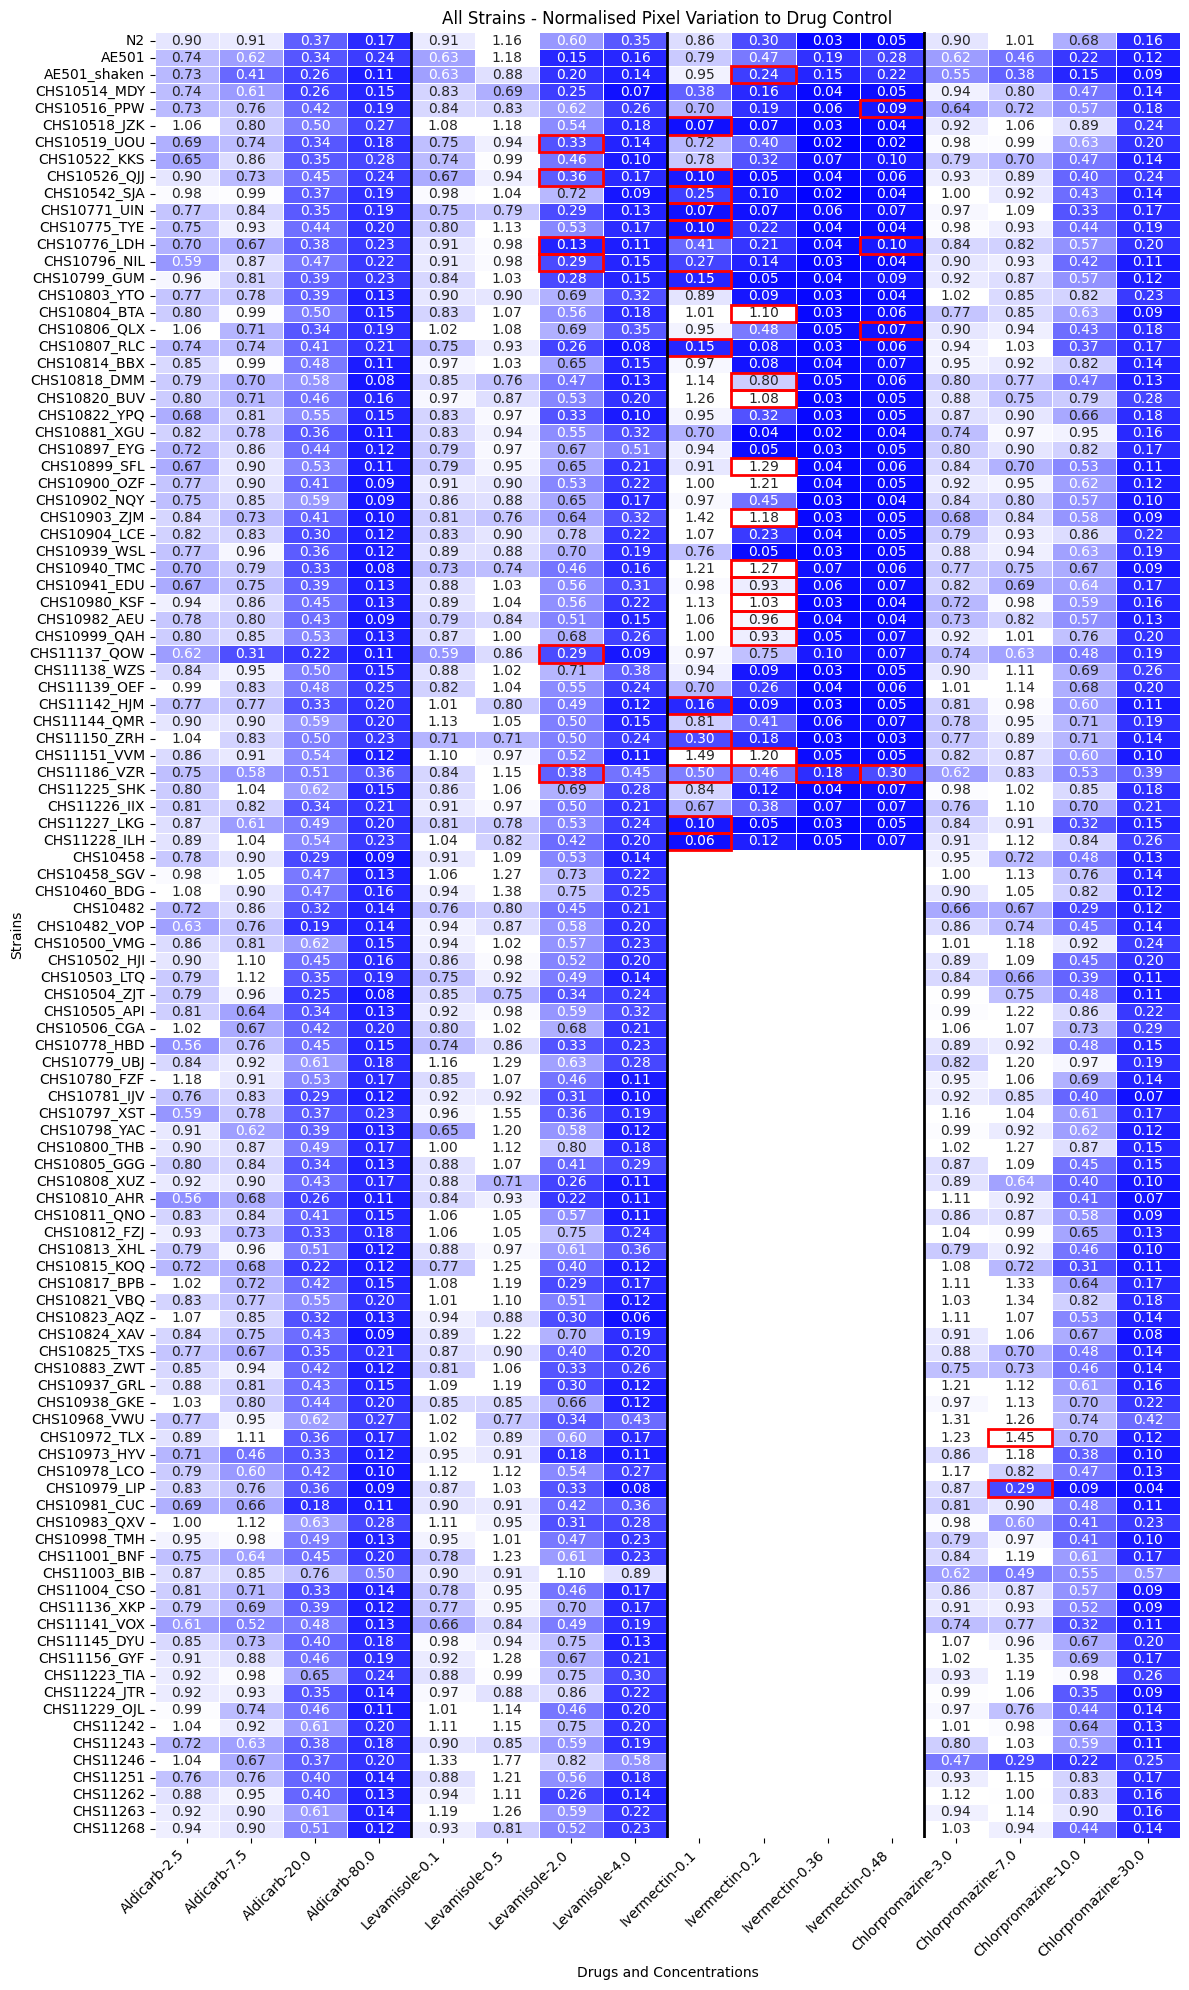

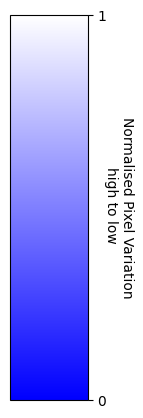

In [31]:
# heatmap with significane from Multiple t-tests with Benjamini-Hochberg correction highlighted - Day by day comparison with N2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# Heatmap for normalised values 
df_pivot_norm_all = df_norm.copy()

# Pivot the DataFrame
df_pivot_norm_all = df_pivot_norm_all.pivot_table(index='strain', columns=['drug', 'concentration'], values='normalized_value')

# Flatten the multi-level column index for better readability in the heatmap
df_pivot_norm_all.columns = [f'{drug}-{concentration}' for drug, concentration in df_pivot_norm_all.columns]

# Define the custom order of the drugs
custom_order = ['Aldicarb', 'Levamisole', 'Ivermectin', 'Chlorpromazine']

# Reorder the columns based on the custom order
ordered_columns = []
for drug in custom_order:
    ordered_columns.extend([col for col in df_pivot_norm_all.columns if col.startswith(drug)])
df_pivot_norm_all = df_pivot_norm_all[ordered_columns]

# Reorder the rows to place 'N2' at the top and strains with missing values at the bottom
strains_with_missing_values = df_pivot_norm_all.index[df_pivot_norm_all.isnull().any(axis=1)].tolist()
strains_with_complete_values = df_pivot_norm_all.index.difference(strains_with_missing_values).tolist()

# Ensure 'N2' is at the top
if 'N2' in strains_with_complete_values:
    strains_with_complete_values.remove('N2')
    ordered_strains = ['N2'] + strains_with_complete_values + strains_with_missing_values
else:
    ordered_strains = strains_with_complete_values + strains_with_missing_values

df_pivot_norm_all = df_pivot_norm_all.loc[ordered_strains]

colors = [(0, 'blue'), (1, 'white')]
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

# Create a heatmap
plt.figure(figsize=(12, 20))
ax = sns.heatmap(df_pivot_norm_all, cmap=custom_cmap, annot=True, fmt=".2f", linewidths=.5, vmin=0, vmax=1, cbar=False)

# Customize the plot
plt.title('All Strains - Normalised Pixel Variation to Drug Control')
plt.xlabel('Drugs and Concentrations')
plt.ylabel('Strains')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Draw vertical lines between different drugs
drug_names = df_pivot_norm_all.columns
unique_drugs = df_pivot_norm_all.columns.str.split('-').str[0].unique()
for drug in unique_drugs[:-1]:  # Skip the last drug
    last_col_index = np.where(df_pivot_norm_all.columns.str.startswith(drug))[0][-1]
    ax.axvline(x=last_col_index + 1, color='black', linewidth=2)

# Highlight significant values
for _, row in results_df[results_df['significant']].iterrows():
    drug = row['drug']
    concentration = row['concentration']
    strain = row['strain']
    col_name = f'{drug}-{concentration}'
    if col_name in df_pivot_norm_all.columns and strain in df_pivot_norm_all.index:
        col_idx = df_pivot_norm_all.columns.get_loc(col_name)
        row_idx = df_pivot_norm_all.index.get_loc(strain)
        ax.add_patch(plt.Rectangle((col_idx, row_idx), 1, 1, fill=False, edgecolor='red', lw=2))

# Show the plot
plt.tight_layout()
plt.savefig(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/heatmap/significance/heatmap_pixelvariance_norm_sig_mttest_benjamini-hochberg_mutantVsN2_by_date.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a color bar for the heatmap
fig, ax = plt.subplots(figsize=(1, 5))
cmap = custom_cmap
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('Normalised Pixel Variation\nhigh to low ', rotation=270, labelpad=20)
cb1.set_ticks([0, 1])
cb1.set_ticklabels(['0', '1'])

# Save the color bar
fig.savefig(f'/Volumes/behavgenom$/John/data_exp_info/NHR/Nematicidial_drugs/data/Analysis/figures/mutant_screen/all/heatmap/significance/colorbar_pixelvariance_norm_sig_mttest_benjamini-hochberg.png', dpi=300, bbox_inches='tight')
plt.show()

## *** Continue working on the code to aoutomatically generate all the plots of interest for the days of data that we have

Batch correction to the S.H2O or DMSO controls for individual strains to remove effect of strain to strain variation in controls.



In [4]:
# Make a new column called 'control' whereby in the 'drug' column, either S.H2O or DMSO is given based on the 'control_wells' dictionary

control_wells = {
    'Aldicarb': 'S.H2O',
    'Levamisole': 'S.H2O',
    'Chlorpromazine': 'S.H2O',
    'Ivermectin': 'DMSO',
    'S.H2O': 'S.H2O',
    'DMSO': 'DMSO'
}

df_250314_averaged['control'] = df_250314_averaged['drug'].map(control_wells)


In [17]:
# Batch correction

df_batchcorr_250314 = df_250314_averaged.copy()

# Define the batch correction function
def _proportional_scaling_correction(df):
    """
    Perform batch correction using proportional scaling based on 'strain'.

    Parameters:
    - df (pd.DataFrame): The DataFrame to correct.

    Returns:
    - pd.DataFrame: Batch-corrected DataFrame.
    """
    # Define control wells for each drug
    control_wells = {
        'Aldicarb': 'S.H2O',
        'Levamisole': 'S.H2O',
        'Chlorpromazine': 'S.H2O',
        'Ivermectin': 'DMSO',
        'S.H2O': 'S.H2O',
        'DMSO': 'DMSO'
    }

    # Calculate global means for control wells
    global_means = {}
    for drug, control in control_wells.items():
        control_data = df[(df['drug'] == drug) & (df['control'] == control)]
        global_means[drug] = control_data['value'].mean()

    corrected_df = df.copy()

    # Iterate over each strain
    for strain in df["strain"].unique():
        strain_idx = corrected_df["strain"] == strain

        for drug, control in control_wells.items():
            control_strain_idx = corrected_df[(df["strain"] == strain) &
                                              (df['drug'] == drug) &
                                              (df['control'] == control)]

            if not control_strain_idx.empty:
                batch_means = control_strain_idx['value'].mean()
                scaling_factors = global_means[drug] / batch_means
                corrected_df.loc[strain_idx & (corrected_df['drug'] == drug), 'value'] *= scaling_factors

    return corrected_df

# Apply the batch correction
df_batchcorr_250314 = _proportional_scaling_correction(df_batchcorr_250314)


In [77]:
# Plotting Batch Corrected values by plate

# Define color map for each drug
color_map = {
    'Aldicarb': 'red',
    'Levamisole': 'blue',
    'Ivermectin': 'green',
    'Chlorpromazine': 'purple',
    'S.H2O': 'gray',
    'DMSO': 'gray'
}

# Function to map drug names to colors
def get_color(drug_concentration):
    drug = drug_concentration.split()[0]
    return color_map.get(drug, 'black')

# Plot all drugs and concentrations in one plot per strain
strains = df_batchcorr_250314['strain'].unique()
for strain in strains:
    plt.figure(figsize=(12, 8))
    plt.title(f"Strain: {strain}")
    
    strain_data = df_batchcorr_250314[df_batchcorr_250314['strain'] == strain]
    
    # Create a combined column for drug and concentration
    strain_data['drug_concentration'] = strain_data['drug'] + ' ' + strain_data['concentration'].astype(str) + 'µM'
    
    # Create a color palette for the drug_concentration column
    unique_drug_concentrations = strain_data['drug_concentration'].unique()
    palette = {dc: get_color(dc) for dc in unique_drug_concentrations}
    
    # Create the boxplot
    boxplot = sns.boxplot(data=strain_data, x='drug_concentration', y='value', palette=palette)
    
    # Create the striplot to show all data points
    striplot = sns.stripplot(data=strain_data, x='drug_concentration', y='value', color='black', jitter=True, marker='o', alpha=0.5)
    
    # Plot all values for wells in row E (S.H2O) and row F (DMSO)
    sh2o_values = df_batchcorr_250314[(df_batchcorr_250314['strain'] == strain) & df_batchcorr_250314['well'].str.startswith('E')]['value']
    dmso_values = df_batchcorr_250314[(df_batchcorr_250314['strain'] == strain) & df_batchcorr_250314['well'].str.startswith('F')]['value']
    
    #plt.scatter(['S.H2O'] * len(sh2o_values), sh2o_values, label='S.H2O', color='gray')
    #plt.scatter(['DMSO'] * len(dmso_values), dmso_values, label='DMSO', color='gray')
    
    # Add labels and title
    plt.xlabel('Drug and Concentration')
    plt.ylabel('Pixel Variation - Batch corrected by drug control by strain')
    plt.title(f"All drugs for {strain}")
    
    # Change x-axis label orientation
    plt.xticks(rotation=90)
    plt.legend()

    # Save the plot with high DPI
    #strain = plate_data['strain'].iloc[0]  # Assuming 'strain' column exists
    plt.savefig(f'/Volumes/behavgenom$-1/John/data_exp_info/NHR/Bonnie_compounds/data/figures/mutant_screen/250314/by_plate/batch_corr/{strain}_pixelvariance.png', dpi=300, bbox_inches='tight')
    plt.close('all')
    #plt.show()    



NameError: name 'df_batchcorr_250314' is not defined

In [82]:
# Plotting Batch corrected - by drug & concentration

# Define color map for each drug
color_map = {
    'Aldicarb': 'red',
    'Levamisole': 'blue',
    'Ivermectin': 'green',
    'Chlorpromazine': 'purple',
    'S.H2O': 'gray',
    'DMSO': 'gray'
}

# Function to map drug names to colors
def get_color(drug):
    return color_map.get(drug, 'black')

# Get unique combinations of drug and concentration
drug_concentrations = df_batchcorr_250314[['drug', 'concentration']].drop_duplicates()

# Determine the range of concentrations
concentration_values = drug_concentrations['concentration'].unique()
concentration_values_sorted = np.sort(concentration_values)

# Create a mapping from concentration to alpha value
alpha_map = {concentration: (i + 1) / len(concentration_values_sorted) for i, concentration in enumerate(concentration_values_sorted)}

# Plot all strains for each drug and concentration
for _, row in drug_concentrations.iterrows():
    drug = row['drug']
    concentration = row['concentration']
    
    plt.figure(figsize=(12, 10))
    plt.title(f"Drug: {drug}, Concentration: {concentration}µM")
    
    # Filter data for the current drug and concentration
    drug_concentration_data = df_batchcorr_250314[(df_batchcorr_250314['drug'] == drug) & (df_batchcorr_250314['concentration'] == concentration)]
    
    # Calculate the mean value for each strain
    strain_means = drug_concentration_data.groupby('strain')['value'].mean()
    
    # Calculate the mean value for N2
    n2_mean = strain_means['N2']
    
    # Calculate the difference to the mean of N2
    strain_diffs = strain_means - n2_mean
    
    # Sort strains based on the difference
    sorted_strains = strain_diffs.abs().sort_values().index.tolist()
    
    # Ensure N2 is the first in the order
    order = ['N2'] + [strain for strain in sorted_strains if strain != 'N2']
    
    # Determine the transparency based on concentration
    alpha = alpha_map[concentration]
    
    # Create the boxplot
    boxplot = sns.boxplot(data=drug_concentration_data, x='strain', y='value', order=order, color=get_color(drug), fliersize=0)
    
    # Set the transparency for the boxplot elements
    for patch in boxplot.patches:
        r, g, b, _ = patch.get_facecolor()
        patch.set_facecolor((r, g, b, alpha))
    
    # Create the striplot to show all data points
    striplot = sns.stripplot(data=drug_concentration_data, x='strain', y='value', color='black', jitter=True, marker='o', alpha=0.5, order=order)
    
    # Add labels and title
    plt.xlabel('Strain, Drug and Concentration')
    plt.ylabel('Pixel Variation - Batch corrected')

    # Change x-axis label orientation
    plt.xticks(rotation=90)

    # Format the filename
    drug_formatted = drug.lower().replace(' ', '_')
    concentration_formatted = str(concentration).replace('.', '_')
    filename = f'{drug_formatted}_{concentration_formatted}_normalised_pixelvariance.png'
    
    # Save the plot with high DPI
    plt.savefig(f'/Volumes/behavgenom$-1/John/data_exp_info/NHR/Bonnie_compounds/data/figures/mutant_screen/250314/by_drug_concentration/batch_corr/{filename}', dpi=300, bbox_inches='tight')

    plt.show()


NameError: name 'df_batchcorr_250314' is not defined